In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import os
import time
from tqdm import tqdm
import math

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from keras import initializers, regularizers, constraints, optimizers, layers \

from fastai.vision import *
    
import matplotlib.pyplot as plt
plt.switch_backend('agg')


Using TensorFlow backend.


In [2]:
# Download data and create dataframe
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')

In [3]:
# Shuffle the indices randomly
df = df.iloc[np.random.permutation(len(df))]
print(df.head())

        label                                               text  is_valid
811  negative  I am sick and tired of all these little weenie...      True
356  positive  This is quite an amazing film to watch. Using ...     False
501  negative  Terrible acting by Potter and a flat plot with...     False
359  negative  Movie had some good acting and good moments (t...     False
48   negative  This is almost certainly the worst Western I'v...     False


In [4]:
# Replace string value with integers
df['label'] = df['label'].map({'negative':0, 'positive':1})
print(df.head())

     label                                               text  is_valid
811      0  I am sick and tired of all these little weenie...      True
356      1  This is quite an amazing film to watch. Using ...     False
501      0  Terrible acting by Potter and a flat plot with...     False
359      0  Movie had some good acting and good moments (t...     False
48       0  This is almost certainly the worst Western I'v...     False


In [5]:
VALIDATION_PERCENT = 0.2
EMBED_SIZE = 200 # size of word vector
MAX_FEATURES = 10000 # number of unique words to use (i.e num rows in embedding vector)
MAX_LEN = 200 # max number of words in a review
NUMBER_OF_CLASSES = 1 # output of model

In [6]:
# Split into training and validation sets
cut = int(VALIDATION_PERCENT * len(df)) + 1
train_df, valid_df = df[cut:], df[:cut]

print(train_df.head())
print(valid_df.head())

     label                                               text  is_valid
297      1  <br /><br />I have seen this movie many times....     False
126      0  I'm not going to criticize the movie. There is...     False
335      1  Every second of the film is gorgeous. And that...     False
200      0  I loved the first "Azumi" movie. I've seen Ms....     False
300      1  Once again the two bickering professors must j...     False
     label                                               text  is_valid
811      0  I am sick and tired of all these little weenie...      True
356      1  This is quite an amazing film to watch. Using ...     False
501      0  Terrible acting by Potter and a flat plot with...     False
359      0  Movie had some good acting and good moments (t...     False
48       0  This is almost certainly the worst Western I'v...     False


In [7]:
# Fill missing values with _na_
train_X = train_df["text"].fillna("_na_").values
valid_X = valid_df["text"].fillna("_na_").values

In [8]:
# Tokenize the sentences
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
valid_X = tokenizer.texts_to_sequences(valid_X)

In [10]:
print('Train_X: ')
print(train_X[0:5])

print('Tokenizer: ')
word_index = tokenizer.word_index
print('# of unique tokens: ', len(word_index))
print(list(tokenizer.index_word.items())[0:10])
print(list(tokenizer.index_word.items())[-10:])

Train_X: 
[[7, 7, 11, 25, 109, 10, 16, 108, 240, 29, 223, 3, 2148, 18, 8812, 24, 876, 220, 5962, 8, 59, 1960, 96, 5, 534, 69, 6, 3, 131, 8, 66, 2393, 2394, 407, 5963, 557, 12, 26, 6, 5, 27, 3130, 2, 40, 382, 426, 5, 1, 630, 4, 843, 26, 3697, 2, 5964, 2, 762, 26, 8813, 34, 8814, 5, 8815, 2, 910, 1, 8816, 4, 129, 1097, 96, 25, 11, 109, 138, 3, 595, 252, 33, 90, 249, 658, 39, 596, 515, 39, 1048, 9, 13, 88, 11, 121, 14, 287, 12, 2393, 2394, 353, 1659, 1961, 13, 2, 6, 3, 249, 4, 85, 1448, 220, 11, 953, 9, 59, 502, 5, 573, 14, 158, 516, 1449, 11, 207, 27, 574, 8, 10, 8817, 38, 998, 158, 39, 36, 100, 11, 217, 10, 19, 14, 1, 232, 58, 20, 844, 11, 8818, 5, 305, 1, 156, 3131, 3, 1962, 4, 1, 1660, 3132, 240, 1, 823, 13, 8819, 5, 4581, 5965, 2, 1, 823, 13, 443, 5965, 22, 21, 1213, 28, 4, 1, 1049, 154, 4, 31, 58, 1450, 88, 79, 22, 1364, 5, 27, 911, 1, 1049, 154, 23, 1451, 13, 999, 4582, 2, 2393, 2394, 11, 13, 4583, 18, 24, 679, 11, 8820, 8821, 147, 5, 23, 407, 5963, 2, 11, 408, 52, 49, 14, 250, 109

In [11]:
# Pad the sequences to ensure constant length
train_X = pad_sequences(train_X, maxlen=MAX_LEN)
valid_X = pad_sequences(valid_X, maxlen=MAX_LEN)

print(train_X)
print(valid_X)

[[ 998  158   39   36 ...  494    4   23  252]
 [   0    0    0    0 ...   25  199  152    9]
 [4590    4 1969    2 ...    3 1101  827   19]
 [   0    0    0    0 ...   96  151  198    9]
 ...
 [   0    0    0    0 ... 4392   20   31 6458]
 [ 832  175  577 8780 ...   63  103   39 1431]
 [2611  318   41   30 ...   59  741  281  465]
 [  12   87  120 3581 ...   47   13 1966   41]]
[[   6   24   36   70 ...  228  334  188  123]
 [  41    4 2154  152 ... 1373   18  126    6]
 [   0    0    0    0 ...   12    6    1 2714]
 [  30 2726   82    4 ...  106  531   10 3892]
 ...
 [1592    4    1  256 ...  152  106   35   10]
 [   0    0    0    0 ...   28 6266  976    9]
 [ 182    3  772  766 ...   28    4   23  116]
 [  16  286  169 3498 ...  167    3  119  768]]


In [13]:
# Get the target values
train_Y = train_df['label'].values
valid_Y = valid_df['label'].values

print(train_Y)
print(valid_Y)

[1 0 1 0 ... 0 0 0 0]
[0 1 0 0 ... 0 1 1 0]


In [14]:
# Create input
input = Input(shape=(MAX_LEN,), dtype='int32')

In [15]:
# Either use pretrained embeddings or create own embeddings from data

# PRETRAINED
# -----------------------------------
# embeddings_index = {}
# f = open('glove.6B.100d.txt',encoding='utf8')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()
# 
# print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))
# 
# embedding_matrix = np.random.random((len(word_index) + 1, EMBED_SIZE))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector
# 
# embedding_layer = Embedding(len(word_index) + 1, EMBED_SIZE, weights=[embedding_matrix], input_length=MAX_LEN, trainable=True)
# embedded_sequences = embedding_layer(input)

# Create own embeddings
# -----------------------------------
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(input)

In [16]:
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(4)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)

preds = Dense(NUMBER_OF_CLASSES, activation='sigmoid')(x)

model = Model(input, preds)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 200)          2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 45, 128)           82048     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
__________

In [17]:
checkpoint=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(train_X, train_Y, validation_data=(valid_X, valid_Y), epochs=15, batch_size=2, callbacks=[checkpoint])

Train on 799 samples, validate on 201 samples
Epoch 1/15


  2/799 [..............................] - ETA: 3:44 - loss: 0.6888 - acc: 0.5000

  6/799 [..............................] - ETA: 1:23 - loss: 0.6854 - acc: 0.6667

 10/799 [..............................] - ETA: 55s - loss: 0.6919 - acc: 0.6000 

 14/799 [..............................] - ETA: 42s - loss: 0.7213 - acc: 0.5714

 18/799 [..............................] - ETA: 35s - loss: 0.7100 - acc: 0.6111

 22/799 [..............................] - ETA: 32s - loss: 0.6911 - acc: 0.6364

 26/799 [..............................] - ETA: 28s - loss: 0.7074 - acc: 0.6154

 30/799 [>.............................] - ETA: 26s - loss: 0.7073 - acc: 0.6000

 34/799 [>.............................] - ETA: 24s - loss: 0.7052 - acc: 0.5882

 38/799 [>.............................] - ETA: 23s - loss: 0.7126 - acc: 0.5526

 42/799 [>.............................] - ETA: 21s - loss: 0.7098 - acc: 0.5476

 46/799 [>.............................] - ETA: 20s - loss: 0.7056 - acc: 0.5652

 50/799 [>.............................] - ETA: 20s - loss: 0.7127 - acc: 0.5200

 54/799 [=>............................] - ETA: 19s - loss: 0.7119 - acc: 0.5185

 58/799 [=>............................] - ETA: 18s - loss: 0.7125 - acc: 0.5000

 62/799 [=>............................] - ETA: 18s - loss: 0.7117 - acc: 0.5000

 66/799 [=>............................] - ETA: 17s - loss: 0.7099 - acc: 0.5152

 70/799 [=>............................] - ETA: 17s - loss: 0.7074 - acc: 0.5286

 74/799 [=>............................] - ETA: 16s - loss: 0.7076 - acc: 0.5270

 78/799 [=>............................] - ETA: 16s - loss: 0.7076 - acc: 0.5256

 82/799 [==>...........................] - ETA: 15s - loss: 0.7069 - acc: 0.5244

 86/799 [==>...........................] - ETA: 15s - loss: 0.7065 - acc: 0.5233

 90/799 [==>...........................] - ETA: 15s - loss: 0.7051 - acc: 0.5333

 94/799 [==>...........................] - ETA: 15s - loss: 0.7050 - acc: 0.5319

 98/799 [==>...........................] - ETA: 14s - loss: 0.7046 - acc: 0.5306

102/799 [==>...........................] - ETA: 14s - loss: 0.7045 - acc: 0.5294

106/799 [==>...........................] - ETA: 14s - loss: 0.7052 - acc: 0.5189

110/799 [===>..........................] - ETA: 14s - loss: 0.7044 - acc: 0.5182

114/799 [===>..........................] - ETA: 14s - loss: 0.7042 - acc: 0.5175

118/799 [===>..........................] - ETA: 13s - loss: 0.7040 - acc: 0.5169

122/799 [===>..........................] - ETA: 13s - loss: 0.7008 - acc: 0.5328

126/799 [===>..........................] - ETA: 13s - loss: 0.6981 - acc: 0.5397

130/799 [===>..........................] - ETA: 13s - loss: 0.6986 - acc: 0.5385

134/799 [====>.........................] - ETA: 13s - loss: 0.6975 - acc: 0.5373

138/799 [====>.........................] - ETA: 13s - loss: 0.6983 - acc: 0.5362

142/799 [====>.........................] - ETA: 13s - loss: 0.6966 - acc: 0.5423

146/799 [====>.........................] - ETA: 13s - loss: 0.6961 - acc: 0.5411

150/799 [====>.........................] - ETA: 12s - loss: 0.6969 - acc: 0.5400

154/799 [====>.........................] - ETA: 12s - loss: 0.6948 - acc: 0.5455

158/799 [====>.........................] - ETA: 12s - loss: 0.6929 - acc: 0.5506

162/799 [=====>........................] - ETA: 12s - loss: 0.6925 - acc: 0.5494

164/799 [=====>........................] - ETA: 12s - loss: 0.6928 - acc: 0.5488

168/799 [=====>........................] - ETA: 12s - loss: 0.6910 - acc: 0.5536

172/799 [=====>........................] - ETA: 12s - loss: 0.6954 - acc: 0.5523

176/799 [=====>........................] - ETA: 12s - loss: 0.6940 - acc: 0.5511

180/799 [=====>........................] - ETA: 12s - loss: 0.6948 - acc: 0.5500

184/799 [=====>........................] - ETA: 11s - loss: 0.6960 - acc: 0.5489

188/799 [======>.......................] - ETA: 11s - loss: 0.6927 - acc: 0.5585

192/799 [======>.......................] - ETA: 11s - loss: 0.6924 - acc: 0.5573

196/799 [======>.......................] - ETA: 11s - loss: 0.6947 - acc: 0.5510

200/799 [======>.......................] - ETA: 11s - loss: 0.6969 - acc: 0.5400

204/799 [======>.......................] - ETA: 11s - loss: 0.6973 - acc: 0.5343

208/799 [======>.......................] - ETA: 11s - loss: 0.6974 - acc: 0.5337

212/799 [======>.......................] - ETA: 11s - loss: 0.6969 - acc: 0.5377

216/799 [=======>......................] - ETA: 10s - loss: 0.6958 - acc: 0.5417

220/799 [=======>......................] - ETA: 10s - loss: 0.6971 - acc: 0.5364

224/799 [=======>......................] - ETA: 10s - loss: 0.6973 - acc: 0.5357

228/799 [=======>......................] - ETA: 10s - loss: 0.6971 - acc: 0.5351

232/799 [=======>......................] - ETA: 10s - loss: 0.6972 - acc: 0.5345

236/799 [=======>......................] - ETA: 10s - loss: 0.6962 - acc: 0.5381

240/799 [========>.....................] - ETA: 10s - loss: 0.6967 - acc: 0.5375

244/799 [========>.....................] - ETA: 10s - loss: 0.6962 - acc: 0.5410

248/799 [========>.....................] - ETA: 9s - loss: 0.6974 - acc: 0.5363 

252/799 [========>.....................] - ETA: 9s - loss: 0.6975 - acc: 0.5357

256/799 [========>.....................] - ETA: 9s - loss: 0.6974 - acc: 0.5352

260/799 [========>.....................] - ETA: 9s - loss: 0.6961 - acc: 0.5423

264/799 [========>.....................] - ETA: 9s - loss: 0.6934 - acc: 0.5492

268/799 [=========>....................] - ETA: 9s - loss: 0.6943 - acc: 0.5485

272/799 [=========>....................] - ETA: 9s - loss: 0.6906 - acc: 0.5551

276/799 [=========>....................] - ETA: 9s - loss: 0.6941 - acc: 0.5543

280/799 [=========>....................] - ETA: 9s - loss: 0.6901 - acc: 0.5607

284/799 [=========>....................] - ETA: 8s - loss: 0.6929 - acc: 0.5599

288/799 [=========>....................] - ETA: 8s - loss: 0.6904 - acc: 0.5625

292/799 [=========>....................] - ETA: 8s - loss: 0.6892 - acc: 0.5651

296/799 [==========>...................] - ETA: 8s - loss: 0.6903 - acc: 0.5642

300/799 [==========>...................] - ETA: 8s - loss: 0.6919 - acc: 0.5600

304/799 [==========>...................] - ETA: 8s - loss: 0.6910 - acc: 0.5625

308/799 [==========>...................] - ETA: 8s - loss: 0.6913 - acc: 0.5617

312/799 [==========>...................] - ETA: 8s - loss: 0.6915 - acc: 0.5609

316/799 [==========>...................] - ETA: 8s - loss: 0.6915 - acc: 0.5601

320/799 [===========>..................] - ETA: 8s - loss: 0.6903 - acc: 0.5625

324/799 [===========>..................] - ETA: 8s - loss: 0.6883 - acc: 0.5648

328/799 [===========>..................] - ETA: 7s - loss: 0.6903 - acc: 0.5610

332/799 [===========>..................] - ETA: 7s - loss: 0.6917 - acc: 0.5572

336/799 [===========>..................] - ETA: 7s - loss: 0.6911 - acc: 0.5595

340/799 [===========>..................] - ETA: 7s - loss: 0.6918 - acc: 0.5559

344/799 [===========>..................] - ETA: 7s - loss: 0.6921 - acc: 0.5523

348/799 [============>.................] - ETA: 7s - loss: 0.6922 - acc: 0.5489

352/799 [============>.................] - ETA: 7s - loss: 0.6923 - acc: 0.5426

356/799 [============>.................] - ETA: 7s - loss: 0.6923 - acc: 0.5449

360/799 [============>.................] - ETA: 7s - loss: 0.6917 - acc: 0.5500

364/799 [============>.................] - ETA: 7s - loss: 0.6908 - acc: 0.5522

368/799 [============>.................] - ETA: 7s - loss: 0.6894 - acc: 0.5543

372/799 [============>.................] - ETA: 7s - loss: 0.6913 - acc: 0.5538

376/799 [=============>................] - ETA: 6s - loss: 0.6915 - acc: 0.5532

380/799 [=============>................] - ETA: 6s - loss: 0.6906 - acc: 0.5553

384/799 [=============>................] - ETA: 6s - loss: 0.6893 - acc: 0.5573

388/799 [=============>................] - ETA: 6s - loss: 0.6919 - acc: 0.5515

392/799 [=============>................] - ETA: 6s - loss: 0.6911 - acc: 0.5536

396/799 [=============>................] - ETA: 6s - loss: 0.6917 - acc: 0.5530

400/799 [==============>...............] - ETA: 6s - loss: 0.6913 - acc: 0.5550

404/799 [==============>...............] - ETA: 6s - loss: 0.6917 - acc: 0.5520

408/799 [==============>...............] - ETA: 6s - loss: 0.6909 - acc: 0.5539

412/799 [==============>...............] - ETA: 6s - loss: 0.6915 - acc: 0.5510

416/799 [==============>...............] - ETA: 6s - loss: 0.6911 - acc: 0.5505

420/799 [==============>...............] - ETA: 6s - loss: 0.6909 - acc: 0.5500

424/799 [==============>...............] - ETA: 6s - loss: 0.6916 - acc: 0.5472

428/799 [===============>..............] - ETA: 5s - loss: 0.6913 - acc: 0.5491

432/799 [===============>..............] - ETA: 5s - loss: 0.6916 - acc: 0.5463

436/799 [===============>..............] - ETA: 5s - loss: 0.6913 - acc: 0.5459

440/799 [===============>..............] - ETA: 5s - loss: 0.6913 - acc: 0.5432

444/799 [===============>..............] - ETA: 5s - loss: 0.6911 - acc: 0.5450

448/799 [===============>..............] - ETA: 5s - loss: 0.6905 - acc: 0.5469

452/799 [===============>..............] - ETA: 5s - loss: 0.6902 - acc: 0.5465

456/799 [================>.............] - ETA: 5s - loss: 0.6878 - acc: 0.5504

460/799 [================>.............] - ETA: 5s - loss: 0.6901 - acc: 0.5478

464/799 [================>.............] - ETA: 5s - loss: 0.6906 - acc: 0.5453

468/799 [================>.............] - ETA: 5s - loss: 0.6908 - acc: 0.5406

472/799 [================>.............] - ETA: 5s - loss: 0.6905 - acc: 0.5424

476/799 [================>.............] - ETA: 5s - loss: 0.6900 - acc: 0.5462

480/799 [=================>............] - ETA: 5s - loss: 0.6907 - acc: 0.5437

484/799 [=================>............] - ETA: 4s - loss: 0.6905 - acc: 0.5455

488/799 [=================>............] - ETA: 4s - loss: 0.6896 - acc: 0.5492

492/799 [=================>............] - ETA: 4s - loss: 0.6902 - acc: 0.5467

496/799 [=================>............] - ETA: 4s - loss: 0.6899 - acc: 0.5464

500/799 [=================>............] - ETA: 4s - loss: 0.6894 - acc: 0.5460

504/799 [=================>............] - ETA: 4s - loss: 0.6901 - acc: 0.5437

508/799 [==================>...........] - ETA: 4s - loss: 0.6902 - acc: 0.5433

512/799 [==================>...........] - ETA: 4s - loss: 0.6900 - acc: 0.5410

516/799 [==================>...........] - ETA: 4s - loss: 0.6901 - acc: 0.5407

520/799 [==================>...........] - ETA: 4s - loss: 0.6896 - acc: 0.5442

524/799 [==================>...........] - ETA: 4s - loss: 0.6888 - acc: 0.5477

528/799 [==================>...........] - ETA: 4s - loss: 0.6892 - acc: 0.5492

532/799 [==================>...........] - ETA: 4s - loss: 0.6881 - acc: 0.5526

536/799 [===================>..........] - ETA: 4s - loss: 0.6881 - acc: 0.5504

540/799 [===================>..........] - ETA: 4s - loss: 0.6875 - acc: 0.5537

544/799 [===================>..........] - ETA: 3s - loss: 0.6868 - acc: 0.5551

548/799 [===================>..........] - ETA: 3s - loss: 0.6871 - acc: 0.5566

552/799 [===================>..........] - ETA: 3s - loss: 0.6895 - acc: 0.5543

556/799 [===================>..........] - ETA: 3s - loss: 0.6902 - acc: 0.5522

560/799 [====================>.........] - ETA: 3s - loss: 0.6896 - acc: 0.5536

564/799 [====================>.........] - ETA: 3s - loss: 0.6898 - acc: 0.5532

568/799 [====================>.........] - ETA: 3s - loss: 0.6885 - acc: 0.5563

572/799 [====================>.........] - ETA: 3s - loss: 0.6886 - acc: 0.5577

576/799 [====================>.........] - ETA: 3s - loss: 0.6878 - acc: 0.5590

580/799 [====================>.........] - ETA: 3s - loss: 0.6877 - acc: 0.5586

584/799 [====================>.........] - ETA: 3s - loss: 0.6872 - acc: 0.5616

588/799 [=====================>........] - ETA: 3s - loss: 0.6860 - acc: 0.5629

592/799 [=====================>........] - ETA: 3s - loss: 0.6875 - acc: 0.5625

596/799 [=====================>........] - ETA: 3s - loss: 0.6865 - acc: 0.5654

600/799 [=====================>........] - ETA: 3s - loss: 0.6850 - acc: 0.5683

604/799 [=====================>........] - ETA: 2s - loss: 0.6846 - acc: 0.5695

608/799 [=====================>........] - ETA: 2s - loss: 0.6852 - acc: 0.5691

612/799 [=====================>........] - ETA: 2s - loss: 0.6847 - acc: 0.5703

616/799 [======================>.......] - ETA: 2s - loss: 0.6845 - acc: 0.5714

620/799 [======================>.......] - ETA: 2s - loss: 0.6854 - acc: 0.5710

624/799 [======================>.......] - ETA: 2s - loss: 0.6858 - acc: 0.5705

628/799 [======================>.......] - ETA: 2s - loss: 0.6853 - acc: 0.5701

632/799 [======================>.......] - ETA: 2s - loss: 0.6830 - acc: 0.5728

636/799 [======================>.......] - ETA: 2s - loss: 0.6813 - acc: 0.5739

640/799 [=======================>......] - ETA: 2s - loss: 0.6808 - acc: 0.5734

644/799 [=======================>......] - ETA: 2s - loss: 0.6805 - acc: 0.5730

648/799 [=======================>......] - ETA: 2s - loss: 0.6810 - acc: 0.5725

652/799 [=======================>......] - ETA: 2s - loss: 0.6789 - acc: 0.5752

656/799 [=======================>......] - ETA: 2s - loss: 0.6778 - acc: 0.5762

660/799 [=======================>......] - ETA: 2s - loss: 0.6801 - acc: 0.5727

664/799 [=======================>......] - ETA: 2s - loss: 0.6775 - acc: 0.5753

668/799 [========================>.....] - ETA: 1s - loss: 0.6767 - acc: 0.5763

672/799 [========================>.....] - ETA: 1s - loss: 0.6779 - acc: 0.5759

676/799 [========================>.....] - ETA: 1s - loss: 0.6752 - acc: 0.5784

680/799 [========================>.....] - ETA: 1s - loss: 0.6784 - acc: 0.5765

684/799 [========================>.....] - ETA: 1s - loss: 0.6786 - acc: 0.5760

688/799 [========================>.....] - ETA: 1s - loss: 0.6784 - acc: 0.5770

692/799 [========================>.....] - ETA: 1s - loss: 0.6794 - acc: 0.5766

696/799 [=========================>....] - ETA: 1s - loss: 0.6783 - acc: 0.5790

700/799 [=========================>....] - ETA: 1s - loss: 0.6764 - acc: 0.5814

704/799 [=========================>....] - ETA: 1s - loss: 0.6765 - acc: 0.5824

708/799 [=========================>....] - ETA: 1s - loss: 0.6766 - acc: 0.5819

712/799 [=========================>....] - ETA: 1s - loss: 0.6772 - acc: 0.5829

716/799 [=========================>....] - ETA: 1s - loss: 0.6756 - acc: 0.5852

720/799 [==========================>...] - ETA: 1s - loss: 0.6757 - acc: 0.5847

724/799 [==========================>...] - ETA: 1s - loss: 0.6781 - acc: 0.5829

728/799 [==========================>...] - ETA: 1s - loss: 0.6765 - acc: 0.5852

732/799 [==========================>...] - ETA: 1s - loss: 0.6758 - acc: 0.5861

736/799 [==========================>...] - ETA: 0s - loss: 0.6742 - acc: 0.5870

740/799 [==========================>...] - ETA: 0s - loss: 0.6734 - acc: 0.5878

744/799 [==========================>...] - ETA: 0s - loss: 0.6718 - acc: 0.5901

748/799 [===========================>..] - ETA: 0s - loss: 0.6705 - acc: 0.5922

752/799 [===========================>..] - ETA: 0s - loss: 0.6690 - acc: 0.5944

756/799 [===========================>..] - ETA: 0s - loss: 0.6677 - acc: 0.5952

760/799 [===========================>..] - ETA: 0s - loss: 0.6663 - acc: 0.5961

764/799 [===========================>..] - ETA: 0s - loss: 0.6665 - acc: 0.5955

768/799 [===========================>..] - ETA: 0s - loss: 0.6644 - acc: 0.5977

772/799 [===========================>..] - ETA: 0s - loss: 0.6636 - acc: 0.5984

776/799 [============================>.] - ETA: 0s - loss: 0.6649 - acc: 0.5966

780/799 [============================>.] - ETA: 0s - loss: 0.6638 - acc: 0.5974

784/799 [============================>.] - ETA: 0s - loss: 0.6636 - acc: 0.5969

788/799 [============================>.] - ETA: 0s - loss: 0.6650 - acc: 0.5977

792/799 [============================>.] - ETA: 0s - loss: 0.6636 - acc: 0.5985

796/799 [============================>.] - ETA: 0s - loss: 0.6635 - acc: 0.5980

799/799 [==============================] - 12s 15ms/step - loss: 0.6624 - acc: 0.5995 - val_loss: 0.5952 - val_acc: 0.6915



Epoch 00001: val_acc improved from -inf to 0.69154, saving model to model_cnn.hdf5
Epoch 2/15
  2/799 [..............................] - ETA: 10s - loss: 0.0595 - acc: 1.0000

  6/799 [..............................] - ETA: 11s - loss: 0.0793 - acc: 1.0000

 10/799 [..............................] - ETA: 11s - loss: 0.2444 - acc: 0.9000

 14/799 [..............................] - ETA: 11s - loss: 0.3111 - acc: 0.7857

 18/799 [..............................] - ETA: 11s - loss: 0.2916 - acc: 0.8333

 22/799 [..............................] - ETA: 11s - loss: 0.3014 - acc: 0.8182

 26/799 [..............................] - ETA: 10s - loss: 0.3122 - acc: 0.8077

 30/799 [>.............................] - ETA: 10s - loss: 0.2891 - acc: 0.8333

 34/799 [>.............................] - ETA: 11s - loss: 0.3544 - acc: 0.8235

 38/799 [>.............................] - ETA: 11s - loss: 0.3654 - acc: 0.8158

 42/799 [>.............................] - ETA: 11s - loss: 0.3724 - acc: 0.8095

 46/799 [>.............................] - ETA: 11s - loss: 0.3775 - acc: 0.8261

 50/799 [>.............................] - ETA: 11s - loss: 0.3892 - acc: 0.8200

 54/799 [=>............................] - ETA: 10s - loss: 0.4002 - acc: 0.8148

 58/799 [=>............................] - ETA: 10s - loss: 0.3897 - acc: 0.8276

 62/799 [=>............................] - ETA: 10s - loss: 0.3691 - acc: 0.8387

 66/799 [=>............................] - ETA: 10s - loss: 0.3827 - acc: 0.8333

 70/799 [=>............................] - ETA: 10s - loss: 0.3678 - acc: 0.8429

 74/799 [=>............................] - ETA: 10s - loss: 0.3582 - acc: 0.8514

 78/799 [=>............................] - ETA: 10s - loss: 0.3442 - acc: 0.8590

 82/799 [==>...........................] - ETA: 10s - loss: 0.3554 - acc: 0.8537

 86/799 [==>...........................] - ETA: 10s - loss: 0.3460 - acc: 0.8605

 90/799 [==>...........................] - ETA: 10s - loss: 0.3312 - acc: 0.8667

 94/799 [==>...........................] - ETA: 10s - loss: 0.3187 - acc: 0.8723

 98/799 [==>...........................] - ETA: 10s - loss: 0.3264 - acc: 0.8673

102/799 [==>...........................] - ETA: 9s - loss: 0.3204 - acc: 0.8725 

106/799 [==>...........................] - ETA: 9s - loss: 0.3106 - acc: 0.8774

110/799 [===>..........................] - ETA: 9s - loss: 0.3212 - acc: 0.8727

114/799 [===>..........................] - ETA: 9s - loss: 0.3319 - acc: 0.8684

118/799 [===>..........................] - ETA: 9s - loss: 0.3309 - acc: 0.8644

122/799 [===>..........................] - ETA: 9s - loss: 0.3240 - acc: 0.8689

126/799 [===>..........................] - ETA: 9s - loss: 0.3334 - acc: 0.8651

130/799 [===>..........................] - ETA: 9s - loss: 0.3305 - acc: 0.8692

134/799 [====>.........................] - ETA: 9s - loss: 0.3250 - acc: 0.8731

138/799 [====>.........................] - ETA: 9s - loss: 0.3175 - acc: 0.8768

142/799 [====>.........................] - ETA: 9s - loss: 0.3092 - acc: 0.8803

146/799 [====>.........................] - ETA: 9s - loss: 0.3029 - acc: 0.8836

150/799 [====>.........................] - ETA: 9s - loss: 0.3151 - acc: 0.8800

154/799 [====>.........................] - ETA: 9s - loss: 0.3074 - acc: 0.8831

158/799 [====>.........................] - ETA: 8s - loss: 0.3075 - acc: 0.8797

162/799 [=====>........................] - ETA: 8s - loss: 0.3041 - acc: 0.8827

166/799 [=====>........................] - ETA: 8s - loss: 0.3031 - acc: 0.8795

170/799 [=====>........................] - ETA: 8s - loss: 0.3047 - acc: 0.8765

174/799 [=====>........................] - ETA: 8s - loss: 0.3225 - acc: 0.8736

178/799 [=====>........................] - ETA: 8s - loss: 0.3411 - acc: 0.8708

182/799 [=====>........................] - ETA: 8s - loss: 0.3430 - acc: 0.8681

186/799 [=====>........................] - ETA: 8s - loss: 0.3372 - acc: 0.8710

190/799 [======>.......................] - ETA: 8s - loss: 0.3419 - acc: 0.8632

194/799 [======>.......................] - ETA: 8s - loss: 0.3441 - acc: 0.8608

198/799 [======>.......................] - ETA: 8s - loss: 0.3397 - acc: 0.8636

202/799 [======>.......................] - ETA: 8s - loss: 0.3405 - acc: 0.8614

206/799 [======>.......................] - ETA: 8s - loss: 0.3494 - acc: 0.8592

210/799 [======>.......................] - ETA: 8s - loss: 0.3438 - acc: 0.8619

214/799 [=======>......................] - ETA: 8s - loss: 0.3460 - acc: 0.8598

218/799 [=======>......................] - ETA: 8s - loss: 0.3409 - acc: 0.8624

222/799 [=======>......................] - ETA: 7s - loss: 0.3359 - acc: 0.8649

226/799 [=======>......................] - ETA: 7s - loss: 0.3363 - acc: 0.8628

230/799 [=======>......................] - ETA: 7s - loss: 0.3403 - acc: 0.8565

234/799 [=======>......................] - ETA: 7s - loss: 0.3375 - acc: 0.8590

238/799 [=======>......................] - ETA: 7s - loss: 0.3420 - acc: 0.8571

242/799 [========>.....................] - ETA: 7s - loss: 0.3419 - acc: 0.8554

246/799 [========>.....................] - ETA: 7s - loss: 0.3364 - acc: 0.8577

250/799 [========>.....................] - ETA: 7s - loss: 0.3343 - acc: 0.8600

254/799 [========>.....................] - ETA: 7s - loss: 0.3295 - acc: 0.8622

258/799 [========>.....................] - ETA: 7s - loss: 0.3252 - acc: 0.8643

262/799 [========>.....................] - ETA: 7s - loss: 0.3249 - acc: 0.8626

266/799 [========>.....................] - ETA: 7s - loss: 0.3229 - acc: 0.8609

270/799 [=========>....................] - ETA: 7s - loss: 0.3185 - acc: 0.8630

274/799 [=========>....................] - ETA: 7s - loss: 0.3148 - acc: 0.8650

278/799 [=========>....................] - ETA: 7s - loss: 0.3115 - acc: 0.8669

282/799 [=========>....................] - ETA: 7s - loss: 0.3094 - acc: 0.8688

286/799 [=========>....................] - ETA: 7s - loss: 0.3099 - acc: 0.8671

290/799 [=========>....................] - ETA: 6s - loss: 0.3057 - acc: 0.8690

294/799 [==========>...................] - ETA: 6s - loss: 0.3042 - acc: 0.8673

298/799 [==========>...................] - ETA: 6s - loss: 0.3005 - acc: 0.8691

302/799 [==========>...................] - ETA: 6s - loss: 0.3025 - acc: 0.8675

306/799 [==========>...................] - ETA: 6s - loss: 0.3049 - acc: 0.8627

310/799 [==========>...................] - ETA: 6s - loss: 0.3015 - acc: 0.8645

314/799 [==========>...................] - ETA: 6s - loss: 0.3013 - acc: 0.8631

318/799 [==========>...................] - ETA: 6s - loss: 0.3005 - acc: 0.8616

322/799 [===========>..................] - ETA: 6s - loss: 0.3071 - acc: 0.8602

326/799 [===========>..................] - ETA: 6s - loss: 0.3042 - acc: 0.8620

330/799 [===========>..................] - ETA: 6s - loss: 0.3041 - acc: 0.8606

334/799 [===========>..................] - ETA: 6s - loss: 0.3046 - acc: 0.8593

338/799 [===========>..................] - ETA: 6s - loss: 0.3031 - acc: 0.8609

342/799 [===========>..................] - ETA: 6s - loss: 0.3032 - acc: 0.8596

346/799 [===========>..................] - ETA: 6s - loss: 0.3009 - acc: 0.8613

350/799 [============>.................] - ETA: 6s - loss: 0.2992 - acc: 0.8629

354/799 [============>.................] - ETA: 6s - loss: 0.2968 - acc: 0.8644

358/799 [============>.................] - ETA: 6s - loss: 0.2936 - acc: 0.8659

362/799 [============>.................] - ETA: 6s - loss: 0.3042 - acc: 0.8619

366/799 [============>.................] - ETA: 5s - loss: 0.3015 - acc: 0.8634

370/799 [============>.................] - ETA: 5s - loss: 0.2983 - acc: 0.8649

374/799 [=============>................] - ETA: 5s - loss: 0.2962 - acc: 0.8663

378/799 [=============>................] - ETA: 5s - loss: 0.3095 - acc: 0.8624

382/799 [=============>................] - ETA: 5s - loss: 0.3084 - acc: 0.8613

386/799 [=============>................] - ETA: 5s - loss: 0.3097 - acc: 0.8601

390/799 [=============>................] - ETA: 5s - loss: 0.3072 - acc: 0.8615

394/799 [=============>................] - ETA: 5s - loss: 0.3094 - acc: 0.8604

398/799 [=============>................] - ETA: 5s - loss: 0.3065 - acc: 0.8618

402/799 [==============>...............] - ETA: 5s - loss: 0.3038 - acc: 0.8632

406/799 [==============>...............] - ETA: 5s - loss: 0.3008 - acc: 0.8645

410/799 [==============>...............] - ETA: 5s - loss: 0.3024 - acc: 0.8634

414/799 [==============>...............] - ETA: 5s - loss: 0.3009 - acc: 0.8647

418/799 [==============>...............] - ETA: 5s - loss: 0.2986 - acc: 0.8660

422/799 [==============>...............] - ETA: 5s - loss: 0.2967 - acc: 0.8673

426/799 [==============>...............] - ETA: 5s - loss: 0.2943 - acc: 0.8685

430/799 [===============>..............] - ETA: 5s - loss: 0.2951 - acc: 0.8674

434/799 [===============>..............] - ETA: 5s - loss: 0.2930 - acc: 0.8687

438/799 [===============>..............] - ETA: 4s - loss: 0.2910 - acc: 0.8699

442/799 [===============>..............] - ETA: 4s - loss: 0.3045 - acc: 0.8665

446/799 [===============>..............] - ETA: 4s - loss: 0.3116 - acc: 0.8610

450/799 [===============>..............] - ETA: 4s - loss: 0.3101 - acc: 0.8622

454/799 [================>.............] - ETA: 4s - loss: 0.3078 - acc: 0.8634

458/799 [================>.............] - ETA: 4s - loss: 0.3052 - acc: 0.8646

462/799 [================>.............] - ETA: 4s - loss: 0.3038 - acc: 0.8658

466/799 [================>.............] - ETA: 4s - loss: 0.3017 - acc: 0.8670

470/799 [================>.............] - ETA: 4s - loss: 0.3001 - acc: 0.8681

474/799 [================>.............] - ETA: 4s - loss: 0.3022 - acc: 0.8650

478/799 [================>.............] - ETA: 4s - loss: 0.3106 - acc: 0.8619

482/799 [=================>............] - ETA: 4s - loss: 0.3147 - acc: 0.8610

486/799 [=================>............] - ETA: 4s - loss: 0.3228 - acc: 0.8601

490/799 [=================>............] - ETA: 4s - loss: 0.3208 - acc: 0.8612

494/799 [=================>............] - ETA: 4s - loss: 0.3343 - acc: 0.8563

498/799 [=================>............] - ETA: 4s - loss: 0.3325 - acc: 0.8574

502/799 [=================>............] - ETA: 4s - loss: 0.3339 - acc: 0.8546

506/799 [=================>............] - ETA: 4s - loss: 0.3372 - acc: 0.8518

510/799 [==================>...........] - ETA: 3s - loss: 0.3366 - acc: 0.8529

514/799 [==================>...........] - ETA: 3s - loss: 0.3388 - acc: 0.8502

518/799 [==================>...........] - ETA: 3s - loss: 0.3373 - acc: 0.8514

522/799 [==================>...........] - ETA: 3s - loss: 0.3355 - acc: 0.8525

526/799 [==================>...........] - ETA: 3s - loss: 0.3365 - acc: 0.8517

530/799 [==================>...........] - ETA: 3s - loss: 0.3357 - acc: 0.8528

534/799 [===================>..........] - ETA: 3s - loss: 0.3384 - acc: 0.8521

538/799 [===================>..........] - ETA: 3s - loss: 0.3371 - acc: 0.8532

542/799 [===================>..........] - ETA: 3s - loss: 0.3396 - acc: 0.8506

546/799 [===================>..........] - ETA: 3s - loss: 0.3383 - acc: 0.8516

550/799 [===================>..........] - ETA: 3s - loss: 0.3366 - acc: 0.8527

554/799 [===================>..........] - ETA: 3s - loss: 0.3344 - acc: 0.8538

558/799 [===================>..........] - ETA: 3s - loss: 0.3347 - acc: 0.8530

562/799 [====================>.........] - ETA: 3s - loss: 0.3341 - acc: 0.8541

566/799 [====================>.........] - ETA: 3s - loss: 0.3343 - acc: 0.8534

570/799 [====================>.........] - ETA: 3s - loss: 0.3322 - acc: 0.8544

574/799 [====================>.........] - ETA: 3s - loss: 0.3311 - acc: 0.8554

578/799 [====================>.........] - ETA: 3s - loss: 0.3333 - acc: 0.8547

582/799 [====================>.........] - ETA: 2s - loss: 0.3356 - acc: 0.8522

586/799 [=====================>........] - ETA: 2s - loss: 0.3341 - acc: 0.8532

590/799 [=====================>........] - ETA: 2s - loss: 0.3339 - acc: 0.8525

594/799 [=====================>........] - ETA: 2s - loss: 0.3336 - acc: 0.8519

598/799 [=====================>........] - ETA: 2s - loss: 0.3374 - acc: 0.8512

602/799 [=====================>........] - ETA: 2s - loss: 0.3360 - acc: 0.8522

606/799 [=====================>........] - ETA: 2s - loss: 0.3348 - acc: 0.8531

610/799 [=====================>........] - ETA: 2s - loss: 0.3365 - acc: 0.8525

614/799 [======================>.......] - ETA: 2s - loss: 0.3365 - acc: 0.8518

618/799 [======================>.......] - ETA: 2s - loss: 0.3351 - acc: 0.8528

622/799 [======================>.......] - ETA: 2s - loss: 0.3358 - acc: 0.8505

626/799 [======================>.......] - ETA: 2s - loss: 0.3362 - acc: 0.8498

630/799 [======================>.......] - ETA: 2s - loss: 0.3413 - acc: 0.8476

634/799 [======================>.......] - ETA: 2s - loss: 0.3415 - acc: 0.8470

638/799 [======================>.......] - ETA: 2s - loss: 0.3397 - acc: 0.8480

642/799 [=======================>......] - ETA: 2s - loss: 0.3388 - acc: 0.8489

646/799 [=======================>......] - ETA: 2s - loss: 0.3382 - acc: 0.8483

650/799 [=======================>......] - ETA: 2s - loss: 0.3386 - acc: 0.8477

654/799 [=======================>......] - ETA: 1s - loss: 0.3370 - acc: 0.8486

658/799 [=======================>......] - ETA: 1s - loss: 0.3375 - acc: 0.8465

662/799 [=======================>......] - ETA: 1s - loss: 0.3356 - acc: 0.8474

666/799 [========================>.....] - ETA: 1s - loss: 0.3358 - acc: 0.8468

670/799 [========================>.....] - ETA: 1s - loss: 0.3352 - acc: 0.8478

674/799 [========================>.....] - ETA: 1s - loss: 0.3351 - acc: 0.8472

678/799 [========================>.....] - ETA: 1s - loss: 0.3341 - acc: 0.8481

682/799 [========================>.....] - ETA: 1s - loss: 0.3326 - acc: 0.8490

686/799 [========================>.....] - ETA: 1s - loss: 0.3316 - acc: 0.8499

690/799 [========================>.....] - ETA: 1s - loss: 0.3311 - acc: 0.8493

694/799 [=========================>....] - ETA: 1s - loss: 0.3294 - acc: 0.8501

698/799 [=========================>....] - ETA: 1s - loss: 0.3343 - acc: 0.8496

702/799 [=========================>....] - ETA: 1s - loss: 0.3328 - acc: 0.8504

706/799 [=========================>....] - ETA: 1s - loss: 0.3310 - acc: 0.8513

710/799 [=========================>....] - ETA: 1s - loss: 0.3302 - acc: 0.8521

714/799 [=========================>....] - ETA: 1s - loss: 0.3290 - acc: 0.8529

718/799 [=========================>....] - ETA: 1s - loss: 0.3277 - acc: 0.8538

722/799 [==========================>...] - ETA: 1s - loss: 0.3283 - acc: 0.8532

726/799 [==========================>...] - ETA: 0s - loss: 0.3268 - acc: 0.8540

730/799 [==========================>...] - ETA: 0s - loss: 0.3265 - acc: 0.8534

734/799 [==========================>...] - ETA: 0s - loss: 0.3264 - acc: 0.8529

738/799 [==========================>...] - ETA: 0s - loss: 0.3249 - acc: 0.8537

742/799 [==========================>...] - ETA: 0s - loss: 0.3247 - acc: 0.8544

746/799 [===========================>..] - ETA: 0s - loss: 0.3241 - acc: 0.8539

750/799 [===========================>..] - ETA: 0s - loss: 0.3228 - acc: 0.8547

754/799 [===========================>..] - ETA: 0s - loss: 0.3215 - acc: 0.8554

758/799 [===========================>..] - ETA: 0s - loss: 0.3200 - acc: 0.8562

762/799 [===========================>..] - ETA: 0s - loss: 0.3184 - acc: 0.8570

766/799 [===========================>..] - ETA: 0s - loss: 0.3196 - acc: 0.8564

770/799 [===========================>..] - ETA: 0s - loss: 0.3255 - acc: 0.8558

774/799 [============================>.] - ETA: 0s - loss: 0.3260 - acc: 0.8553

778/799 [============================>.] - ETA: 0s - loss: 0.3244 - acc: 0.8560

782/799 [============================>.] - ETA: 0s - loss: 0.3251 - acc: 0.8555

786/799 [============================>.] - ETA: 0s - loss: 0.3272 - acc: 0.8550

790/799 [============================>.] - ETA: 0s - loss: 0.3293 - acc: 0.8532

794/799 [============================>.] - ETA: 0s - loss: 0.3281 - acc: 0.8539

798/799 [============================>.] - ETA: 0s - loss: 0.3291 - acc: 0.8534

799/799 [==============================] - 11s 14ms/step - loss: 0.3287 - acc: 0.8536 - val_loss: 0.8691 - val_acc: 0.6716



Epoch 00002: val_acc did not improve from 0.69154
Epoch 3/15
  2/799 [..............................] - ETA: 14s - loss: 0.3669 - acc: 1.0000

  6/799 [..............................] - ETA: 12s - loss: 0.1747 - acc: 1.0000

 10/799 [..............................] - ETA: 12s - loss: 0.1130 - acc: 1.0000

 14/799 [..............................] - ETA: 11s - loss: 0.1056 - acc: 1.0000

 18/799 [..............................] - ETA: 11s - loss: 0.0896 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 0.1659 - acc: 0.9545

 26/799 [..............................] - ETA: 11s - loss: 0.1602 - acc: 0.9615

 30/799 [>.............................] - ETA: 11s - loss: 0.1669 - acc: 0.9667

 34/799 [>.............................] - ETA: 10s - loss: 0.1482 - acc: 0.9706

 38/799 [>.............................] - ETA: 10s - loss: 0.1336 - acc: 0.9737

 42/799 [>.............................] - ETA: 10s - loss: 0.1281 - acc: 0.9762

 46/799 [>.............................] - ETA: 10s - loss: 0.1177 - acc: 0.9783

 50/799 [>.............................] - ETA: 10s - loss: 0.1211 - acc: 0.9800

 54/799 [=>............................] - ETA: 10s - loss: 0.1150 - acc: 0.9815

 58/799 [=>............................] - ETA: 10s - loss: 0.1111 - acc: 0.9828

 62/799 [=>............................] - ETA: 10s - loss: 0.1040 - acc: 0.9839

 66/799 [=>............................] - ETA: 10s - loss: 0.1007 - acc: 0.9848

 70/799 [=>............................] - ETA: 10s - loss: 0.0951 - acc: 0.9857

 74/799 [=>............................] - ETA: 9s - loss: 0.0905 - acc: 0.9865 

 78/799 [=>............................] - ETA: 9s - loss: 0.0973 - acc: 0.9744

 82/799 [==>...........................] - ETA: 9s - loss: 0.0928 - acc: 0.9756

 86/799 [==>...........................] - ETA: 9s - loss: 0.0914 - acc: 0.9767

 90/799 [==>...........................] - ETA: 9s - loss: 0.0883 - acc: 0.9778

 94/799 [==>...........................] - ETA: 9s - loss: 0.0870 - acc: 0.9787

 98/799 [==>...........................] - ETA: 9s - loss: 0.1008 - acc: 0.9694

102/799 [==>...........................] - ETA: 9s - loss: 0.1005 - acc: 0.9706

106/799 [==>...........................] - ETA: 9s - loss: 0.0972 - acc: 0.9717

110/799 [===>..........................] - ETA: 9s - loss: 0.0938 - acc: 0.9727

114/799 [===>..........................] - ETA: 9s - loss: 0.0909 - acc: 0.9737

118/799 [===>..........................] - ETA: 9s - loss: 0.0892 - acc: 0.9746

122/799 [===>..........................] - ETA: 9s - loss: 0.0863 - acc: 0.9754

126/799 [===>..........................] - ETA: 9s - loss: 0.0911 - acc: 0.9683

130/799 [===>..........................] - ETA: 9s - loss: 0.1034 - acc: 0.9615

134/799 [====>.........................] - ETA: 9s - loss: 0.1004 - acc: 0.9627

138/799 [====>.........................] - ETA: 9s - loss: 0.0977 - acc: 0.9638

142/799 [====>.........................] - ETA: 8s - loss: 0.0959 - acc: 0.9648

146/799 [====>.........................] - ETA: 8s - loss: 0.1020 - acc: 0.9589

150/799 [====>.........................] - ETA: 8s - loss: 0.1169 - acc: 0.9533

154/799 [====>.........................] - ETA: 8s - loss: 0.1140 - acc: 0.9545

158/799 [====>.........................] - ETA: 8s - loss: 0.1111 - acc: 0.9557

162/799 [=====>........................] - ETA: 8s - loss: 0.1097 - acc: 0.9568

166/799 [=====>........................] - ETA: 8s - loss: 0.1073 - acc: 0.9578

170/799 [=====>........................] - ETA: 8s - loss: 0.1048 - acc: 0.9588

174/799 [=====>........................] - ETA: 8s - loss: 0.1034 - acc: 0.9598

178/799 [=====>........................] - ETA: 8s - loss: 0.1012 - acc: 0.9607

182/799 [=====>........................] - ETA: 8s - loss: 0.0990 - acc: 0.9615

186/799 [=====>........................] - ETA: 8s - loss: 0.0968 - acc: 0.9624

190/799 [======>.......................] - ETA: 8s - loss: 0.0948 - acc: 0.9632

194/799 [======>.......................] - ETA: 8s - loss: 0.0929 - acc: 0.9639

198/799 [======>.......................] - ETA: 8s - loss: 0.0911 - acc: 0.9646

202/799 [======>.......................] - ETA: 8s - loss: 0.0899 - acc: 0.9653

206/799 [======>.......................] - ETA: 8s - loss: 0.1211 - acc: 0.9563

210/799 [======>.......................] - ETA: 8s - loss: 0.1189 - acc: 0.9571

214/799 [=======>......................] - ETA: 7s - loss: 0.1167 - acc: 0.9579

218/799 [=======>......................] - ETA: 7s - loss: 0.1405 - acc: 0.9541

222/799 [=======>......................] - ETA: 7s - loss: 0.1382 - acc: 0.9550

226/799 [=======>......................] - ETA: 7s - loss: 0.1451 - acc: 0.9513

230/799 [=======>......................] - ETA: 7s - loss: 0.1426 - acc: 0.9522

234/799 [=======>......................] - ETA: 7s - loss: 0.1402 - acc: 0.9530

238/799 [=======>......................] - ETA: 7s - loss: 0.1590 - acc: 0.9496

242/799 [========>.....................] - ETA: 7s - loss: 0.1567 - acc: 0.9504

246/799 [========>.....................] - ETA: 7s - loss: 0.1548 - acc: 0.9512

250/799 [========>.....................] - ETA: 7s - loss: 0.1525 - acc: 0.9520

254/799 [========>.....................] - ETA: 7s - loss: 0.1503 - acc: 0.9528

258/799 [========>.....................] - ETA: 7s - loss: 0.1484 - acc: 0.9535

262/799 [========>.....................] - ETA: 7s - loss: 0.1461 - acc: 0.9542

266/799 [========>.....................] - ETA: 7s - loss: 0.1446 - acc: 0.9549

270/799 [=========>....................] - ETA: 7s - loss: 0.1491 - acc: 0.9519

274/799 [=========>....................] - ETA: 7s - loss: 0.1470 - acc: 0.9526

278/799 [=========>....................] - ETA: 7s - loss: 0.1471 - acc: 0.9532

282/799 [=========>....................] - ETA: 7s - loss: 0.1451 - acc: 0.9539

286/799 [=========>....................] - ETA: 6s - loss: 0.1434 - acc: 0.9545

290/799 [=========>....................] - ETA: 6s - loss: 0.1425 - acc: 0.9552

294/799 [==========>...................] - ETA: 6s - loss: 0.1650 - acc: 0.9490

298/799 [==========>...................] - ETA: 6s - loss: 0.1650 - acc: 0.9497

302/799 [==========>...................] - ETA: 6s - loss: 0.1641 - acc: 0.9503

306/799 [==========>...................] - ETA: 6s - loss: 0.1622 - acc: 0.9510

310/799 [==========>...................] - ETA: 6s - loss: 0.1605 - acc: 0.9516

314/799 [==========>...................] - ETA: 6s - loss: 0.1585 - acc: 0.9522

318/799 [==========>...................] - ETA: 6s - loss: 0.1573 - acc: 0.9528

322/799 [===========>..................] - ETA: 6s - loss: 0.1554 - acc: 0.9534

326/799 [===========>..................] - ETA: 6s - loss: 0.1535 - acc: 0.9540

330/799 [===========>..................] - ETA: 6s - loss: 0.1522 - acc: 0.9545

334/799 [===========>..................] - ETA: 6s - loss: 0.1505 - acc: 0.9551

338/799 [===========>..................] - ETA: 6s - loss: 0.1495 - acc: 0.9556

342/799 [===========>..................] - ETA: 6s - loss: 0.1492 - acc: 0.9561

346/799 [===========>..................] - ETA: 6s - loss: 0.1482 - acc: 0.9566

350/799 [============>.................] - ETA: 6s - loss: 0.1482 - acc: 0.9571

354/799 [============>.................] - ETA: 6s - loss: 0.1477 - acc: 0.9576

358/799 [============>.................] - ETA: 5s - loss: 0.1487 - acc: 0.9553

362/799 [============>.................] - ETA: 5s - loss: 0.1471 - acc: 0.9558

366/799 [============>.................] - ETA: 5s - loss: 0.1456 - acc: 0.9563

370/799 [============>.................] - ETA: 5s - loss: 0.1444 - acc: 0.9568

374/799 [=============>................] - ETA: 5s - loss: 0.1486 - acc: 0.9545

378/799 [=============>................] - ETA: 5s - loss: 0.1471 - acc: 0.9550

382/799 [=============>................] - ETA: 5s - loss: 0.1456 - acc: 0.9555

386/799 [=============>................] - ETA: 5s - loss: 0.1441 - acc: 0.9560

390/799 [=============>................] - ETA: 5s - loss: 0.1494 - acc: 0.9538

394/799 [=============>................] - ETA: 5s - loss: 0.1482 - acc: 0.9543

398/799 [=============>................] - ETA: 5s - loss: 0.1472 - acc: 0.9548

402/799 [==============>...............] - ETA: 5s - loss: 0.1458 - acc: 0.9552

406/799 [==============>...............] - ETA: 5s - loss: 0.1444 - acc: 0.9557

410/799 [==============>...............] - ETA: 5s - loss: 0.1435 - acc: 0.9561

414/799 [==============>...............] - ETA: 5s - loss: 0.1430 - acc: 0.9565

418/799 [==============>...............] - ETA: 5s - loss: 0.1416 - acc: 0.9569

422/799 [==============>...............] - ETA: 5s - loss: 0.1403 - acc: 0.9573

426/799 [==============>...............] - ETA: 5s - loss: 0.1398 - acc: 0.9577

430/799 [===============>..............] - ETA: 5s - loss: 0.1501 - acc: 0.9558

434/799 [===============>..............] - ETA: 4s - loss: 0.1501 - acc: 0.9562

438/799 [===============>..............] - ETA: 4s - loss: 0.1495 - acc: 0.9566

442/799 [===============>..............] - ETA: 4s - loss: 0.1484 - acc: 0.9570

446/799 [===============>..............] - ETA: 4s - loss: 0.1473 - acc: 0.9574

450/799 [===============>..............] - ETA: 4s - loss: 0.1460 - acc: 0.9578

454/799 [================>.............] - ETA: 4s - loss: 0.1465 - acc: 0.9559

458/799 [================>.............] - ETA: 4s - loss: 0.1470 - acc: 0.9541

462/799 [================>.............] - ETA: 4s - loss: 0.1464 - acc: 0.9545

466/799 [================>.............] - ETA: 4s - loss: 0.1452 - acc: 0.9549

470/799 [================>.............] - ETA: 4s - loss: 0.1468 - acc: 0.9532

474/799 [================>.............] - ETA: 4s - loss: 0.1484 - acc: 0.9515

478/799 [================>.............] - ETA: 4s - loss: 0.1472 - acc: 0.9519

482/799 [=================>............] - ETA: 4s - loss: 0.1462 - acc: 0.9523

486/799 [=================>............] - ETA: 4s - loss: 0.1453 - acc: 0.9527

490/799 [=================>............] - ETA: 4s - loss: 0.1441 - acc: 0.9531

494/799 [=================>............] - ETA: 4s - loss: 0.1431 - acc: 0.9534

498/799 [=================>............] - ETA: 4s - loss: 0.1420 - acc: 0.9538

502/799 [=================>............] - ETA: 4s - loss: 0.1411 - acc: 0.9542

506/799 [=================>............] - ETA: 3s - loss: 0.1402 - acc: 0.9545

510/799 [==================>...........] - ETA: 3s - loss: 0.1448 - acc: 0.9529

514/799 [==================>...........] - ETA: 3s - loss: 0.1460 - acc: 0.9514

518/799 [==================>...........] - ETA: 3s - loss: 0.1449 - acc: 0.9517

522/799 [==================>...........] - ETA: 3s - loss: 0.1439 - acc: 0.9521

526/799 [==================>...........] - ETA: 3s - loss: 0.1428 - acc: 0.9525

530/799 [==================>...........] - ETA: 3s - loss: 0.1417 - acc: 0.9528

534/799 [===================>..........] - ETA: 3s - loss: 0.1407 - acc: 0.9532

538/799 [===================>..........] - ETA: 3s - loss: 0.1398 - acc: 0.9535

542/799 [===================>..........] - ETA: 3s - loss: 0.1389 - acc: 0.9539

546/799 [===================>..........] - ETA: 3s - loss: 0.1380 - acc: 0.9542

550/799 [===================>..........] - ETA: 3s - loss: 0.1464 - acc: 0.9527

554/799 [===================>..........] - ETA: 3s - loss: 0.1455 - acc: 0.9531

558/799 [===================>..........] - ETA: 3s - loss: 0.1445 - acc: 0.9534

562/799 [====================>.........] - ETA: 3s - loss: 0.1468 - acc: 0.9520

566/799 [====================>.........] - ETA: 3s - loss: 0.1459 - acc: 0.9523

570/799 [====================>.........] - ETA: 3s - loss: 0.1490 - acc: 0.9509

574/799 [====================>.........] - ETA: 3s - loss: 0.1606 - acc: 0.9495

578/799 [====================>.........] - ETA: 3s - loss: 0.1596 - acc: 0.9498

582/799 [====================>.........] - ETA: 2s - loss: 0.1585 - acc: 0.9502

586/799 [=====================>........] - ETA: 2s - loss: 0.1576 - acc: 0.9505

590/799 [=====================>........] - ETA: 2s - loss: 0.1582 - acc: 0.9492

594/799 [=====================>........] - ETA: 2s - loss: 0.1575 - acc: 0.9495

598/799 [=====================>........] - ETA: 2s - loss: 0.1564 - acc: 0.9498

602/799 [=====================>........] - ETA: 2s - loss: 0.1554 - acc: 0.9502

606/799 [=====================>........] - ETA: 2s - loss: 0.1544 - acc: 0.9505

610/799 [=====================>........] - ETA: 2s - loss: 0.1543 - acc: 0.9508

614/799 [======================>.......] - ETA: 2s - loss: 0.1533 - acc: 0.9511

618/799 [======================>.......] - ETA: 2s - loss: 0.1569 - acc: 0.9498

622/799 [======================>.......] - ETA: 2s - loss: 0.1559 - acc: 0.9502

626/799 [======================>.......] - ETA: 2s - loss: 0.1601 - acc: 0.9489

630/799 [======================>.......] - ETA: 2s - loss: 0.1592 - acc: 0.9492

634/799 [======================>.......] - ETA: 2s - loss: 0.1582 - acc: 0.9495

638/799 [======================>.......] - ETA: 2s - loss: 0.1574 - acc: 0.9498

642/799 [=======================>......] - ETA: 2s - loss: 0.1650 - acc: 0.9486

646/799 [=======================>......] - ETA: 2s - loss: 0.1641 - acc: 0.9489

650/799 [=======================>......] - ETA: 2s - loss: 0.1644 - acc: 0.9477

654/799 [=======================>......] - ETA: 1s - loss: 0.1634 - acc: 0.9480

658/799 [=======================>......] - ETA: 1s - loss: 0.1627 - acc: 0.9483

662/799 [=======================>......] - ETA: 1s - loss: 0.1617 - acc: 0.9486

666/799 [========================>.....] - ETA: 1s - loss: 0.1620 - acc: 0.9474

670/799 [========================>.....] - ETA: 1s - loss: 0.1615 - acc: 0.9478

674/799 [========================>.....] - ETA: 1s - loss: 0.1609 - acc: 0.9481

678/799 [========================>.....] - ETA: 1s - loss: 0.1620 - acc: 0.9469

682/799 [========================>.....] - ETA: 1s - loss: 0.1613 - acc: 0.9472

686/799 [========================>.....] - ETA: 1s - loss: 0.1605 - acc: 0.9475

690/799 [========================>.....] - ETA: 1s - loss: 0.1595 - acc: 0.9478

694/799 [=========================>....] - ETA: 1s - loss: 0.1586 - acc: 0.9481

698/799 [=========================>....] - ETA: 1s - loss: 0.1584 - acc: 0.9484

702/799 [=========================>....] - ETA: 1s - loss: 0.1575 - acc: 0.9487

706/799 [=========================>....] - ETA: 1s - loss: 0.1567 - acc: 0.9490

710/799 [=========================>....] - ETA: 1s - loss: 0.1564 - acc: 0.9493

714/799 [=========================>....] - ETA: 1s - loss: 0.1555 - acc: 0.9496

718/799 [=========================>....] - ETA: 1s - loss: 0.1552 - acc: 0.9499

722/799 [==========================>...] - ETA: 1s - loss: 0.1560 - acc: 0.9488

726/799 [==========================>...] - ETA: 0s - loss: 0.1552 - acc: 0.9490

730/799 [==========================>...] - ETA: 0s - loss: 0.1545 - acc: 0.9493

734/799 [==========================>...] - ETA: 0s - loss: 0.1572 - acc: 0.9482

738/799 [==========================>...] - ETA: 0s - loss: 0.1660 - acc: 0.9472

742/799 [==========================>...] - ETA: 0s - loss: 0.1651 - acc: 0.9474

746/799 [===========================>..] - ETA: 0s - loss: 0.1643 - acc: 0.9477

750/799 [===========================>..] - ETA: 0s - loss: 0.1634 - acc: 0.9480

754/799 [===========================>..] - ETA: 0s - loss: 0.1644 - acc: 0.9469

758/799 [===========================>..] - ETA: 0s - loss: 0.1683 - acc: 0.9459

762/799 [===========================>..] - ETA: 0s - loss: 0.1675 - acc: 0.9462

766/799 [===========================>..] - ETA: 0s - loss: 0.1667 - acc: 0.9465

770/799 [===========================>..] - ETA: 0s - loss: 0.1658 - acc: 0.9468

774/799 [============================>.] - ETA: 0s - loss: 0.1651 - acc: 0.9470

778/799 [============================>.] - ETA: 0s - loss: 0.1646 - acc: 0.9473

782/799 [============================>.] - ETA: 0s - loss: 0.1638 - acc: 0.9476

786/799 [============================>.] - ETA: 0s - loss: 0.1656 - acc: 0.9466

790/799 [============================>.] - ETA: 0s - loss: 0.1648 - acc: 0.9468

794/799 [============================>.] - ETA: 0s - loss: 0.1640 - acc: 0.9471

798/799 [============================>.] - ETA: 0s - loss: 0.1722 - acc: 0.9461

799/799 [==============================] - 11s 14ms/step - loss: 0.1738 - acc: 0.9449 - val_loss: 1.5996 - val_acc: 0.6318



Epoch 00003: val_acc did not improve from 0.69154
Epoch 4/15
  2/799 [..............................] - ETA: 13s - loss: 0.0040 - acc: 1.0000

  6/799 [..............................] - ETA: 12s - loss: 0.1039 - acc: 1.0000

 10/799 [..............................] - ETA: 11s - loss: 0.0630 - acc: 1.0000

 14/799 [..............................] - ETA: 11s - loss: 0.0598 - acc: 1.0000

 18/799 [..............................] - ETA: 11s - loss: 0.0497 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 0.0490 - acc: 1.0000

 26/799 [..............................] - ETA: 11s - loss: 0.0474 - acc: 1.0000

 30/799 [>.............................] - ETA: 11s - loss: 0.0431 - acc: 1.0000

 34/799 [>.............................] - ETA: 10s - loss: 0.0382 - acc: 1.0000

 38/799 [>.............................] - ETA: 10s - loss: 0.0342 - acc: 1.0000

 42/799 [>.............................] - ETA: 10s - loss: 0.0335 - acc: 1.0000

 46/799 [>.............................] - ETA: 10s - loss: 0.0312 - acc: 1.0000

 50/799 [>.............................] - ETA: 10s - loss: 0.0292 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 0.0273 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 0.0255 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 0.0240 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 0.0242 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 0.0230 - acc: 1.0000

 74/799 [=>............................] - ETA: 10s - loss: 0.0221 - acc: 1.0000

 78/799 [=>............................] - ETA: 10s - loss: 0.0210 - acc: 1.0000

 82/799 [==>...........................] - ETA: 9s - loss: 0.0211 - acc: 1.0000 

 86/799 [==>...........................] - ETA: 9s - loss: 0.0202 - acc: 1.0000

 90/799 [==>...........................] - ETA: 9s - loss: 0.0213 - acc: 1.0000

 94/799 [==>...........................] - ETA: 9s - loss: 0.0204 - acc: 1.0000

 98/799 [==>...........................] - ETA: 9s - loss: 0.0196 - acc: 1.0000

102/799 [==>...........................] - ETA: 9s - loss: 0.0198 - acc: 1.0000

106/799 [==>...........................] - ETA: 9s - loss: 0.0192 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 0.0187 - acc: 1.0000

114/799 [===>..........................] - ETA: 9s - loss: 0.0181 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 0.0177 - acc: 1.0000

122/799 [===>..........................] - ETA: 9s - loss: 0.0174 - acc: 1.0000

126/799 [===>..........................] - ETA: 9s - loss: 0.0169 - acc: 1.0000

130/799 [===>..........................] - ETA: 9s - loss: 0.0166 - acc: 1.0000

134/799 [====>.........................] - ETA: 9s - loss: 0.0161 - acc: 1.0000

138/799 [====>.........................] - ETA: 9s - loss: 0.0157 - acc: 1.0000

142/799 [====>.........................] - ETA: 9s - loss: 0.0326 - acc: 0.9930

146/799 [====>.........................] - ETA: 8s - loss: 0.0371 - acc: 0.9863

150/799 [====>.........................] - ETA: 8s - loss: 0.0361 - acc: 0.9867

154/799 [====>.........................] - ETA: 8s - loss: 0.0353 - acc: 0.9870

158/799 [====>.........................] - ETA: 8s - loss: 0.0344 - acc: 0.9873

162/799 [=====>........................] - ETA: 8s - loss: 0.0335 - acc: 0.9877

166/799 [=====>........................] - ETA: 8s - loss: 0.0328 - acc: 0.9880

170/799 [=====>........................] - ETA: 8s - loss: 0.0322 - acc: 0.9882

174/799 [=====>........................] - ETA: 8s - loss: 0.0314 - acc: 0.9885

178/799 [=====>........................] - ETA: 8s - loss: 0.0307 - acc: 0.9888

182/799 [=====>........................] - ETA: 8s - loss: 0.0300 - acc: 0.9890

186/799 [=====>........................] - ETA: 8s - loss: 0.0294 - acc: 0.9892

190/799 [======>.......................] - ETA: 8s - loss: 0.0371 - acc: 0.9842

194/799 [======>.......................] - ETA: 8s - loss: 0.0365 - acc: 0.9845

198/799 [======>.......................] - ETA: 8s - loss: 0.0842 - acc: 0.9747

202/799 [======>.......................] - ETA: 8s - loss: 0.0825 - acc: 0.9752

206/799 [======>.......................] - ETA: 8s - loss: 0.0875 - acc: 0.9709

210/799 [======>.......................] - ETA: 8s - loss: 0.0859 - acc: 0.9714

214/799 [=======>......................] - ETA: 8s - loss: 0.0843 - acc: 0.9720

218/799 [=======>......................] - ETA: 8s - loss: 0.0827 - acc: 0.9725

222/799 [=======>......................] - ETA: 8s - loss: 0.0813 - acc: 0.9730

226/799 [=======>......................] - ETA: 8s - loss: 0.0798 - acc: 0.9735

230/799 [=======>......................] - ETA: 7s - loss: 0.0784 - acc: 0.9739

234/799 [=======>......................] - ETA: 7s - loss: 0.0772 - acc: 0.9744

238/799 [=======>......................] - ETA: 7s - loss: 0.0810 - acc: 0.9706

242/799 [========>.....................] - ETA: 7s - loss: 0.0797 - acc: 0.9711

246/799 [========>.....................] - ETA: 7s - loss: 0.0784 - acc: 0.9715

250/799 [========>.....................] - ETA: 7s - loss: 0.0780 - acc: 0.9720

254/799 [========>.....................] - ETA: 7s - loss: 0.0769 - acc: 0.9724

258/799 [========>.....................] - ETA: 7s - loss: 0.0757 - acc: 0.9729

262/799 [========>.....................] - ETA: 7s - loss: 0.0746 - acc: 0.9733

266/799 [========>.....................] - ETA: 7s - loss: 0.0735 - acc: 0.9737

270/799 [=========>....................] - ETA: 7s - loss: 0.0724 - acc: 0.9741

274/799 [=========>....................] - ETA: 7s - loss: 0.0713 - acc: 0.9745

278/799 [=========>....................] - ETA: 7s - loss: 0.0704 - acc: 0.9748

282/799 [=========>....................] - ETA: 7s - loss: 0.0694 - acc: 0.9752

286/799 [=========>....................] - ETA: 7s - loss: 0.0685 - acc: 0.9755

290/799 [=========>....................] - ETA: 7s - loss: 0.0677 - acc: 0.9759

294/799 [==========>...................] - ETA: 7s - loss: 0.0668 - acc: 0.9762

298/799 [==========>...................] - ETA: 7s - loss: 0.0659 - acc: 0.9765

302/799 [==========>...................] - ETA: 6s - loss: 0.0650 - acc: 0.9768

306/799 [==========>...................] - ETA: 6s - loss: 0.0685 - acc: 0.9739

310/799 [==========>...................] - ETA: 6s - loss: 0.0727 - acc: 0.9710

314/799 [==========>...................] - ETA: 6s - loss: 0.0718 - acc: 0.9713

318/799 [==========>...................] - ETA: 6s - loss: 0.0709 - acc: 0.9717

322/799 [===========>..................] - ETA: 6s - loss: 0.0701 - acc: 0.9720

326/799 [===========>..................] - ETA: 6s - loss: 0.0693 - acc: 0.9724

330/799 [===========>..................] - ETA: 6s - loss: 0.0684 - acc: 0.9727

334/799 [===========>..................] - ETA: 6s - loss: 0.0676 - acc: 0.9731

338/799 [===========>..................] - ETA: 6s - loss: 0.0668 - acc: 0.9734

342/799 [===========>..................] - ETA: 6s - loss: 0.0660 - acc: 0.9737

346/799 [===========>..................] - ETA: 6s - loss: 0.0653 - acc: 0.9740

350/799 [============>.................] - ETA: 6s - loss: 0.0645 - acc: 0.9743

354/799 [============>.................] - ETA: 6s - loss: 0.0638 - acc: 0.9746

358/799 [============>.................] - ETA: 6s - loss: 0.0632 - acc: 0.9749

362/799 [============>.................] - ETA: 6s - loss: 0.0625 - acc: 0.9751

366/799 [============>.................] - ETA: 6s - loss: 0.0619 - acc: 0.9754

370/799 [============>.................] - ETA: 6s - loss: 0.0612 - acc: 0.9757

374/799 [=============>................] - ETA: 5s - loss: 0.0606 - acc: 0.9759

378/799 [=============>................] - ETA: 5s - loss: 0.0599 - acc: 0.9762

382/799 [=============>................] - ETA: 5s - loss: 0.0593 - acc: 0.9764

386/799 [=============>................] - ETA: 5s - loss: 0.0587 - acc: 0.9767

390/799 [=============>................] - ETA: 5s - loss: 0.0582 - acc: 0.9769

394/799 [=============>................] - ETA: 5s - loss: 0.0577 - acc: 0.9772

398/799 [=============>................] - ETA: 5s - loss: 0.0571 - acc: 0.9774

402/799 [==============>...............] - ETA: 5s - loss: 0.0568 - acc: 0.9776

406/799 [==============>...............] - ETA: 5s - loss: 0.0563 - acc: 0.9778

410/799 [==============>...............] - ETA: 5s - loss: 0.0655 - acc: 0.9756

414/799 [==============>...............] - ETA: 5s - loss: 0.0649 - acc: 0.9758

418/799 [==============>...............] - ETA: 5s - loss: 0.0643 - acc: 0.9761

422/799 [==============>...............] - ETA: 5s - loss: 0.0637 - acc: 0.9763

426/799 [==============>...............] - ETA: 5s - loss: 0.0631 - acc: 0.9765

430/799 [===============>..............] - ETA: 5s - loss: 0.0626 - acc: 0.9767

434/799 [===============>..............] - ETA: 5s - loss: 0.0620 - acc: 0.9770

438/799 [===============>..............] - ETA: 5s - loss: 0.0614 - acc: 0.9772

442/799 [===============>..............] - ETA: 4s - loss: 0.0609 - acc: 0.9774

446/799 [===============>..............] - ETA: 4s - loss: 0.0603 - acc: 0.9776

450/799 [===============>..............] - ETA: 4s - loss: 0.0598 - acc: 0.9778

454/799 [================>.............] - ETA: 4s - loss: 0.0593 - acc: 0.9780

458/799 [================>.............] - ETA: 4s - loss: 0.0587 - acc: 0.9782

462/799 [================>.............] - ETA: 4s - loss: 0.0582 - acc: 0.9784

466/799 [================>.............] - ETA: 4s - loss: 0.0577 - acc: 0.9785

470/799 [================>.............] - ETA: 4s - loss: 0.0573 - acc: 0.9787

474/799 [================>.............] - ETA: 4s - loss: 0.0568 - acc: 0.9789

478/799 [================>.............] - ETA: 4s - loss: 0.0563 - acc: 0.9791

482/799 [=================>............] - ETA: 4s - loss: 0.0559 - acc: 0.9793

486/799 [=================>............] - ETA: 4s - loss: 0.0554 - acc: 0.9794

490/799 [=================>............] - ETA: 4s - loss: 0.0550 - acc: 0.9796

494/799 [=================>............] - ETA: 4s - loss: 0.0545 - acc: 0.9798

498/799 [=================>............] - ETA: 4s - loss: 0.0541 - acc: 0.9799

502/799 [=================>............] - ETA: 4s - loss: 0.0537 - acc: 0.9801

506/799 [=================>............] - ETA: 4s - loss: 0.0533 - acc: 0.9802

510/799 [==================>...........] - ETA: 4s - loss: 0.0531 - acc: 0.9804

514/799 [==================>...........] - ETA: 3s - loss: 0.0697 - acc: 0.9786

518/799 [==================>...........] - ETA: 3s - loss: 0.0692 - acc: 0.9788

522/799 [==================>...........] - ETA: 3s - loss: 0.0686 - acc: 0.9789

526/799 [==================>...........] - ETA: 3s - loss: 0.0681 - acc: 0.9791

530/799 [==================>...........] - ETA: 3s - loss: 0.0676 - acc: 0.9792

534/799 [===================>..........] - ETA: 3s - loss: 0.0682 - acc: 0.9794

538/799 [===================>..........] - ETA: 3s - loss: 0.0685 - acc: 0.9796

542/799 [===================>..........] - ETA: 3s - loss: 0.0683 - acc: 0.9797

546/799 [===================>..........] - ETA: 3s - loss: 0.0679 - acc: 0.9799

550/799 [===================>..........] - ETA: 3s - loss: 0.0674 - acc: 0.9800

554/799 [===================>..........] - ETA: 3s - loss: 0.0669 - acc: 0.9801

558/799 [===================>..........] - ETA: 3s - loss: 0.0664 - acc: 0.9803

562/799 [====================>.........] - ETA: 3s - loss: 0.0659 - acc: 0.9804

566/799 [====================>.........] - ETA: 3s - loss: 0.0655 - acc: 0.9806

570/799 [====================>.........] - ETA: 3s - loss: 0.0650 - acc: 0.9807

574/799 [====================>.........] - ETA: 3s - loss: 0.0646 - acc: 0.9808

578/799 [====================>.........] - ETA: 3s - loss: 0.0647 - acc: 0.9810

582/799 [====================>.........] - ETA: 3s - loss: 0.0642 - acc: 0.9811

586/799 [=====================>........] - ETA: 2s - loss: 0.0638 - acc: 0.9812

590/799 [=====================>........] - ETA: 2s - loss: 0.0633 - acc: 0.9814

594/799 [=====================>........] - ETA: 2s - loss: 0.0629 - acc: 0.9815

598/799 [=====================>........] - ETA: 2s - loss: 0.0625 - acc: 0.9816

602/799 [=====================>........] - ETA: 2s - loss: 0.0621 - acc: 0.9817

606/799 [=====================>........] - ETA: 2s - loss: 0.0617 - acc: 0.9818

610/799 [=====================>........] - ETA: 2s - loss: 0.0613 - acc: 0.9820

614/799 [======================>.......] - ETA: 2s - loss: 0.0621 - acc: 0.9805

618/799 [======================>.......] - ETA: 2s - loss: 0.0623 - acc: 0.9806

622/799 [======================>.......] - ETA: 2s - loss: 0.0619 - acc: 0.9807

626/799 [======================>.......] - ETA: 2s - loss: 0.0615 - acc: 0.9808

630/799 [======================>.......] - ETA: 2s - loss: 0.0611 - acc: 0.9810

634/799 [======================>.......] - ETA: 2s - loss: 0.0607 - acc: 0.9811

638/799 [======================>.......] - ETA: 2s - loss: 0.0604 - acc: 0.9812

642/799 [=======================>......] - ETA: 2s - loss: 0.0600 - acc: 0.9813

646/799 [=======================>......] - ETA: 2s - loss: 0.0596 - acc: 0.9814

650/799 [=======================>......] - ETA: 2s - loss: 0.0593 - acc: 0.9815

654/799 [=======================>......] - ETA: 2s - loss: 0.0589 - acc: 0.9817

658/799 [=======================>......] - ETA: 1s - loss: 0.0585 - acc: 0.9818

662/799 [=======================>......] - ETA: 1s - loss: 0.0614 - acc: 0.9804

666/799 [========================>.....] - ETA: 1s - loss: 0.0612 - acc: 0.9805

670/799 [========================>.....] - ETA: 1s - loss: 0.0664 - acc: 0.9791

674/799 [========================>.....] - ETA: 1s - loss: 0.0667 - acc: 0.9792

678/799 [========================>.....] - ETA: 1s - loss: 0.0663 - acc: 0.9794

682/799 [========================>.....] - ETA: 1s - loss: 0.0659 - acc: 0.9795

686/799 [========================>.....] - ETA: 1s - loss: 0.0656 - acc: 0.9796

690/799 [========================>.....] - ETA: 1s - loss: 0.0652 - acc: 0.9797

694/799 [=========================>....] - ETA: 1s - loss: 0.0649 - acc: 0.9798

698/799 [=========================>....] - ETA: 1s - loss: 0.0645 - acc: 0.9799

702/799 [=========================>....] - ETA: 1s - loss: 0.0641 - acc: 0.9801

706/799 [=========================>....] - ETA: 1s - loss: 0.0638 - acc: 0.9802

710/799 [=========================>....] - ETA: 1s - loss: 0.0634 - acc: 0.9803

714/799 [=========================>....] - ETA: 1s - loss: 0.0631 - acc: 0.9804

718/799 [=========================>....] - ETA: 1s - loss: 0.0628 - acc: 0.9805

722/799 [==========================>...] - ETA: 1s - loss: 0.0624 - acc: 0.9806

726/799 [==========================>...] - ETA: 1s - loss: 0.0621 - acc: 0.9807

730/799 [==========================>...] - ETA: 0s - loss: 0.0617 - acc: 0.9808

734/799 [==========================>...] - ETA: 0s - loss: 0.0614 - acc: 0.9809

738/799 [==========================>...] - ETA: 0s - loss: 0.0611 - acc: 0.9810

742/799 [==========================>...] - ETA: 0s - loss: 0.0608 - acc: 0.9811

746/799 [===========================>..] - ETA: 0s - loss: 0.0604 - acc: 0.9812

750/799 [===========================>..] - ETA: 0s - loss: 0.0601 - acc: 0.9813

754/799 [===========================>..] - ETA: 0s - loss: 0.0598 - acc: 0.9814

758/799 [===========================>..] - ETA: 0s - loss: 0.0595 - acc: 0.9815

762/799 [===========================>..] - ETA: 0s - loss: 0.0592 - acc: 0.9816

766/799 [===========================>..] - ETA: 0s - loss: 0.0589 - acc: 0.9817

770/799 [===========================>..] - ETA: 0s - loss: 0.0586 - acc: 0.9818

774/799 [============================>.] - ETA: 0s - loss: 0.0583 - acc: 0.9819

778/799 [============================>.] - ETA: 0s - loss: 0.0580 - acc: 0.9820

782/799 [============================>.] - ETA: 0s - loss: 0.0586 - acc: 0.9808

786/799 [============================>.] - ETA: 0s - loss: 0.0584 - acc: 0.9809

790/799 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9810

794/799 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9811

798/799 [============================>.] - ETA: 0s - loss: 0.0578 - acc: 0.9812

799/799 [==============================] - 11s 14ms/step - loss: 0.0577 - acc: 0.9812 - val_loss: 1.7231 - val_acc: 0.7512



Epoch 00004: val_acc improved from 0.69154 to 0.75124, saving model to model_cnn.hdf5
Epoch 5/15
  2/799 [..............................] - ETA: 11s - loss: 2.8861e-04 - acc: 1.0000

  6/799 [..............................] - ETA: 11s - loss: 9.6322e-05 - acc: 1.0000

 10/799 [..............................] - ETA: 11s - loss: 5.7946e-05 - acc: 1.0000

 14/799 [..............................] - ETA: 11s - loss: 4.6300e-04 - acc: 1.0000

 18/799 [..............................] - ETA: 11s - loss: 3.6139e-04 - acc: 1.0000

 22/799 [..............................] - ETA: 10s - loss: 2.9571e-04 - acc: 1.0000

 26/799 [..............................] - ETA: 10s - loss: 2.5315e-04 - acc: 1.0000

 30/799 [>.............................] - ETA: 10s - loss: 2.2090e-04 - acc: 1.0000

 34/799 [>.............................] - ETA: 10s - loss: 1.9492e-04 - acc: 1.0000

 38/799 [>.............................] - ETA: 10s - loss: 1.7504e-04 - acc: 1.0000

 42/799 [>.............................] - ETA: 10s - loss: 1.5965e-04 - acc: 1.0000

 46/799 [>.............................] - ETA: 10s - loss: 1.6519e-04 - acc: 1.0000

 50/799 [>.............................] - ETA: 10s - loss: 1.5199e-04 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 1.4093e-04 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 1.3132e-04 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 1.2286e-04 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 1.1544e-04 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 1.0888e-04 - acc: 1.0000

 74/799 [=>............................] - ETA: 9s - loss: 1.0316e-04 - acc: 1.0000 

 78/799 [=>............................] - ETA: 9s - loss: 9.9582e-05 - acc: 1.0000

 82/799 [==>...........................] - ETA: 9s - loss: 1.1692e-04 - acc: 1.0000

 86/799 [==>...........................] - ETA: 9s - loss: 1.1149e-04 - acc: 1.0000

 90/799 [==>...........................] - ETA: 9s - loss: 1.0654e-04 - acc: 1.0000

 94/799 [==>...........................] - ETA: 9s - loss: 1.1382e-04 - acc: 1.0000

 98/799 [==>...........................] - ETA: 9s - loss: 1.7021e-04 - acc: 1.0000

102/799 [==>...........................] - ETA: 9s - loss: 1.6468e-04 - acc: 1.0000

106/799 [==>...........................] - ETA: 9s - loss: 1.5853e-04 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 1.5277e-04 - acc: 1.0000

114/799 [===>..........................] - ETA: 9s - loss: 1.4812e-04 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 0.0031 - acc: 1.0000    

122/799 [===>..........................] - ETA: 9s - loss: 0.0295 - acc: 0.9918

126/799 [===>..........................] - ETA: 9s - loss: 0.0285 - acc: 0.9921

130/799 [===>..........................] - ETA: 9s - loss: 0.0277 - acc: 0.9923

134/799 [====>.........................] - ETA: 9s - loss: 0.0268 - acc: 0.9925

138/799 [====>.........................] - ETA: 8s - loss: 0.0261 - acc: 0.9928

142/799 [====>.........................] - ETA: 8s - loss: 0.0253 - acc: 0.9930

146/799 [====>.........................] - ETA: 8s - loss: 0.0246 - acc: 0.9932

150/799 [====>.........................] - ETA: 8s - loss: 0.0240 - acc: 0.9933

154/799 [====>.........................] - ETA: 8s - loss: 0.0234 - acc: 0.9935

158/799 [====>.........................] - ETA: 8s - loss: 0.0228 - acc: 0.9937

162/799 [=====>........................] - ETA: 8s - loss: 0.0222 - acc: 0.9938

166/799 [=====>........................] - ETA: 8s - loss: 0.0217 - acc: 0.9940

170/799 [=====>........................] - ETA: 8s - loss: 0.0212 - acc: 0.9941

174/799 [=====>........................] - ETA: 8s - loss: 0.0207 - acc: 0.9943

178/799 [=====>........................] - ETA: 8s - loss: 0.0202 - acc: 0.9944

182/799 [=====>........................] - ETA: 8s - loss: 0.0198 - acc: 0.9945

186/799 [=====>........................] - ETA: 8s - loss: 0.0194 - acc: 0.9946

190/799 [======>.......................] - ETA: 8s - loss: 0.0190 - acc: 0.9947

194/799 [======>.......................] - ETA: 8s - loss: 0.0188 - acc: 0.9948

198/799 [======>.......................] - ETA: 8s - loss: 0.0184 - acc: 0.9949

202/799 [======>.......................] - ETA: 8s - loss: 0.0181 - acc: 0.9950

206/799 [======>.......................] - ETA: 8s - loss: 0.0177 - acc: 0.9951

210/799 [======>.......................] - ETA: 8s - loss: 0.0174 - acc: 0.9952

214/799 [=======>......................] - ETA: 7s - loss: 0.0170 - acc: 0.9953

218/799 [=======>......................] - ETA: 7s - loss: 0.0167 - acc: 0.9954

222/799 [=======>......................] - ETA: 7s - loss: 0.0164 - acc: 0.9955

226/799 [=======>......................] - ETA: 7s - loss: 0.0161 - acc: 0.9956

230/799 [=======>......................] - ETA: 7s - loss: 0.0159 - acc: 0.9957

234/799 [=======>......................] - ETA: 7s - loss: 0.0156 - acc: 0.9957

238/799 [=======>......................] - ETA: 7s - loss: 0.0153 - acc: 0.9958

242/799 [========>.....................] - ETA: 7s - loss: 0.0151 - acc: 0.9959

246/799 [========>.....................] - ETA: 7s - loss: 0.0148 - acc: 0.9959

250/799 [========>.....................] - ETA: 7s - loss: 0.0146 - acc: 0.9960

254/799 [========>.....................] - ETA: 7s - loss: 0.0144 - acc: 0.9961

258/799 [========>.....................] - ETA: 7s - loss: 0.0142 - acc: 0.9961

262/799 [========>.....................] - ETA: 7s - loss: 0.0140 - acc: 0.9962

266/799 [========>.....................] - ETA: 7s - loss: 0.0137 - acc: 0.9962

270/799 [=========>....................] - ETA: 7s - loss: 0.0135 - acc: 0.9963

274/799 [=========>....................] - ETA: 7s - loss: 0.0133 - acc: 0.9964

278/799 [=========>....................] - ETA: 7s - loss: 0.0132 - acc: 0.9964

282/799 [=========>....................] - ETA: 7s - loss: 0.0130 - acc: 0.9965

286/799 [=========>....................] - ETA: 6s - loss: 0.0128 - acc: 0.9965

290/799 [=========>....................] - ETA: 6s - loss: 0.0126 - acc: 0.9966

294/799 [==========>...................] - ETA: 6s - loss: 0.0124 - acc: 0.9966

298/799 [==========>...................] - ETA: 6s - loss: 0.0123 - acc: 0.9966

302/799 [==========>...................] - ETA: 6s - loss: 0.0121 - acc: 0.9967

306/799 [==========>...................] - ETA: 6s - loss: 0.0120 - acc: 0.9967

310/799 [==========>...................] - ETA: 6s - loss: 0.0118 - acc: 0.9968

314/799 [==========>...................] - ETA: 6s - loss: 0.0117 - acc: 0.9968

318/799 [==========>...................] - ETA: 6s - loss: 0.0115 - acc: 0.9969

322/799 [===========>..................] - ETA: 6s - loss: 0.0114 - acc: 0.9969

326/799 [===========>..................] - ETA: 6s - loss: 0.0113 - acc: 0.9969

330/799 [===========>..................] - ETA: 6s - loss: 0.0111 - acc: 0.9970

334/799 [===========>..................] - ETA: 6s - loss: 0.0110 - acc: 0.9970

338/799 [===========>..................] - ETA: 6s - loss: 0.0109 - acc: 0.9970

342/799 [===========>..................] - ETA: 6s - loss: 0.0107 - acc: 0.9971

346/799 [===========>..................] - ETA: 6s - loss: 0.0106 - acc: 0.9971

350/799 [============>.................] - ETA: 6s - loss: 0.0105 - acc: 0.9971

354/799 [============>.................] - ETA: 6s - loss: 0.0105 - acc: 0.9972

358/799 [============>.................] - ETA: 6s - loss: 0.0106 - acc: 0.9972

362/799 [============>.................] - ETA: 5s - loss: 0.0105 - acc: 0.9972

366/799 [============>.................] - ETA: 5s - loss: 0.0104 - acc: 0.9973

370/799 [============>.................] - ETA: 5s - loss: 0.0103 - acc: 0.9973

374/799 [=============>................] - ETA: 5s - loss: 0.0102 - acc: 0.9973

378/799 [=============>................] - ETA: 5s - loss: 0.0101 - acc: 0.9974

382/799 [=============>................] - ETA: 5s - loss: 0.0100 - acc: 0.9974

386/799 [=============>................] - ETA: 5s - loss: 0.0099 - acc: 0.9974

390/799 [=============>................] - ETA: 5s - loss: 0.0098 - acc: 0.9974

394/799 [=============>................] - ETA: 5s - loss: 0.0097 - acc: 0.9975

398/799 [=============>................] - ETA: 5s - loss: 0.0096 - acc: 0.9975

402/799 [==============>...............] - ETA: 5s - loss: 0.0095 - acc: 0.9975

406/799 [==============>...............] - ETA: 5s - loss: 0.0094 - acc: 0.9975

410/799 [==============>...............] - ETA: 5s - loss: 0.0093 - acc: 0.9976

414/799 [==============>...............] - ETA: 5s - loss: 0.0092 - acc: 0.9976

418/799 [==============>...............] - ETA: 5s - loss: 0.0091 - acc: 0.9976

422/799 [==============>...............] - ETA: 5s - loss: 0.0090 - acc: 0.9976

426/799 [==============>...............] - ETA: 5s - loss: 0.0089 - acc: 0.9977

430/799 [===============>..............] - ETA: 5s - loss: 0.0089 - acc: 0.9977

434/799 [===============>..............] - ETA: 4s - loss: 0.0088 - acc: 0.9977

438/799 [===============>..............] - ETA: 4s - loss: 0.0087 - acc: 0.9977

442/799 [===============>..............] - ETA: 4s - loss: 0.0086 - acc: 0.9977

446/799 [===============>..............] - ETA: 4s - loss: 0.0085 - acc: 0.9978

450/799 [===============>..............] - ETA: 4s - loss: 0.0085 - acc: 0.9978

454/799 [================>.............] - ETA: 4s - loss: 0.0084 - acc: 0.9978

458/799 [================>.............] - ETA: 4s - loss: 0.0083 - acc: 0.9978

462/799 [================>.............] - ETA: 4s - loss: 0.0082 - acc: 0.9978

466/799 [================>.............] - ETA: 4s - loss: 0.0082 - acc: 0.9979

470/799 [================>.............] - ETA: 4s - loss: 0.0081 - acc: 0.9979

474/799 [================>.............] - ETA: 4s - loss: 0.0080 - acc: 0.9979

478/799 [================>.............] - ETA: 4s - loss: 0.0080 - acc: 0.9979

482/799 [=================>............] - ETA: 4s - loss: 0.0079 - acc: 0.9979

486/799 [=================>............] - ETA: 4s - loss: 0.0078 - acc: 0.9979

490/799 [=================>............] - ETA: 4s - loss: 0.0078 - acc: 0.9980

494/799 [=================>............] - ETA: 4s - loss: 0.0077 - acc: 0.9980

498/799 [=================>............] - ETA: 4s - loss: 0.0077 - acc: 0.9980

502/799 [=================>............] - ETA: 4s - loss: 0.0077 - acc: 0.9980

506/799 [=================>............] - ETA: 3s - loss: 0.0076 - acc: 0.9980

510/799 [==================>...........] - ETA: 3s - loss: 0.0075 - acc: 0.9980

514/799 [==================>...........] - ETA: 3s - loss: 0.0076 - acc: 0.9981

518/799 [==================>...........] - ETA: 3s - loss: 0.0075 - acc: 0.9981

522/799 [==================>...........] - ETA: 3s - loss: 0.0075 - acc: 0.9981

526/799 [==================>...........] - ETA: 3s - loss: 0.0074 - acc: 0.9981

530/799 [==================>...........] - ETA: 3s - loss: 0.0074 - acc: 0.9981

534/799 [===================>..........] - ETA: 3s - loss: 0.0073 - acc: 0.9981

538/799 [===================>..........] - ETA: 3s - loss: 0.0073 - acc: 0.9981

542/799 [===================>..........] - ETA: 3s - loss: 0.0072 - acc: 0.9982

546/799 [===================>..........] - ETA: 3s - loss: 0.0072 - acc: 0.9982

550/799 [===================>..........] - ETA: 3s - loss: 0.0071 - acc: 0.9982

554/799 [===================>..........] - ETA: 3s - loss: 0.0071 - acc: 0.9982

558/799 [===================>..........] - ETA: 3s - loss: 0.0070 - acc: 0.9982

562/799 [====================>.........] - ETA: 3s - loss: 0.0070 - acc: 0.9982

566/799 [====================>.........] - ETA: 3s - loss: 0.0069 - acc: 0.9982

570/799 [====================>.........] - ETA: 3s - loss: 0.0069 - acc: 0.9982

574/799 [====================>.........] - ETA: 3s - loss: 0.0075 - acc: 0.9983

578/799 [====================>.........] - ETA: 3s - loss: 0.0075 - acc: 0.9983

582/799 [====================>.........] - ETA: 2s - loss: 0.0074 - acc: 0.9983

586/799 [=====================>........] - ETA: 2s - loss: 0.0074 - acc: 0.9983

590/799 [=====================>........] - ETA: 2s - loss: 0.0073 - acc: 0.9983

594/799 [=====================>........] - ETA: 2s - loss: 0.0073 - acc: 0.9983

598/799 [=====================>........] - ETA: 2s - loss: 0.0072 - acc: 0.9983

602/799 [=====================>........] - ETA: 2s - loss: 0.0072 - acc: 0.9983

606/799 [=====================>........] - ETA: 2s - loss: 0.0071 - acc: 0.9983

610/799 [=====================>........] - ETA: 2s - loss: 0.0071 - acc: 0.9984

614/799 [======================>.......] - ETA: 2s - loss: 0.0070 - acc: 0.9984

618/799 [======================>.......] - ETA: 2s - loss: 0.0070 - acc: 0.9984

622/799 [======================>.......] - ETA: 2s - loss: 0.0069 - acc: 0.9984

626/799 [======================>.......] - ETA: 2s - loss: 0.0069 - acc: 0.9984

630/799 [======================>.......] - ETA: 2s - loss: 0.0069 - acc: 0.9984

634/799 [======================>.......] - ETA: 2s - loss: 0.0068 - acc: 0.9984

638/799 [======================>.......] - ETA: 2s - loss: 0.0068 - acc: 0.9984

642/799 [=======================>......] - ETA: 2s - loss: 0.0067 - acc: 0.9984

646/799 [=======================>......] - ETA: 2s - loss: 0.0067 - acc: 0.9985

650/799 [=======================>......] - ETA: 2s - loss: 0.0066 - acc: 0.9985

654/799 [=======================>......] - ETA: 1s - loss: 0.0302 - acc: 0.9969

658/799 [=======================>......] - ETA: 1s - loss: 0.0301 - acc: 0.9970

662/799 [=======================>......] - ETA: 1s - loss: 0.0299 - acc: 0.9970

666/799 [========================>.....] - ETA: 1s - loss: 0.0297 - acc: 0.9970

670/799 [========================>.....] - ETA: 1s - loss: 0.0295 - acc: 0.9970

674/799 [========================>.....] - ETA: 1s - loss: 0.0293 - acc: 0.9970

678/799 [========================>.....] - ETA: 1s - loss: 0.0292 - acc: 0.9971

682/799 [========================>.....] - ETA: 1s - loss: 0.0290 - acc: 0.9971

686/799 [========================>.....] - ETA: 1s - loss: 0.0288 - acc: 0.9971

690/799 [========================>.....] - ETA: 1s - loss: 0.0287 - acc: 0.9971

694/799 [=========================>....] - ETA: 1s - loss: 0.0285 - acc: 0.9971

698/799 [=========================>....] - ETA: 1s - loss: 0.0283 - acc: 0.9971

702/799 [=========================>....] - ETA: 1s - loss: 0.0282 - acc: 0.9972

706/799 [=========================>....] - ETA: 1s - loss: 0.0280 - acc: 0.9972

710/799 [=========================>....] - ETA: 1s - loss: 0.0279 - acc: 0.9972

714/799 [=========================>....] - ETA: 1s - loss: 0.0277 - acc: 0.9972

718/799 [=========================>....] - ETA: 1s - loss: 0.0275 - acc: 0.9972

722/799 [==========================>...] - ETA: 1s - loss: 0.0274 - acc: 0.9972

726/799 [==========================>...] - ETA: 0s - loss: 0.0272 - acc: 0.9972

730/799 [==========================>...] - ETA: 0s - loss: 0.0271 - acc: 0.9973

734/799 [==========================>...] - ETA: 0s - loss: 0.0269 - acc: 0.9973

738/799 [==========================>...] - ETA: 0s - loss: 0.0268 - acc: 0.9973

742/799 [==========================>...] - ETA: 0s - loss: 0.0266 - acc: 0.9973

746/799 [===========================>..] - ETA: 0s - loss: 0.0265 - acc: 0.9973

750/799 [===========================>..] - ETA: 0s - loss: 0.0264 - acc: 0.9973

754/799 [===========================>..] - ETA: 0s - loss: 0.0262 - acc: 0.9973

758/799 [===========================>..] - ETA: 0s - loss: 0.0261 - acc: 0.9974

762/799 [===========================>..] - ETA: 0s - loss: 0.0260 - acc: 0.9974

766/799 [===========================>..] - ETA: 0s - loss: 0.0258 - acc: 0.9974

770/799 [===========================>..] - ETA: 0s - loss: 0.0257 - acc: 0.9974

774/799 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9974

778/799 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9974

782/799 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9974

786/799 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9975

790/799 [============================>.] - ETA: 0s - loss: 0.0298 - acc: 0.9962

794/799 [============================>.] - ETA: 0s - loss: 0.0296 - acc: 0.9962

798/799 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9962

799/799 [==============================] - 11s 14ms/step - loss: 0.0295 - acc: 0.9962 - val_loss: 2.4307 - val_acc: 0.7313



Epoch 00005: val_acc did not improve from 0.75124
Epoch 6/15
  2/799 [..............................] - ETA: 13s - loss: 1.0960e-07 - acc: 1.0000

  6/799 [..............................] - ETA: 12s - loss: 1.0960e-07 - acc: 1.0000

 10/799 [..............................] - ETA: 12s - loss: 1.0576e-07 - acc: 1.0000

 14/799 [..............................] - ETA: 11s - loss: 2.5161e-07 - acc: 1.0000

 18/799 [..............................] - ETA: 11s - loss: 2.3330e-07 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 2.1081e-07 - acc: 1.0000

 26/799 [..............................] - ETA: 10s - loss: 1.9524e-07 - acc: 1.0000

 30/799 [>.............................] - ETA: 10s - loss: 5.6957e-06 - acc: 1.0000

 34/799 [>.............................] - ETA: 10s - loss: 5.0550e-06 - acc: 1.0000

 38/799 [>.............................] - ETA: 10s - loss: 4.5375e-06 - acc: 1.0000

 42/799 [>.............................] - ETA: 10s - loss: 4.1162e-06 - acc: 1.0000

 46/799 [>.............................] - ETA: 10s - loss: 4.8141e-06 - acc: 1.0000

 50/799 [>.............................] - ETA: 10s - loss: 4.4381e-06 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 4.1175e-06 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 3.8408e-06 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 3.5997e-06 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 3.3903e-06 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 3.2112e-06 - acc: 1.0000

 74/799 [=>............................] - ETA: 10s - loss: 3.0438e-06 - acc: 1.0000

 78/799 [=>............................] - ETA: 10s - loss: 2.8936e-06 - acc: 1.0000

 82/799 [==>...........................] - ETA: 9s - loss: 2.7607e-06 - acc: 1.0000 

 86/799 [==>...........................] - ETA: 9s - loss: 2.7746e-06 - acc: 1.0000

 90/799 [==>...........................] - ETA: 9s - loss: 2.6685e-06 - acc: 1.0000

 94/799 [==>...........................] - ETA: 9s - loss: 2.5772e-06 - acc: 1.0000

 98/799 [==>...........................] - ETA: 9s - loss: 2.4765e-06 - acc: 1.0000

102/799 [==>...........................] - ETA: 9s - loss: 2.3838e-06 - acc: 1.0000

106/799 [==>...........................] - ETA: 9s - loss: 2.2978e-06 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 2.2186e-06 - acc: 1.0000

114/799 [===>..........................] - ETA: 9s - loss: 2.1444e-06 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 2.0756e-06 - acc: 1.0000

122/799 [===>..........................] - ETA: 9s - loss: 2.0112e-06 - acc: 1.0000

126/799 [===>..........................] - ETA: 9s - loss: 1.9513e-06 - acc: 1.0000

130/799 [===>..........................] - ETA: 9s - loss: 2.1066e-06 - acc: 1.0000

134/799 [====>.........................] - ETA: 9s - loss: 2.0470e-06 - acc: 1.0000

138/799 [====>.........................] - ETA: 9s - loss: 1.9908e-06 - acc: 1.0000

142/799 [====>.........................] - ETA: 9s - loss: 1.9459e-06 - acc: 1.0000

146/799 [====>.........................] - ETA: 8s - loss: 1.9013e-06 - acc: 1.0000

150/799 [====>.........................] - ETA: 8s - loss: 1.9697e-06 - acc: 1.0000

154/799 [====>.........................] - ETA: 8s - loss: 1.9254e-06 - acc: 1.0000

158/799 [====>.........................] - ETA: 8s - loss: 1.8792e-06 - acc: 1.0000

162/799 [=====>........................] - ETA: 8s - loss: 1.8363e-06 - acc: 1.0000

166/799 [=====>........................] - ETA: 8s - loss: 1.7948e-06 - acc: 1.0000

170/799 [=====>........................] - ETA: 8s - loss: 1.7554e-06 - acc: 1.0000

174/799 [=====>........................] - ETA: 8s - loss: 1.7174e-06 - acc: 1.0000

178/799 [=====>........................] - ETA: 8s - loss: 1.6811e-06 - acc: 1.0000

182/799 [=====>........................] - ETA: 8s - loss: 1.6473e-06 - acc: 1.0000

186/799 [=====>........................] - ETA: 8s - loss: 1.6142e-06 - acc: 1.0000

190/799 [======>.......................] - ETA: 8s - loss: 1.5824e-06 - acc: 1.0000

194/799 [======>.......................] - ETA: 8s - loss: 1.5520e-06 - acc: 1.0000

198/799 [======>.......................] - ETA: 8s - loss: 1.5227e-06 - acc: 1.0000

202/799 [======>.......................] - ETA: 8s - loss: 1.4948e-06 - acc: 1.0000

206/799 [======>.......................] - ETA: 8s - loss: 1.4679e-06 - acc: 1.0000

210/799 [======>.......................] - ETA: 8s - loss: 1.4420e-06 - acc: 1.0000

214/799 [=======>......................] - ETA: 8s - loss: 1.4170e-06 - acc: 1.0000

218/799 [=======>......................] - ETA: 7s - loss: 1.3930e-06 - acc: 1.0000

222/799 [=======>......................] - ETA: 7s - loss: 1.3699e-06 - acc: 1.0000

226/799 [=======>......................] - ETA: 7s - loss: 1.3476e-06 - acc: 1.0000

230/799 [=======>......................] - ETA: 7s - loss: 1.3276e-06 - acc: 1.0000

234/799 [=======>......................] - ETA: 7s - loss: 2.6582e-06 - acc: 1.0000

238/799 [=======>......................] - ETA: 7s - loss: 2.6154e-06 - acc: 1.0000

242/799 [========>.....................] - ETA: 7s - loss: 2.5744e-06 - acc: 1.0000

246/799 [========>.....................] - ETA: 7s - loss: 2.5344e-06 - acc: 1.0000

250/799 [========>.....................] - ETA: 7s - loss: 2.4957e-06 - acc: 1.0000

254/799 [========>.....................] - ETA: 7s - loss: 2.4582e-06 - acc: 1.0000

258/799 [========>.....................] - ETA: 7s - loss: 2.4218e-06 - acc: 1.0000

262/799 [========>.....................] - ETA: 7s - loss: 2.3865e-06 - acc: 1.0000

266/799 [========>.....................] - ETA: 7s - loss: 2.3523e-06 - acc: 1.0000

270/799 [=========>....................] - ETA: 7s - loss: 2.3191e-06 - acc: 1.0000

274/799 [=========>....................] - ETA: 7s - loss: 2.3741e-06 - acc: 1.0000

278/799 [=========>....................] - ETA: 7s - loss: 2.4090e-06 - acc: 1.0000

282/799 [=========>....................] - ETA: 7s - loss: 2.3764e-06 - acc: 1.0000

286/799 [=========>....................] - ETA: 7s - loss: 2.3447e-06 - acc: 1.0000

290/799 [=========>....................] - ETA: 6s - loss: 2.3138e-06 - acc: 1.0000

294/799 [==========>...................] - ETA: 6s - loss: 2.2848e-06 - acc: 1.0000

298/799 [==========>...................] - ETA: 6s - loss: 2.2556e-06 - acc: 1.0000

302/799 [==========>...................] - ETA: 6s - loss: 2.2272e-06 - acc: 1.0000

306/799 [==========>...................] - ETA: 6s - loss: 3.7343e-06 - acc: 1.0000

310/799 [==========>...................] - ETA: 6s - loss: 3.6876e-06 - acc: 1.0000

314/799 [==========>...................] - ETA: 6s - loss: 3.6420e-06 - acc: 1.0000

318/799 [==========>...................] - ETA: 6s - loss: 3.5975e-06 - acc: 1.0000

322/799 [===========>..................] - ETA: 6s - loss: 3.5543e-06 - acc: 1.0000

326/799 [===========>..................] - ETA: 6s - loss: 3.5686e-06 - acc: 1.0000

330/799 [===========>..................] - ETA: 6s - loss: 3.5268e-06 - acc: 1.0000

334/799 [===========>..................] - ETA: 6s - loss: 3.4857e-06 - acc: 1.0000

338/799 [===========>..................] - ETA: 6s - loss: 3.4465e-06 - acc: 1.0000

342/799 [===========>..................] - ETA: 6s - loss: 3.4074e-06 - acc: 1.0000

346/799 [===========>..................] - ETA: 6s - loss: 3.3694e-06 - acc: 1.0000

350/799 [============>.................] - ETA: 6s - loss: 3.3798e-06 - acc: 1.0000

354/799 [============>.................] - ETA: 6s - loss: 3.3439e-06 - acc: 1.0000

358/799 [============>.................] - ETA: 6s - loss: 3.3078e-06 - acc: 1.0000

362/799 [============>.................] - ETA: 5s - loss: 3.2724e-06 - acc: 1.0000

366/799 [============>.................] - ETA: 5s - loss: 3.2378e-06 - acc: 1.0000

370/799 [============>.................] - ETA: 5s - loss: 3.2044e-06 - acc: 1.0000

374/799 [=============>................] - ETA: 5s - loss: 3.2353e-06 - acc: 1.0000

378/799 [=============>................] - ETA: 5s - loss: 3.2054e-06 - acc: 1.0000

382/799 [=============>................] - ETA: 5s - loss: 3.1731e-06 - acc: 1.0000

386/799 [=============>................] - ETA: 5s - loss: 3.1413e-06 - acc: 1.0000

390/799 [=============>................] - ETA: 5s - loss: 3.1102e-06 - acc: 1.0000

394/799 [=============>................] - ETA: 5s - loss: 3.0798e-06 - acc: 1.0000

398/799 [=============>................] - ETA: 5s - loss: 3.0500e-06 - acc: 1.0000

402/799 [==============>...............] - ETA: 5s - loss: 3.0208e-06 - acc: 1.0000

406/799 [==============>...............] - ETA: 5s - loss: 2.9921e-06 - acc: 1.0000

410/799 [==============>...............] - ETA: 5s - loss: 2.9640e-06 - acc: 1.0000

414/799 [==============>...............] - ETA: 5s - loss: 2.9364e-06 - acc: 1.0000

418/799 [==============>...............] - ETA: 5s - loss: 2.9093e-06 - acc: 1.0000

422/799 [==============>...............] - ETA: 5s - loss: 2.8827e-06 - acc: 1.0000

426/799 [==============>...............] - ETA: 5s - loss: 2.8567e-06 - acc: 1.0000

430/799 [===============>..............] - ETA: 5s - loss: 2.8311e-06 - acc: 1.0000

434/799 [===============>..............] - ETA: 4s - loss: 2.8181e-06 - acc: 1.0000

438/799 [===============>..............] - ETA: 4s - loss: 2.8759e-06 - acc: 1.0000

442/799 [===============>..............] - ETA: 4s - loss: 0.0014 - acc: 1.0000    

446/799 [===============>..............] - ETA: 4s - loss: 0.0014 - acc: 1.0000

450/799 [===============>..............] - ETA: 4s - loss: 0.0014 - acc: 1.0000

454/799 [================>.............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

458/799 [================>.............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

462/799 [================>.............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

466/799 [================>.............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

470/799 [================>.............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

474/799 [================>.............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

478/799 [================>.............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

482/799 [=================>............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

486/799 [=================>............] - ETA: 4s - loss: 0.0013 - acc: 1.0000

490/799 [=================>............] - ETA: 4s - loss: 0.0053 - acc: 0.9980

494/799 [=================>............] - ETA: 4s - loss: 0.0052 - acc: 0.9980

498/799 [=================>............] - ETA: 4s - loss: 0.0052 - acc: 0.9980

502/799 [=================>............] - ETA: 4s - loss: 0.0052 - acc: 0.9980

506/799 [=================>............] - ETA: 4s - loss: 0.0051 - acc: 0.9980

510/799 [==================>...........] - ETA: 3s - loss: 0.0051 - acc: 0.9980

514/799 [==================>...........] - ETA: 3s - loss: 0.0050 - acc: 0.9981

518/799 [==================>...........] - ETA: 3s - loss: 0.0050 - acc: 0.9981

522/799 [==================>...........] - ETA: 3s - loss: 0.0050 - acc: 0.9981

526/799 [==================>...........] - ETA: 3s - loss: 0.0050 - acc: 0.9981

530/799 [==================>...........] - ETA: 3s - loss: 0.0049 - acc: 0.9981

534/799 [===================>..........] - ETA: 3s - loss: 0.0049 - acc: 0.9981

538/799 [===================>..........] - ETA: 3s - loss: 0.0048 - acc: 0.9981

542/799 [===================>..........] - ETA: 3s - loss: 0.0048 - acc: 0.9982

546/799 [===================>..........] - ETA: 3s - loss: 0.0048 - acc: 0.9982

550/799 [===================>..........] - ETA: 3s - loss: 0.0047 - acc: 0.9982

554/799 [===================>..........] - ETA: 3s - loss: 0.0047 - acc: 0.9982

558/799 [===================>..........] - ETA: 3s - loss: 0.0047 - acc: 0.9982

562/799 [====================>.........] - ETA: 3s - loss: 0.0046 - acc: 0.9982

566/799 [====================>.........] - ETA: 3s - loss: 0.0046 - acc: 0.9982

570/799 [====================>.........] - ETA: 3s - loss: 0.0046 - acc: 0.9982

574/799 [====================>.........] - ETA: 3s - loss: 0.0045 - acc: 0.9983

578/799 [====================>.........] - ETA: 3s - loss: 0.0045 - acc: 0.9983

582/799 [====================>.........] - ETA: 2s - loss: 0.0045 - acc: 0.9983

586/799 [=====================>........] - ETA: 2s - loss: 0.0045 - acc: 0.9983

590/799 [=====================>........] - ETA: 2s - loss: 0.0044 - acc: 0.9983

594/799 [=====================>........] - ETA: 2s - loss: 0.0044 - acc: 0.9983

598/799 [=====================>........] - ETA: 2s - loss: 0.0044 - acc: 0.9983

602/799 [=====================>........] - ETA: 2s - loss: 0.0043 - acc: 0.9983

606/799 [=====================>........] - ETA: 2s - loss: 0.0043 - acc: 0.9983

610/799 [=====================>........] - ETA: 2s - loss: 0.0043 - acc: 0.9984

614/799 [======================>.......] - ETA: 2s - loss: 0.0043 - acc: 0.9984

618/799 [======================>.......] - ETA: 2s - loss: 0.0042 - acc: 0.9984

622/799 [======================>.......] - ETA: 2s - loss: 0.0042 - acc: 0.9984

626/799 [======================>.......] - ETA: 2s - loss: 0.0043 - acc: 0.9984

630/799 [======================>.......] - ETA: 2s - loss: 0.0042 - acc: 0.9984

634/799 [======================>.......] - ETA: 2s - loss: 0.0042 - acc: 0.9984

638/799 [======================>.......] - ETA: 2s - loss: 0.0042 - acc: 0.9984

642/799 [=======================>......] - ETA: 2s - loss: 0.0041 - acc: 0.9984

646/799 [=======================>......] - ETA: 2s - loss: 0.0041 - acc: 0.9985

650/799 [=======================>......] - ETA: 2s - loss: 0.0041 - acc: 0.9985

654/799 [=======================>......] - ETA: 1s - loss: 0.0041 - acc: 0.9985

658/799 [=======================>......] - ETA: 1s - loss: 0.0040 - acc: 0.9985

662/799 [=======================>......] - ETA: 1s - loss: 0.0040 - acc: 0.9985

666/799 [========================>.....] - ETA: 1s - loss: 0.0040 - acc: 0.9985

670/799 [========================>.....] - ETA: 1s - loss: 0.0040 - acc: 0.9985

674/799 [========================>.....] - ETA: 1s - loss: 0.0040 - acc: 0.9985

678/799 [========================>.....] - ETA: 1s - loss: 0.0039 - acc: 0.9985

682/799 [========================>.....] - ETA: 1s - loss: 0.0039 - acc: 0.9985

686/799 [========================>.....] - ETA: 1s - loss: 0.0039 - acc: 0.9985

690/799 [========================>.....] - ETA: 1s - loss: 0.0039 - acc: 0.9986

694/799 [=========================>....] - ETA: 1s - loss: 0.0038 - acc: 0.9986

698/799 [=========================>....] - ETA: 1s - loss: 0.0038 - acc: 0.9986

702/799 [=========================>....] - ETA: 1s - loss: 0.0038 - acc: 0.9986

706/799 [=========================>....] - ETA: 1s - loss: 0.0038 - acc: 0.9986

710/799 [=========================>....] - ETA: 1s - loss: 0.0038 - acc: 0.9986

714/799 [=========================>....] - ETA: 1s - loss: 0.0037 - acc: 0.9986

718/799 [=========================>....] - ETA: 1s - loss: 0.0037 - acc: 0.9986

722/799 [==========================>...] - ETA: 1s - loss: 0.0037 - acc: 0.9986

726/799 [==========================>...] - ETA: 0s - loss: 0.0037 - acc: 0.9986

730/799 [==========================>...] - ETA: 0s - loss: 0.0037 - acc: 0.9986

734/799 [==========================>...] - ETA: 0s - loss: 0.0036 - acc: 0.9986

738/799 [==========================>...] - ETA: 0s - loss: 0.0036 - acc: 0.9986

742/799 [==========================>...] - ETA: 0s - loss: 0.0036 - acc: 0.9987

746/799 [===========================>..] - ETA: 0s - loss: 0.0036 - acc: 0.9987

750/799 [===========================>..] - ETA: 0s - loss: 0.0036 - acc: 0.9987

754/799 [===========================>..] - ETA: 0s - loss: 0.0035 - acc: 0.9987

758/799 [===========================>..] - ETA: 0s - loss: 0.0035 - acc: 0.9987

762/799 [===========================>..] - ETA: 0s - loss: 0.0035 - acc: 0.9987

766/799 [===========================>..] - ETA: 0s - loss: 0.0035 - acc: 0.9987

770/799 [===========================>..] - ETA: 0s - loss: 0.0035 - acc: 0.9987

774/799 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9987

778/799 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9987

782/799 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9987

786/799 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9987

790/799 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9987

794/799 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9987

798/799 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9987

799/799 [==============================] - 11s 14ms/step - loss: 0.0033 - acc: 0.9987 - val_loss: 2.9122 - val_acc: 0.7413



Epoch 00006: val_acc did not improve from 0.75124
Epoch 7/15
  2/799 [..............................] - ETA: 12s - loss: 1.0960e-07 - acc: 1.0000

  6/799 [..............................] - ETA: 12s - loss: 1.0640e-07 - acc: 1.0000

 10/799 [..............................] - ETA: 11s - loss: 1.7539e-07 - acc: 1.0000

 14/799 [..............................] - ETA: 11s - loss: 3.6575e-07 - acc: 1.0000

 18/799 [..............................] - ETA: 11s - loss: 3.0776e-07 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 2.7086e-07 - acc: 1.0000

 26/799 [..............................] - ETA: 11s - loss: 2.4605e-07 - acc: 1.0000

 30/799 [>.............................] - ETA: 10s - loss: 2.2722e-07 - acc: 1.0000

 34/799 [>.............................] - ETA: 10s - loss: 3.3594e-07 - acc: 1.0000

 38/799 [>.............................] - ETA: 10s - loss: 3.1262e-07 - acc: 1.0000

 42/799 [>.............................] - ETA: 10s - loss: 4.8391e-07 - acc: 1.0000

 46/799 [>.............................] - ETA: 10s - loss: 4.5178e-07 - acc: 1.0000

 50/799 [>.............................] - ETA: 10s - loss: 4.2402e-07 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 4.0073e-07 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 3.8032e-07 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 3.6348e-07 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 3.4780e-07 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 3.3419e-07 - acc: 1.0000

 74/799 [=>............................] - ETA: 10s - loss: 3.2179e-07 - acc: 1.0000

 78/799 [=>............................] - ETA: 10s - loss: 3.1091e-07 - acc: 1.0000

 82/799 [==>...........................] - ETA: 10s - loss: 3.0085e-07 - acc: 1.0000

 86/799 [==>...........................] - ETA: 10s - loss: 2.9196e-07 - acc: 1.0000

 90/799 [==>...........................] - ETA: 9s - loss: 2.8385e-07 - acc: 1.0000 

 94/799 [==>...........................] - ETA: 9s - loss: 5.2898e-07 - acc: 1.0000

 98/799 [==>...........................] - ETA: 9s - loss: 5.1308e-07 - acc: 1.0000

102/799 [==>...........................] - ETA: 9s - loss: 4.9745e-07 - acc: 1.0000

106/799 [==>...........................] - ETA: 9s - loss: 4.8281e-07 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 4.7683e-07 - acc: 1.0000

114/799 [===>..........................] - ETA: 9s - loss: 4.6411e-07 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 4.5226e-07 - acc: 1.0000

122/799 [===>..........................] - ETA: 9s - loss: 4.4102e-07 - acc: 1.0000

126/799 [===>..........................] - ETA: 9s - loss: 4.3035e-07 - acc: 1.0000

130/799 [===>..........................] - ETA: 9s - loss: 4.2033e-07 - acc: 1.0000

134/799 [====>.........................] - ETA: 9s - loss: 5.7592e-07 - acc: 1.0000

138/799 [====>.........................] - ETA: 9s - loss: 5.6269e-07 - acc: 1.0000

142/799 [====>.........................] - ETA: 9s - loss: 5.4992e-07 - acc: 1.0000

146/799 [====>.........................] - ETA: 9s - loss: 5.3799e-07 - acc: 1.0000

150/799 [====>.........................] - ETA: 9s - loss: 5.2644e-07 - acc: 1.0000

154/799 [====>.........................] - ETA: 8s - loss: 5.1574e-07 - acc: 1.0000

158/799 [====>.........................] - ETA: 8s - loss: 5.0546e-07 - acc: 1.0000

162/799 [=====>........................] - ETA: 8s - loss: 4.9556e-07 - acc: 1.0000

166/799 [=====>........................] - ETA: 8s - loss: 4.8626e-07 - acc: 1.0000

170/799 [=====>........................] - ETA: 8s - loss: 4.7740e-07 - acc: 1.0000

174/799 [=====>........................] - ETA: 8s - loss: 4.6906e-07 - acc: 1.0000

178/799 [=====>........................] - ETA: 8s - loss: 4.6087e-07 - acc: 1.0000

182/799 [=====>........................] - ETA: 8s - loss: 4.5304e-07 - acc: 1.0000

186/799 [=====>........................] - ETA: 8s - loss: 4.4556e-07 - acc: 1.0000

190/799 [======>.......................] - ETA: 8s - loss: 5.3924e-07 - acc: 1.0000

194/799 [======>.......................] - ETA: 8s - loss: 6.2213e-07 - acc: 1.0000

198/799 [======>.......................] - ETA: 8s - loss: 6.1188e-07 - acc: 1.0000

202/799 [======>.......................] - ETA: 8s - loss: 6.0203e-07 - acc: 1.0000

206/799 [======>.......................] - ETA: 8s - loss: 6.4563e-07 - acc: 1.0000

210/799 [======>.......................] - ETA: 8s - loss: 6.3533e-07 - acc: 1.0000

214/799 [=======>......................] - ETA: 8s - loss: 6.2550e-07 - acc: 1.0000

218/799 [=======>......................] - ETA: 8s - loss: 6.1621e-07 - acc: 1.0000

222/799 [=======>......................] - ETA: 8s - loss: 6.0699e-07 - acc: 1.0000

226/799 [=======>......................] - ETA: 7s - loss: 5.9802e-07 - acc: 1.0000

230/799 [=======>......................] - ETA: 7s - loss: 5.8959e-07 - acc: 1.0000

234/799 [=======>......................] - ETA: 7s - loss: 5.8138e-07 - acc: 1.0000

238/799 [=======>......................] - ETA: 7s - loss: 5.7541e-07 - acc: 1.0000

242/799 [========>.....................] - ETA: 7s - loss: 8.5006e-07 - acc: 1.0000

246/799 [========>.....................] - ETA: 7s - loss: 8.5264e-07 - acc: 1.0000

250/799 [========>.....................] - ETA: 7s - loss: 8.4130e-07 - acc: 1.0000

254/799 [========>.....................] - ETA: 7s - loss: 7.1241e-04 - acc: 1.0000

258/799 [========>.....................] - ETA: 7s - loss: 7.0137e-04 - acc: 1.0000

262/799 [========>.....................] - ETA: 7s - loss: 6.9066e-04 - acc: 1.0000

266/799 [========>.....................] - ETA: 7s - loss: 6.8028e-04 - acc: 1.0000

270/799 [=========>....................] - ETA: 7s - loss: 6.7020e-04 - acc: 1.0000

274/799 [=========>....................] - ETA: 7s - loss: 6.6042e-04 - acc: 1.0000

278/799 [=========>....................] - ETA: 7s - loss: 6.5092e-04 - acc: 1.0000

282/799 [=========>....................] - ETA: 7s - loss: 6.4169e-04 - acc: 1.0000

286/799 [=========>....................] - ETA: 7s - loss: 6.3272e-04 - acc: 1.0000

290/799 [=========>....................] - ETA: 7s - loss: 6.2399e-04 - acc: 1.0000

294/799 [==========>...................] - ETA: 7s - loss: 6.1550e-04 - acc: 1.0000

298/799 [==========>...................] - ETA: 6s - loss: 6.0724e-04 - acc: 1.0000

302/799 [==========>...................] - ETA: 6s - loss: 5.9920e-04 - acc: 1.0000

306/799 [==========>...................] - ETA: 6s - loss: 5.9137e-04 - acc: 1.0000

310/799 [==========>...................] - ETA: 6s - loss: 5.8374e-04 - acc: 1.0000

314/799 [==========>...................] - ETA: 6s - loss: 5.7631e-04 - acc: 1.0000

318/799 [==========>...................] - ETA: 6s - loss: 5.6906e-04 - acc: 1.0000

322/799 [===========>..................] - ETA: 6s - loss: 5.6199e-04 - acc: 1.0000

326/799 [===========>..................] - ETA: 6s - loss: 5.5510e-04 - acc: 1.0000

330/799 [===========>..................] - ETA: 6s - loss: 5.4837e-04 - acc: 1.0000

334/799 [===========>..................] - ETA: 6s - loss: 5.4180e-04 - acc: 1.0000

338/799 [===========>..................] - ETA: 6s - loss: 5.3539e-04 - acc: 1.0000

342/799 [===========>..................] - ETA: 6s - loss: 5.2913e-04 - acc: 1.0000

346/799 [===========>..................] - ETA: 6s - loss: 5.2302e-04 - acc: 1.0000

350/799 [============>.................] - ETA: 6s - loss: 5.1704e-04 - acc: 1.0000

354/799 [============>.................] - ETA: 6s - loss: 5.1120e-04 - acc: 1.0000

358/799 [============>.................] - ETA: 6s - loss: 5.0549e-04 - acc: 1.0000

362/799 [============>.................] - ETA: 6s - loss: 4.9990e-04 - acc: 1.0000

366/799 [============>.................] - ETA: 5s - loss: 4.9444e-04 - acc: 1.0000

370/799 [============>.................] - ETA: 5s - loss: 4.8910e-04 - acc: 1.0000

374/799 [=============>................] - ETA: 5s - loss: 4.8387e-04 - acc: 1.0000

378/799 [=============>................] - ETA: 5s - loss: 4.7875e-04 - acc: 1.0000

382/799 [=============>................] - ETA: 5s - loss: 4.7374e-04 - acc: 1.0000

386/799 [=============>................] - ETA: 5s - loss: 4.6883e-04 - acc: 1.0000

390/799 [=============>................] - ETA: 5s - loss: 4.6402e-04 - acc: 1.0000

394/799 [=============>................] - ETA: 5s - loss: 4.5931e-04 - acc: 1.0000

398/799 [=============>................] - ETA: 5s - loss: 4.5470e-04 - acc: 1.0000

402/799 [==============>...............] - ETA: 5s - loss: 4.5018e-04 - acc: 1.0000

406/799 [==============>...............] - ETA: 5s - loss: 4.4574e-04 - acc: 1.0000

410/799 [==============>...............] - ETA: 5s - loss: 4.4139e-04 - acc: 1.0000

414/799 [==============>...............] - ETA: 5s - loss: 4.3713e-04 - acc: 1.0000

418/799 [==============>...............] - ETA: 5s - loss: 4.3295e-04 - acc: 1.0000

422/799 [==============>...............] - ETA: 5s - loss: 4.2885e-04 - acc: 1.0000

426/799 [==============>...............] - ETA: 5s - loss: 4.2482e-04 - acc: 1.0000

430/799 [===============>..............] - ETA: 5s - loss: 4.2087e-04 - acc: 1.0000

434/799 [===============>..............] - ETA: 5s - loss: 4.1699e-04 - acc: 1.0000

438/799 [===============>..............] - ETA: 4s - loss: 4.1318e-04 - acc: 1.0000

442/799 [===============>..............] - ETA: 4s - loss: 4.0945e-04 - acc: 1.0000

446/799 [===============>..............] - ETA: 4s - loss: 4.0578e-04 - acc: 1.0000

450/799 [===============>..............] - ETA: 4s - loss: 4.0217e-04 - acc: 1.0000

454/799 [================>.............] - ETA: 4s - loss: 3.9863e-04 - acc: 1.0000

458/799 [================>.............] - ETA: 4s - loss: 3.9515e-04 - acc: 1.0000

462/799 [================>.............] - ETA: 4s - loss: 3.9173e-04 - acc: 1.0000

466/799 [================>.............] - ETA: 4s - loss: 3.8837e-04 - acc: 1.0000

470/799 [================>.............] - ETA: 4s - loss: 3.8506e-04 - acc: 1.0000

474/799 [================>.............] - ETA: 4s - loss: 3.8181e-04 - acc: 1.0000

478/799 [================>.............] - ETA: 4s - loss: 3.7862e-04 - acc: 1.0000

482/799 [=================>............] - ETA: 4s - loss: 3.7548e-04 - acc: 1.0000

486/799 [=================>............] - ETA: 4s - loss: 3.7239e-04 - acc: 1.0000

490/799 [=================>............] - ETA: 4s - loss: 3.6935e-04 - acc: 1.0000

494/799 [=================>............] - ETA: 4s - loss: 3.6636e-04 - acc: 1.0000

498/799 [=================>............] - ETA: 4s - loss: 3.6342e-04 - acc: 1.0000

502/799 [=================>............] - ETA: 4s - loss: 3.6052e-04 - acc: 1.0000

506/799 [=================>............] - ETA: 4s - loss: 3.5767e-04 - acc: 1.0000

510/799 [==================>...........] - ETA: 3s - loss: 3.5487e-04 - acc: 1.0000

514/799 [==================>...........] - ETA: 3s - loss: 3.5264e-04 - acc: 1.0000

518/799 [==================>...........] - ETA: 3s - loss: 3.4992e-04 - acc: 1.0000

522/799 [==================>...........] - ETA: 3s - loss: 0.0174 - acc: 0.9981    

526/799 [==================>...........] - ETA: 3s - loss: 0.0173 - acc: 0.9981

530/799 [==================>...........] - ETA: 3s - loss: 0.0171 - acc: 0.9981

534/799 [===================>..........] - ETA: 3s - loss: 0.0170 - acc: 0.9981

538/799 [===================>..........] - ETA: 3s - loss: 0.0169 - acc: 0.9981

542/799 [===================>..........] - ETA: 3s - loss: 0.0168 - acc: 0.9982

546/799 [===================>..........] - ETA: 3s - loss: 0.0166 - acc: 0.9982

550/799 [===================>..........] - ETA: 3s - loss: 0.0165 - acc: 0.9982

554/799 [===================>..........] - ETA: 3s - loss: 0.0164 - acc: 0.9982

558/799 [===================>..........] - ETA: 3s - loss: 0.0163 - acc: 0.9982

562/799 [====================>.........] - ETA: 3s - loss: 0.0162 - acc: 0.9982

566/799 [====================>.........] - ETA: 3s - loss: 0.0161 - acc: 0.9982

570/799 [====================>.........] - ETA: 3s - loss: 0.0160 - acc: 0.9982

574/799 [====================>.........] - ETA: 3s - loss: 0.0159 - acc: 0.9983

578/799 [====================>.........] - ETA: 3s - loss: 0.0158 - acc: 0.9983

582/799 [====================>.........] - ETA: 2s - loss: 0.0157 - acc: 0.9983

586/799 [=====================>........] - ETA: 2s - loss: 0.0156 - acc: 0.9983

590/799 [=====================>........] - ETA: 2s - loss: 0.0155 - acc: 0.9983

594/799 [=====================>........] - ETA: 2s - loss: 0.0154 - acc: 0.9983

598/799 [=====================>........] - ETA: 2s - loss: 0.0153 - acc: 0.9983

602/799 [=====================>........] - ETA: 2s - loss: 0.0152 - acc: 0.9983

606/799 [=====================>........] - ETA: 2s - loss: 0.0151 - acc: 0.9983

610/799 [=====================>........] - ETA: 2s - loss: 0.0150 - acc: 0.9984

614/799 [======================>.......] - ETA: 2s - loss: 0.0149 - acc: 0.9984

618/799 [======================>.......] - ETA: 2s - loss: 0.0148 - acc: 0.9984

622/799 [======================>.......] - ETA: 2s - loss: 0.0147 - acc: 0.9984

626/799 [======================>.......] - ETA: 2s - loss: 0.0146 - acc: 0.9984

630/799 [======================>.......] - ETA: 2s - loss: 0.0145 - acc: 0.9984

634/799 [======================>.......] - ETA: 2s - loss: 0.0144 - acc: 0.9984

638/799 [======================>.......] - ETA: 2s - loss: 0.0143 - acc: 0.9984

642/799 [=======================>......] - ETA: 2s - loss: 0.0142 - acc: 0.9984

646/799 [=======================>......] - ETA: 2s - loss: 0.0141 - acc: 0.9985

650/799 [=======================>......] - ETA: 2s - loss: 0.0140 - acc: 0.9985

654/799 [=======================>......] - ETA: 1s - loss: 0.0139 - acc: 0.9985

658/799 [=======================>......] - ETA: 1s - loss: 0.0139 - acc: 0.9985

662/799 [=======================>......] - ETA: 1s - loss: 0.0138 - acc: 0.9985

666/799 [========================>.....] - ETA: 1s - loss: 0.0137 - acc: 0.9985

670/799 [========================>.....] - ETA: 1s - loss: 0.0136 - acc: 0.9985

674/799 [========================>.....] - ETA: 1s - loss: 0.0135 - acc: 0.9985

678/799 [========================>.....] - ETA: 1s - loss: 0.0135 - acc: 0.9985

682/799 [========================>.....] - ETA: 1s - loss: 0.0134 - acc: 0.9985

686/799 [========================>.....] - ETA: 1s - loss: 0.0133 - acc: 0.9985

690/799 [========================>.....] - ETA: 1s - loss: 0.0132 - acc: 0.9986

694/799 [=========================>....] - ETA: 1s - loss: 0.0131 - acc: 0.9986

698/799 [=========================>....] - ETA: 1s - loss: 0.0131 - acc: 0.9986

702/799 [=========================>....] - ETA: 1s - loss: 0.0130 - acc: 0.9986

706/799 [=========================>....] - ETA: 1s - loss: 0.0129 - acc: 0.9986

710/799 [=========================>....] - ETA: 1s - loss: 0.0128 - acc: 0.9986

714/799 [=========================>....] - ETA: 1s - loss: 0.0128 - acc: 0.9986

718/799 [=========================>....] - ETA: 1s - loss: 0.0127 - acc: 0.9986

722/799 [==========================>...] - ETA: 1s - loss: 0.0126 - acc: 0.9986

726/799 [==========================>...] - ETA: 1s - loss: 0.0126 - acc: 0.9986

730/799 [==========================>...] - ETA: 0s - loss: 0.0125 - acc: 0.9986

734/799 [==========================>...] - ETA: 0s - loss: 0.0124 - acc: 0.9986

738/799 [==========================>...] - ETA: 0s - loss: 0.0124 - acc: 0.9986

742/799 [==========================>...] - ETA: 0s - loss: 0.0123 - acc: 0.9987

746/799 [===========================>..] - ETA: 0s - loss: 0.0122 - acc: 0.9987

750/799 [===========================>..] - ETA: 0s - loss: 0.0122 - acc: 0.9987

754/799 [===========================>..] - ETA: 0s - loss: 0.0121 - acc: 0.9987

758/799 [===========================>..] - ETA: 0s - loss: 0.0120 - acc: 0.9987

762/799 [===========================>..] - ETA: 0s - loss: 0.0120 - acc: 0.9987

766/799 [===========================>..] - ETA: 0s - loss: 0.0119 - acc: 0.9987

770/799 [===========================>..] - ETA: 0s - loss: 0.0118 - acc: 0.9987

774/799 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9987

778/799 [============================>.] - ETA: 0s - loss: 0.0117 - acc: 0.9987

782/799 [============================>.] - ETA: 0s - loss: 0.0117 - acc: 0.9987

786/799 [============================>.] - ETA: 0s - loss: 0.0116 - acc: 0.9987

790/799 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9987

794/799 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9987

798/799 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9987

799/799 [==============================] - 11s 14ms/step - loss: 0.0114 - acc: 0.9987 - val_loss: 3.1066 - val_acc: 0.7413



Epoch 00007: val_acc did not improve from 0.75124
Epoch 8/15
  2/799 [..............................] - ETA: 13s - loss: 1.0000e-07 - acc: 1.0000

  6/799 [..............................] - ETA: 13s - loss: 1.0640e-07 - acc: 1.0000

 10/799 [..............................] - ETA: 12s - loss: 1.0960e-07 - acc: 1.0000

 14/799 [..............................] - ETA: 11s - loss: 1.1098e-07 - acc: 1.0000

 18/799 [..............................] - ETA: 11s - loss: 1.1067e-07 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 1.1135e-07 - acc: 1.0000

 26/799 [..............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 30/799 [>.............................] - ETA: 11s - loss: 1.0832e-07 - acc: 1.0000

 34/799 [>.............................] - ETA: 10s - loss: 1.0847e-07 - acc: 1.0000

 38/799 [>.............................] - ETA: 10s - loss: 1.0859e-07 - acc: 1.0000

 42/799 [>.............................] - ETA: 10s - loss: 1.1532e-07 - acc: 1.0000

 46/799 [>.............................] - ETA: 10s - loss: 1.1566e-07 - acc: 1.0000

 50/799 [>.............................] - ETA: 10s - loss: 1.1556e-07 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 1.1476e-07 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 1.1430e-07 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 1.1400e-07 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 1.1402e-07 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 1.1377e-07 - acc: 1.0000

 74/799 [=>............................] - ETA: 10s - loss: 1.1328e-07 - acc: 1.0000

 78/799 [=>............................] - ETA: 10s - loss: 1.1285e-07 - acc: 1.0000

 82/799 [==>...........................] - ETA: 10s - loss: 1.1316e-07 - acc: 1.0000

 86/799 [==>...........................] - ETA: 10s - loss: 1.1277e-07 - acc: 1.0000

 90/799 [==>...........................] - ETA: 10s - loss: 1.1306e-07 - acc: 1.0000

 94/799 [==>...........................] - ETA: 9s - loss: 1.1271e-07 - acc: 1.0000 

 98/799 [==>...........................] - ETA: 9s - loss: 1.1258e-07 - acc: 1.0000

102/799 [==>...........................] - ETA: 9s - loss: 1.1265e-07 - acc: 1.0000

106/799 [==>...........................] - ETA: 9s - loss: 1.2621e-07 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 1.2543e-07 - acc: 1.0000

114/799 [===>..........................] - ETA: 9s - loss: 1.2488e-07 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 1.2436e-07 - acc: 1.0000

122/799 [===>..........................] - ETA: 9s - loss: 1.2388e-07 - acc: 1.0000

126/799 [===>..........................] - ETA: 9s - loss: 1.2327e-07 - acc: 1.0000

130/799 [===>..........................] - ETA: 9s - loss: 1.2255e-07 - acc: 1.0000

134/799 [====>.........................] - ETA: 9s - loss: 1.2202e-07 - acc: 1.0000

138/799 [====>.........................] - ETA: 9s - loss: 1.2166e-07 - acc: 1.0000

142/799 [====>.........................] - ETA: 9s - loss: 1.2119e-07 - acc: 1.0000

146/799 [====>.........................] - ETA: 9s - loss: 1.2074e-07 - acc: 1.0000

150/799 [====>.........................] - ETA: 9s - loss: 1.2019e-07 - acc: 1.0000

154/799 [====>.........................] - ETA: 9s - loss: 1.2753e-07 - acc: 1.0000

158/799 [====>.........................] - ETA: 8s - loss: 1.2683e-07 - acc: 1.0000

162/799 [=====>........................] - ETA: 8s - loss: 1.2629e-07 - acc: 1.0000

166/799 [=====>........................] - ETA: 8s - loss: 1.2600e-07 - acc: 1.0000

170/799 [=====>........................] - ETA: 8s - loss: 1.2562e-07 - acc: 1.0000

174/799 [=====>........................] - ETA: 8s - loss: 1.2514e-07 - acc: 1.0000

178/799 [=====>........................] - ETA: 8s - loss: 1.2500e-07 - acc: 1.0000

180/799 [=====>........................] - ETA: 8s - loss: 1.2483e-07 - acc: 1.0000

184/799 [=====>........................] - ETA: 8s - loss: 1.2429e-07 - acc: 1.0000

188/799 [======>.......................] - ETA: 8s - loss: 1.2398e-07 - acc: 1.0000

192/799 [======>.......................] - ETA: 8s - loss: 1.2378e-07 - acc: 1.0000

196/799 [======>.......................] - ETA: 8s - loss: 1.2349e-07 - acc: 1.0000

200/799 [======>.......................] - ETA: 8s - loss: 1.2321e-07 - acc: 1.0000

204/799 [======>.......................] - ETA: 8s - loss: 1.2506e-07 - acc: 1.0000

208/799 [======>.......................] - ETA: 8s - loss: 1.2486e-07 - acc: 1.0000

212/799 [======>.......................] - ETA: 8s - loss: 1.2448e-07 - acc: 1.0000

216/799 [=======>......................] - ETA: 8s - loss: 1.2429e-07 - acc: 1.0000

220/799 [=======>......................] - ETA: 8s - loss: 1.2403e-07 - acc: 1.0000

224/799 [=======>......................] - ETA: 8s - loss: 1.2360e-07 - acc: 1.0000

228/799 [=======>......................] - ETA: 8s - loss: 1.2318e-07 - acc: 1.0000

232/799 [=======>......................] - ETA: 8s - loss: 1.2278e-07 - acc: 1.0000

236/799 [=======>......................] - ETA: 8s - loss: 1.2264e-07 - acc: 1.0000

240/799 [========>.....................] - ETA: 7s - loss: 1.2242e-07 - acc: 1.0000

244/799 [========>.....................] - ETA: 7s - loss: 1.2221e-07 - acc: 1.0000

248/799 [========>.....................] - ETA: 7s - loss: 1.2193e-07 - acc: 1.0000

252/799 [========>.....................] - ETA: 7s - loss: 1.2174e-07 - acc: 1.0000

256/799 [========>.....................] - ETA: 7s - loss: 1.2147e-07 - acc: 1.0000

260/799 [========>.....................] - ETA: 7s - loss: 1.2136e-07 - acc: 1.0000

264/799 [========>.....................] - ETA: 7s - loss: 1.4072e-07 - acc: 1.0000

268/799 [=========>....................] - ETA: 7s - loss: 1.4018e-07 - acc: 1.0000

272/799 [=========>....................] - ETA: 7s - loss: 1.3988e-07 - acc: 1.0000

276/799 [=========>....................] - ETA: 7s - loss: 1.3930e-07 - acc: 1.0000

280/799 [=========>....................] - ETA: 7s - loss: 1.3894e-07 - acc: 1.0000

284/799 [=========>....................] - ETA: 7s - loss: 1.3860e-07 - acc: 1.0000

288/799 [=========>....................] - ETA: 7s - loss: 1.3813e-07 - acc: 1.0000

292/799 [=========>....................] - ETA: 7s - loss: 1.3780e-07 - acc: 1.0000

296/799 [==========>...................] - ETA: 7s - loss: 1.3742e-07 - acc: 1.0000

300/799 [==========>...................] - ETA: 7s - loss: 1.3699e-07 - acc: 1.0000

304/799 [==========>...................] - ETA: 6s - loss: 1.3663e-07 - acc: 1.0000

308/799 [==========>...................] - ETA: 6s - loss: 1.3634e-07 - acc: 1.0000

312/799 [==========>...................] - ETA: 6s - loss: 1.3593e-07 - acc: 1.0000

316/799 [==========>...................] - ETA: 6s - loss: 1.3554e-07 - acc: 1.0000

320/799 [===========>..................] - ETA: 6s - loss: 1.3528e-07 - acc: 1.0000

324/799 [===========>..................] - ETA: 6s - loss: 1.3496e-07 - acc: 1.0000

328/799 [===========>..................] - ETA: 6s - loss: 1.3471e-07 - acc: 1.0000

332/799 [===========>..................] - ETA: 6s - loss: 1.3441e-07 - acc: 1.0000

336/799 [===========>..................] - ETA: 6s - loss: 1.3405e-07 - acc: 1.0000

340/799 [===========>..................] - ETA: 6s - loss: 1.3382e-07 - acc: 1.0000

344/799 [===========>..................] - ETA: 6s - loss: 1.3360e-07 - acc: 1.0000

348/799 [============>.................] - ETA: 6s - loss: 1.3343e-07 - acc: 1.0000

352/799 [============>.................] - ETA: 6s - loss: 1.3321e-07 - acc: 1.0000

356/799 [============>.................] - ETA: 6s - loss: 1.3306e-07 - acc: 1.0000

360/799 [============>.................] - ETA: 6s - loss: 1.3285e-07 - acc: 1.0000

364/799 [============>.................] - ETA: 6s - loss: 1.3254e-07 - acc: 1.0000

368/799 [============>.................] - ETA: 6s - loss: 1.3224e-07 - acc: 1.0000

372/799 [============>.................] - ETA: 6s - loss: 1.3200e-07 - acc: 1.0000

376/799 [=============>................] - ETA: 5s - loss: 1.3176e-07 - acc: 1.0000

380/799 [=============>................] - ETA: 5s - loss: 1.3153e-07 - acc: 1.0000

384/799 [=============>................] - ETA: 5s - loss: 1.3125e-07 - acc: 1.0000

388/799 [=============>................] - ETA: 5s - loss: 1.3097e-07 - acc: 1.0000

392/799 [=============>................] - ETA: 5s - loss: 1.3071e-07 - acc: 1.0000

396/799 [=============>................] - ETA: 5s - loss: 1.3054e-07 - acc: 1.0000

400/799 [==============>...............] - ETA: 5s - loss: 1.3033e-07 - acc: 1.0000

404/799 [==============>...............] - ETA: 5s - loss: 1.3313e-07 - acc: 1.0000

408/799 [==============>...............] - ETA: 5s - loss: 1.3290e-07 - acc: 1.0000

412/799 [==============>...............] - ETA: 5s - loss: 1.3262e-07 - acc: 1.0000

416/799 [==============>...............] - ETA: 5s - loss: 1.3236e-07 - acc: 1.0000

420/799 [==============>...............] - ETA: 5s - loss: 1.3218e-07 - acc: 1.0000

424/799 [==============>...............] - ETA: 5s - loss: 1.3197e-07 - acc: 1.0000

428/799 [===============>..............] - ETA: 5s - loss: 1.3185e-07 - acc: 1.0000

432/799 [===============>..............] - ETA: 5s - loss: 1.3160e-07 - acc: 1.0000

436/799 [===============>..............] - ETA: 5s - loss: 1.3136e-07 - acc: 1.0000

440/799 [===============>..............] - ETA: 5s - loss: 1.3120e-07 - acc: 1.0000

444/799 [===============>..............] - ETA: 4s - loss: 1.3092e-07 - acc: 1.0000

448/799 [===============>..............] - ETA: 4s - loss: 1.3073e-07 - acc: 1.0000

452/799 [===============>..............] - ETA: 4s - loss: 1.3059e-07 - acc: 1.0000

456/799 [================>.............] - ETA: 4s - loss: 1.3036e-07 - acc: 1.0000

460/799 [================>.............] - ETA: 4s - loss: 1.3018e-07 - acc: 1.0000

464/799 [================>.............] - ETA: 4s - loss: 1.3004e-07 - acc: 1.0000

468/799 [================>.............] - ETA: 4s - loss: 1.2995e-07 - acc: 1.0000

472/799 [================>.............] - ETA: 4s - loss: 1.2978e-07 - acc: 1.0000

476/799 [================>.............] - ETA: 4s - loss: 1.2953e-07 - acc: 1.0000

480/799 [=================>............] - ETA: 4s - loss: 1.2936e-07 - acc: 1.0000

484/799 [=================>............] - ETA: 4s - loss: 1.2920e-07 - acc: 1.0000

488/799 [=================>............] - ETA: 4s - loss: 1.2908e-07 - acc: 1.0000

492/799 [=================>............] - ETA: 4s - loss: 1.2888e-07 - acc: 1.0000

496/799 [=================>............] - ETA: 4s - loss: 1.2869e-07 - acc: 1.0000

500/799 [=================>............] - ETA: 4s - loss: 1.2846e-07 - acc: 1.0000

504/799 [=================>............] - ETA: 4s - loss: 1.2831e-07 - acc: 1.0000

508/799 [==================>...........] - ETA: 4s - loss: 1.2816e-07 - acc: 1.0000

512/799 [==================>...........] - ETA: 4s - loss: 1.2801e-07 - acc: 1.0000

516/799 [==================>...........] - ETA: 3s - loss: 1.2783e-07 - acc: 1.0000

520/799 [==================>...........] - ETA: 3s - loss: 1.2766e-07 - acc: 1.0000

524/799 [==================>...........] - ETA: 3s - loss: 1.2752e-07 - acc: 1.0000

528/799 [==================>...........] - ETA: 3s - loss: 1.2735e-07 - acc: 1.0000

532/799 [==================>...........] - ETA: 3s - loss: 1.2725e-07 - acc: 1.0000

536/799 [===================>..........] - ETA: 3s - loss: 1.2705e-07 - acc: 1.0000

540/799 [===================>..........] - ETA: 3s - loss: 1.2685e-07 - acc: 1.0000

544/799 [===================>..........] - ETA: 3s - loss: 1.2676e-07 - acc: 1.0000

548/799 [===================>..........] - ETA: 3s - loss: 1.2663e-07 - acc: 1.0000

552/799 [===================>..........] - ETA: 3s - loss: 1.2647e-07 - acc: 1.0000

556/799 [===================>..........] - ETA: 3s - loss: 1.2635e-07 - acc: 1.0000

560/799 [====================>.........] - ETA: 3s - loss: 1.2620e-07 - acc: 1.0000

564/799 [====================>.........] - ETA: 3s - loss: 1.2615e-07 - acc: 1.0000

568/799 [====================>.........] - ETA: 3s - loss: 1.2603e-07 - acc: 1.0000

572/799 [====================>.........] - ETA: 3s - loss: 1.2595e-07 - acc: 1.0000

576/799 [====================>.........] - ETA: 3s - loss: 1.2587e-07 - acc: 1.0000

580/799 [====================>.........] - ETA: 3s - loss: 1.2572e-07 - acc: 1.0000

584/799 [====================>.........] - ETA: 3s - loss: 1.2555e-07 - acc: 1.0000

588/799 [=====================>........] - ETA: 2s - loss: 1.2541e-07 - acc: 1.0000

592/799 [=====================>........] - ETA: 2s - loss: 1.2530e-07 - acc: 1.0000

596/799 [=====================>........] - ETA: 2s - loss: 1.2523e-07 - acc: 1.0000

600/799 [=====================>........] - ETA: 2s - loss: 1.2512e-07 - acc: 1.0000

604/799 [=====================>........] - ETA: 2s - loss: 1.2502e-07 - acc: 1.0000

608/799 [=====================>........] - ETA: 2s - loss: 1.2492e-07 - acc: 1.0000

612/799 [=====================>........] - ETA: 2s - loss: 1.2479e-07 - acc: 1.0000

616/799 [======================>.......] - ETA: 2s - loss: 1.2472e-07 - acc: 1.0000

620/799 [======================>.......] - ETA: 2s - loss: 1.2459e-07 - acc: 1.0000

624/799 [======================>.......] - ETA: 2s - loss: 1.2446e-07 - acc: 1.0000

628/799 [======================>.......] - ETA: 2s - loss: 1.2437e-07 - acc: 1.0000

632/799 [======================>.......] - ETA: 2s - loss: 1.2422e-07 - acc: 1.0000

636/799 [======================>.......] - ETA: 2s - loss: 1.2409e-07 - acc: 1.0000

640/799 [=======================>......] - ETA: 2s - loss: 1.2406e-07 - acc: 1.0000

644/799 [=======================>......] - ETA: 2s - loss: 1.2397e-07 - acc: 1.0000

648/799 [=======================>......] - ETA: 2s - loss: 1.2394e-07 - acc: 1.0000

652/799 [=======================>......] - ETA: 2s - loss: 1.2386e-07 - acc: 1.0000

656/799 [=======================>......] - ETA: 2s - loss: 1.2377e-07 - acc: 1.0000

660/799 [=======================>......] - ETA: 1s - loss: 1.2365e-07 - acc: 1.0000

664/799 [=======================>......] - ETA: 1s - loss: 1.2354e-07 - acc: 1.0000

668/799 [========================>.....] - ETA: 1s - loss: 1.2346e-07 - acc: 1.0000

672/799 [========================>.....] - ETA: 1s - loss: 1.2335e-07 - acc: 1.0000

676/799 [========================>.....] - ETA: 1s - loss: 1.2326e-07 - acc: 1.0000

680/799 [========================>.....] - ETA: 1s - loss: 1.2321e-07 - acc: 1.0000

684/799 [========================>.....] - ETA: 1s - loss: 1.2319e-07 - acc: 1.0000

688/799 [========================>.....] - ETA: 1s - loss: 1.2311e-07 - acc: 1.0000

692/799 [========================>.....] - ETA: 1s - loss: 1.2494e-07 - acc: 1.0000

696/799 [=========================>....] - ETA: 1s - loss: 1.2482e-07 - acc: 1.0000

700/799 [=========================>....] - ETA: 1s - loss: 1.2479e-07 - acc: 1.0000

704/799 [=========================>....] - ETA: 1s - loss: 1.2468e-07 - acc: 1.0000

708/799 [=========================>....] - ETA: 1s - loss: 1.2462e-07 - acc: 1.0000

712/799 [=========================>....] - ETA: 1s - loss: 1.2453e-07 - acc: 1.0000

716/799 [=========================>....] - ETA: 1s - loss: 1.3200e-07 - acc: 1.0000

720/799 [==========================>...] - ETA: 1s - loss: 1.3185e-07 - acc: 1.0000

724/799 [==========================>...] - ETA: 1s - loss: 1.3170e-07 - acc: 1.0000

728/799 [==========================>...] - ETA: 0s - loss: 1.3152e-07 - acc: 1.0000

732/799 [==========================>...] - ETA: 0s - loss: 1.3140e-07 - acc: 1.0000

736/799 [==========================>...] - ETA: 0s - loss: 1.3126e-07 - acc: 1.0000

740/799 [==========================>...] - ETA: 0s - loss: 1.3114e-07 - acc: 1.0000

744/799 [==========================>...] - ETA: 0s - loss: 1.3103e-07 - acc: 1.0000

748/799 [===========================>..] - ETA: 0s - loss: 1.3091e-07 - acc: 1.0000

752/799 [===========================>..] - ETA: 0s - loss: 1.3080e-07 - acc: 1.0000

756/799 [===========================>..] - ETA: 0s - loss: 1.3074e-07 - acc: 1.0000

760/799 [===========================>..] - ETA: 0s - loss: 1.3062e-07 - acc: 1.0000

764/799 [===========================>..] - ETA: 0s - loss: 1.3046e-07 - acc: 1.0000

768/799 [===========================>..] - ETA: 0s - loss: 1.3033e-07 - acc: 1.0000

772/799 [===========================>..] - ETA: 0s - loss: 1.3022e-07 - acc: 1.0000

776/799 [============================>.] - ETA: 0s - loss: 1.3012e-07 - acc: 1.0000

780/799 [============================>.] - ETA: 0s - loss: 1.3004e-07 - acc: 1.0000

784/799 [============================>.] - ETA: 0s - loss: 1.2998e-07 - acc: 1.0000

788/799 [============================>.] - ETA: 0s - loss: 1.2990e-07 - acc: 1.0000

792/799 [============================>.] - ETA: 0s - loss: 1.2980e-07 - acc: 1.0000

796/799 [============================>.] - ETA: 0s - loss: 1.2970e-07 - acc: 1.0000

799/799 [==============================] - 12s 15ms/step - loss: 1.2966e-07 - acc: 1.0000 - val_loss: 3.3780 - val_acc: 0.7214



Epoch 00008: val_acc did not improve from 0.75124
Epoch 9/15
  2/799 [..............................] - ETA: 19s - loss: 1.0000e-07 - acc: 1.0000

  4/799 [..............................] - ETA: 21s - loss: 1.0960e-07 - acc: 1.0000

  8/799 [..............................] - ETA: 17s - loss: 1.1201e-07 - acc: 1.0000

 12/799 [..............................] - ETA: 16s - loss: 1.0960e-07 - acc: 1.0000

 16/799 [..............................] - ETA: 16s - loss: 1.0840e-07 - acc: 1.0000

 20/799 [..............................] - ETA: 16s - loss: 1.0864e-07 - acc: 1.0000

 24/799 [..............................] - ETA: 16s - loss: 1.0800e-07 - acc: 1.0000

 28/799 [>.............................] - ETA: 15s - loss: 1.0892e-07 - acc: 1.0000

 32/799 [>.............................] - ETA: 15s - loss: 1.0900e-07 - acc: 1.0000

 36/799 [>.............................] - ETA: 14s - loss: 1.1014e-07 - acc: 1.0000

 40/799 [>.............................] - ETA: 14s - loss: 1.1008e-07 - acc: 1.0000

 44/799 [>.............................] - ETA: 14s - loss: 1.0960e-07 - acc: 1.0000

 48/799 [>.............................] - ETA: 14s - loss: 1.0920e-07 - acc: 1.0000

 52/799 [>.............................] - ETA: 13s - loss: 1.0924e-07 - acc: 1.0000

 56/799 [=>............................] - ETA: 13s - loss: 1.0892e-07 - acc: 1.0000

 60/799 [=>............................] - ETA: 13s - loss: 1.0864e-07 - acc: 1.0000

 64/799 [=>............................] - ETA: 12s - loss: 1.0870e-07 - acc: 1.0000

 68/799 [=>............................] - ETA: 12s - loss: 1.0904e-07 - acc: 1.0000

 72/799 [=>............................] - ETA: 12s - loss: 1.0880e-07 - acc: 1.0000

 76/799 [=>............................] - ETA: 12s - loss: 1.0910e-07 - acc: 1.0000

 80/799 [==>...........................] - ETA: 12s - loss: 1.0912e-07 - acc: 1.0000

 84/799 [==>...........................] - ETA: 11s - loss: 1.0869e-07 - acc: 1.0000

 88/799 [==>...........................] - ETA: 11s - loss: 1.0917e-07 - acc: 1.0000

 92/799 [==>...........................] - ETA: 11s - loss: 1.0919e-07 - acc: 1.0000

 96/799 [==>...........................] - ETA: 11s - loss: 1.0920e-07 - acc: 1.0000

100/799 [==>...........................] - ETA: 11s - loss: 1.0941e-07 - acc: 1.0000

104/799 [==>...........................] - ETA: 11s - loss: 1.0924e-07 - acc: 1.0000

108/799 [===>..........................] - ETA: 11s - loss: 1.1053e-07 - acc: 1.0000

112/799 [===>..........................] - ETA: 10s - loss: 1.1050e-07 - acc: 1.0000

116/799 [===>..........................] - ETA: 10s - loss: 1.1063e-07 - acc: 1.0000

120/799 [===>..........................] - ETA: 10s - loss: 1.1044e-07 - acc: 1.0000

124/799 [===>..........................] - ETA: 10s - loss: 1.1041e-07 - acc: 1.0000

128/799 [===>..........................] - ETA: 10s - loss: 1.1039e-07 - acc: 1.0000

132/799 [===>..........................] - ETA: 10s - loss: 1.1036e-07 - acc: 1.0000

136/799 [====>.........................] - ETA: 10s - loss: 1.1034e-07 - acc: 1.0000

140/799 [====>.........................] - ETA: 10s - loss: 1.1059e-07 - acc: 1.0000

144/799 [====>.........................] - ETA: 10s - loss: 1.1057e-07 - acc: 1.0000

148/799 [====>.........................] - ETA: 10s - loss: 1.1067e-07 - acc: 1.0000

152/799 [====>.........................] - ETA: 9s - loss: 1.1064e-07 - acc: 1.0000 

156/799 [====>.........................] - ETA: 9s - loss: 1.1049e-07 - acc: 1.0000

160/799 [=====>........................] - ETA: 9s - loss: 1.1035e-07 - acc: 1.0000

164/799 [=====>........................] - ETA: 9s - loss: 1.1045e-07 - acc: 1.0000

168/799 [=====>........................] - ETA: 9s - loss: 1.1031e-07 - acc: 1.0000

172/799 [=====>........................] - ETA: 9s - loss: 1.1030e-07 - acc: 1.0000

176/799 [=====>........................] - ETA: 9s - loss: 1.1017e-07 - acc: 1.0000

180/799 [=====>........................] - ETA: 9s - loss: 1.1037e-07 - acc: 1.0000

184/799 [=====>........................] - ETA: 9s - loss: 1.1046e-07 - acc: 1.0000

188/799 [======>.......................] - ETA: 9s - loss: 1.1044e-07 - acc: 1.0000

192/799 [======>.......................] - ETA: 9s - loss: 1.1043e-07 - acc: 1.0000

196/799 [======>.......................] - ETA: 9s - loss: 1.1051e-07 - acc: 1.0000

200/799 [======>.......................] - ETA: 9s - loss: 1.1049e-07 - acc: 1.0000

204/799 [======>.......................] - ETA: 8s - loss: 1.1038e-07 - acc: 1.0000

208/799 [======>.......................] - ETA: 8s - loss: 1.1027e-07 - acc: 1.0000

212/799 [======>.......................] - ETA: 8s - loss: 1.1026e-07 - acc: 1.0000

216/799 [=======>......................] - ETA: 8s - loss: 1.1033e-07 - acc: 1.0000

220/799 [=======>......................] - ETA: 8s - loss: 1.1050e-07 - acc: 1.0000

224/799 [=======>......................] - ETA: 8s - loss: 1.1048e-07 - acc: 1.0000

228/799 [=======>......................] - ETA: 8s - loss: 1.1055e-07 - acc: 1.0000

232/799 [=======>......................] - ETA: 8s - loss: 1.1062e-07 - acc: 1.0000

236/799 [=======>......................] - ETA: 8s - loss: 1.1076e-07 - acc: 1.0000

240/799 [========>.....................] - ETA: 8s - loss: 1.1074e-07 - acc: 1.0000

244/799 [========>.....................] - ETA: 8s - loss: 1.1064e-07 - acc: 1.0000

248/799 [========>.....................] - ETA: 8s - loss: 1.1055e-07 - acc: 1.0000

252/799 [========>.....................] - ETA: 8s - loss: 1.1054e-07 - acc: 1.0000

256/799 [========>.....................] - ETA: 8s - loss: 1.1052e-07 - acc: 1.0000

260/799 [========>.....................] - ETA: 7s - loss: 1.1051e-07 - acc: 1.0000

264/799 [========>.....................] - ETA: 7s - loss: 1.1049e-07 - acc: 1.0000

268/799 [=========>....................] - ETA: 7s - loss: 1.1041e-07 - acc: 1.0000

272/799 [=========>....................] - ETA: 7s - loss: 1.1047e-07 - acc: 1.0000

276/799 [=========>....................] - ETA: 7s - loss: 1.1038e-07 - acc: 1.0000

280/799 [=========>....................] - ETA: 7s - loss: 1.1037e-07 - acc: 1.0000

284/799 [=========>....................] - ETA: 7s - loss: 1.1043e-07 - acc: 1.0000

288/799 [=========>....................] - ETA: 7s - loss: 1.1049e-07 - acc: 1.0000

292/799 [=========>....................] - ETA: 7s - loss: 1.1047e-07 - acc: 1.0000

296/799 [==========>...................] - ETA: 7s - loss: 1.1046e-07 - acc: 1.0000

300/799 [==========>...................] - ETA: 7s - loss: 1.1045e-07 - acc: 1.0000

304/799 [==========>...................] - ETA: 7s - loss: 1.1230e-07 - acc: 1.0000

308/799 [==========>...................] - ETA: 7s - loss: 1.1227e-07 - acc: 1.0000

312/799 [==========>...................] - ETA: 7s - loss: 1.1224e-07 - acc: 1.0000

316/799 [==========>...................] - ETA: 7s - loss: 1.1214e-07 - acc: 1.0000

320/799 [===========>..................] - ETA: 7s - loss: 1.1205e-07 - acc: 1.0000

324/799 [===========>..................] - ETA: 6s - loss: 1.1196e-07 - acc: 1.0000

328/799 [===========>..................] - ETA: 6s - loss: 1.1193e-07 - acc: 1.0000

332/799 [===========>..................] - ETA: 6s - loss: 1.1196e-07 - acc: 1.0000

336/799 [===========>..................] - ETA: 6s - loss: 1.1199e-07 - acc: 1.0000

340/799 [===========>..................] - ETA: 6s - loss: 1.1191e-07 - acc: 1.0000

344/799 [===========>..................] - ETA: 6s - loss: 1.1193e-07 - acc: 1.0000

348/799 [============>.................] - ETA: 6s - loss: 1.1196e-07 - acc: 1.0000

352/799 [============>.................] - ETA: 6s - loss: 1.1188e-07 - acc: 1.0000

356/799 [============>.................] - ETA: 6s - loss: 1.1180e-07 - acc: 1.0000

360/799 [============>.................] - ETA: 6s - loss: 1.1178e-07 - acc: 1.0000

364/799 [============>.................] - ETA: 6s - loss: 1.1181e-07 - acc: 1.0000

368/799 [============>.................] - ETA: 6s - loss: 1.1184e-07 - acc: 1.0000

372/799 [============>.................] - ETA: 6s - loss: 1.1176e-07 - acc: 1.0000

376/799 [=============>................] - ETA: 6s - loss: 1.1179e-07 - acc: 1.0000

380/799 [=============>................] - ETA: 6s - loss: 1.1171e-07 - acc: 1.0000

384/799 [=============>................] - ETA: 6s - loss: 1.1174e-07 - acc: 1.0000

388/799 [=============>................] - ETA: 5s - loss: 1.1167e-07 - acc: 1.0000

392/799 [=============>................] - ETA: 5s - loss: 1.1160e-07 - acc: 1.0000

396/799 [=============>................] - ETA: 5s - loss: 1.1148e-07 - acc: 1.0000

400/799 [==============>...............] - ETA: 5s - loss: 1.1142e-07 - acc: 1.0000

404/799 [==============>...............] - ETA: 5s - loss: 1.1140e-07 - acc: 1.0000

408/799 [==============>...............] - ETA: 5s - loss: 1.1133e-07 - acc: 1.0000

412/799 [==============>...............] - ETA: 5s - loss: 1.1127e-07 - acc: 1.0000

416/799 [==============>...............] - ETA: 5s - loss: 1.1116e-07 - acc: 1.0000

420/799 [==============>...............] - ETA: 5s - loss: 1.1119e-07 - acc: 1.0000

424/799 [==============>...............] - ETA: 5s - loss: 1.1113e-07 - acc: 1.0000

428/799 [===============>..............] - ETA: 5s - loss: 1.1121e-07 - acc: 1.0000

432/799 [===============>..............] - ETA: 5s - loss: 1.1119e-07 - acc: 1.0000

436/799 [===============>..............] - ETA: 5s - loss: 1.1113e-07 - acc: 1.0000

440/799 [===============>..............] - ETA: 5s - loss: 1.1108e-07 - acc: 1.0000

444/799 [===============>..............] - ETA: 5s - loss: 1.1098e-07 - acc: 1.0000

448/799 [===============>..............] - ETA: 5s - loss: 1.1097e-07 - acc: 1.0000

452/799 [===============>..............] - ETA: 5s - loss: 1.1091e-07 - acc: 1.0000

456/799 [================>.............] - ETA: 4s - loss: 1.1086e-07 - acc: 1.0000

460/799 [================>.............] - ETA: 4s - loss: 1.1080e-07 - acc: 1.0000

464/799 [================>.............] - ETA: 4s - loss: 1.1071e-07 - acc: 1.0000

468/799 [================>.............] - ETA: 4s - loss: 1.1070e-07 - acc: 1.0000

472/799 [================>.............] - ETA: 4s - loss: 1.1073e-07 - acc: 1.0000

476/799 [================>.............] - ETA: 4s - loss: 1.1076e-07 - acc: 1.0000

480/799 [=================>............] - ETA: 4s - loss: 1.1071e-07 - acc: 1.0000

484/799 [=================>............] - ETA: 4s - loss: 1.1074e-07 - acc: 1.0000

488/799 [=================>............] - ETA: 4s - loss: 1.1070e-07 - acc: 1.0000

492/799 [=================>............] - ETA: 4s - loss: 1.1069e-07 - acc: 1.0000

496/799 [=================>............] - ETA: 4s - loss: 1.1076e-07 - acc: 1.0000

500/799 [=================>............] - ETA: 4s - loss: 1.1079e-07 - acc: 1.0000

504/799 [=================>............] - ETA: 4s - loss: 1.1074e-07 - acc: 1.0000

508/799 [==================>...........] - ETA: 4s - loss: 1.1069e-07 - acc: 1.0000

512/799 [==================>...........] - ETA: 4s - loss: 1.1068e-07 - acc: 1.0000

516/799 [==================>...........] - ETA: 4s - loss: 1.1067e-07 - acc: 1.0000

520/799 [==================>...........] - ETA: 4s - loss: 1.1063e-07 - acc: 1.0000

524/799 [==================>...........] - ETA: 3s - loss: 1.1058e-07 - acc: 1.0000

528/799 [==================>...........] - ETA: 3s - loss: 1.1058e-07 - acc: 1.0000

532/799 [==================>...........] - ETA: 3s - loss: 1.1057e-07 - acc: 1.0000

536/799 [===================>..........] - ETA: 3s - loss: 1.1056e-07 - acc: 1.0000

540/799 [===================>..........] - ETA: 3s - loss: 1.1048e-07 - acc: 1.0000

544/799 [===================>..........] - ETA: 3s - loss: 1.1051e-07 - acc: 1.0000

548/799 [===================>..........] - ETA: 3s - loss: 1.1044e-07 - acc: 1.0000

552/799 [===================>..........] - ETA: 3s - loss: 1.1036e-07 - acc: 1.0000

556/799 [===================>..........] - ETA: 3s - loss: 1.1039e-07 - acc: 1.0000

560/799 [====================>.........] - ETA: 3s - loss: 1.1035e-07 - acc: 1.0000

564/799 [====================>.........] - ETA: 3s - loss: 1.1034e-07 - acc: 1.0000

568/799 [====================>.........] - ETA: 3s - loss: 1.1034e-07 - acc: 1.0000

572/799 [====================>.........] - ETA: 3s - loss: 1.1030e-07 - acc: 1.0000

576/799 [====================>.........] - ETA: 3s - loss: 1.1030e-07 - acc: 1.0000

580/799 [====================>.........] - ETA: 3s - loss: 1.1029e-07 - acc: 1.0000

584/799 [====================>.........] - ETA: 3s - loss: 1.1029e-07 - acc: 1.0000

588/799 [=====================>........] - ETA: 3s - loss: 1.1028e-07 - acc: 1.0000

592/799 [=====================>........] - ETA: 2s - loss: 1.1031e-07 - acc: 1.0000

596/799 [=====================>........] - ETA: 2s - loss: 1.1031e-07 - acc: 1.0000

600/799 [=====================>........] - ETA: 2s - loss: 1.1030e-07 - acc: 1.0000

604/799 [=====================>........] - ETA: 2s - loss: 1.1030e-07 - acc: 1.0000

608/799 [=====================>........] - ETA: 2s - loss: 1.1026e-07 - acc: 1.0000

612/799 [=====================>........] - ETA: 2s - loss: 1.1019e-07 - acc: 1.0000

616/799 [======================>.......] - ETA: 2s - loss: 1.1016e-07 - acc: 1.0000

620/799 [======================>.......] - ETA: 2s - loss: 1.1012e-07 - acc: 1.0000

624/799 [======================>.......] - ETA: 2s - loss: 1.1012e-07 - acc: 1.0000

628/799 [======================>.......] - ETA: 2s - loss: 1.1009e-07 - acc: 1.0000

632/799 [======================>.......] - ETA: 2s - loss: 1.1008e-07 - acc: 1.0000

636/799 [======================>.......] - ETA: 2s - loss: 1.1005e-07 - acc: 1.0000

640/799 [=======================>......] - ETA: 2s - loss: 1.1005e-07 - acc: 1.0000

644/799 [=======================>......] - ETA: 2s - loss: 1.1001e-07 - acc: 1.0000

648/799 [=======================>......] - ETA: 2s - loss: 1.0998e-07 - acc: 1.0000

652/799 [=======================>......] - ETA: 2s - loss: 1.0995e-07 - acc: 1.0000

656/799 [=======================>......] - ETA: 2s - loss: 1.0989e-07 - acc: 1.0000

660/799 [=======================>......] - ETA: 1s - loss: 1.0992e-07 - acc: 1.0000

664/799 [=======================>......] - ETA: 1s - loss: 1.0994e-07 - acc: 1.0000

668/799 [========================>.....] - ETA: 1s - loss: 1.0988e-07 - acc: 1.0000

672/799 [========================>.....] - ETA: 1s - loss: 1.0988e-07 - acc: 1.0000

676/799 [========================>.....] - ETA: 1s - loss: 1.0988e-07 - acc: 1.0000

680/799 [========================>.....] - ETA: 1s - loss: 1.0991e-07 - acc: 1.0000

684/799 [========================>.....] - ETA: 1s - loss: 1.0988e-07 - acc: 1.0000

688/799 [========================>.....] - ETA: 1s - loss: 1.0993e-07 - acc: 1.0000

692/799 [========================>.....] - ETA: 1s - loss: 1.0993e-07 - acc: 1.0000

696/799 [=========================>....] - ETA: 1s - loss: 1.0996e-07 - acc: 1.0000

700/799 [=========================>....] - ETA: 1s - loss: 1.0995e-07 - acc: 1.0000

704/799 [=========================>....] - ETA: 1s - loss: 1.0995e-07 - acc: 1.0000

708/799 [=========================>....] - ETA: 1s - loss: 1.0995e-07 - acc: 1.0000

712/799 [=========================>....] - ETA: 1s - loss: 1.1001e-07 - acc: 1.0000

716/799 [=========================>....] - ETA: 1s - loss: 1.1004e-07 - acc: 1.0000

720/799 [==========================>...] - ETA: 1s - loss: 1.1001e-07 - acc: 1.0000

724/799 [==========================>...] - ETA: 1s - loss: 1.1000e-07 - acc: 1.0000

728/799 [==========================>...] - ETA: 1s - loss: 1.1003e-07 - acc: 1.0000

732/799 [==========================>...] - ETA: 0s - loss: 1.1005e-07 - acc: 1.0000

736/799 [==========================>...] - ETA: 0s - loss: 1.1002e-07 - acc: 1.0000

740/799 [==========================>...] - ETA: 0s - loss: 1.1002e-07 - acc: 1.0000

744/799 [==========================>...] - ETA: 0s - loss: 1.0999e-07 - acc: 1.0000

748/799 [===========================>..] - ETA: 0s - loss: 1.0999e-07 - acc: 1.0000

752/799 [===========================>..] - ETA: 0s - loss: 1.0999e-07 - acc: 1.0000

756/799 [===========================>..] - ETA: 0s - loss: 1.0999e-07 - acc: 1.0000

760/799 [===========================>..] - ETA: 0s - loss: 1.0999e-07 - acc: 1.0000

764/799 [===========================>..] - ETA: 0s - loss: 1.1001e-07 - acc: 1.0000

768/799 [===========================>..] - ETA: 0s - loss: 1.1003e-07 - acc: 1.0000

772/799 [===========================>..] - ETA: 0s - loss: 1.1005e-07 - acc: 1.0000

776/799 [============================>.] - ETA: 0s - loss: 1.1005e-07 - acc: 1.0000

780/799 [============================>.] - ETA: 0s - loss: 1.1010e-07 - acc: 1.0000

784/799 [============================>.] - ETA: 0s - loss: 1.1010e-07 - acc: 1.0000

788/799 [============================>.] - ETA: 0s - loss: 1.1012e-07 - acc: 1.0000

792/799 [============================>.] - ETA: 0s - loss: 1.1012e-07 - acc: 1.0000

796/799 [============================>.] - ETA: 0s - loss: 1.1011e-07 - acc: 1.0000

799/799 [==============================] - 12s 15ms/step - loss: 1.1012e-07 - acc: 1.0000 - val_loss: 3.1996 - val_acc: 0.7413



Epoch 00009: val_acc did not improve from 0.75124
Epoch 10/15
  2/799 [..............................] - ETA: 13s - loss: 1.0000e-07 - acc: 1.0000

  6/799 [..............................] - ETA: 12s - loss: 1.1281e-07 - acc: 1.0000

 10/799 [..............................] - ETA: 12s - loss: 1.1345e-07 - acc: 1.0000

 14/799 [..............................] - ETA: 11s - loss: 1.1098e-07 - acc: 1.0000

 18/799 [..............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 1.1135e-07 - acc: 1.0000

 26/799 [..............................] - ETA: 11s - loss: 1.1108e-07 - acc: 1.0000

 30/799 [>.............................] - ETA: 11s - loss: 1.1089e-07 - acc: 1.0000

 34/799 [>.............................] - ETA: 11s - loss: 1.1073e-07 - acc: 1.0000

 38/799 [>.............................] - ETA: 10s - loss: 1.1011e-07 - acc: 1.0000

 42/799 [>.............................] - ETA: 10s - loss: 1.1006e-07 - acc: 1.0000

 46/799 [>.............................] - ETA: 10s - loss: 1.0960e-07 - acc: 1.0000

 50/799 [>.............................] - ETA: 10s - loss: 1.0999e-07 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 1.1032e-07 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 1.1265e-07 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 1.1246e-07 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 1.1199e-07 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 1.1131e-07 - acc: 1.0000

 74/799 [=>............................] - ETA: 10s - loss: 1.1096e-07 - acc: 1.0000

 78/799 [=>............................] - ETA: 10s - loss: 1.1089e-07 - acc: 1.0000

 82/799 [==>...........................] - ETA: 10s - loss: 1.1059e-07 - acc: 1.0000

 86/799 [==>...........................] - ETA: 10s - loss: 1.1077e-07 - acc: 1.0000

 90/799 [==>...........................] - ETA: 10s - loss: 1.1072e-07 - acc: 1.0000

 94/799 [==>...........................] - ETA: 9s - loss: 1.1067e-07 - acc: 1.0000 

 98/799 [==>...........................] - ETA: 9s - loss: 1.1023e-07 - acc: 1.0000

102/799 [==>...........................] - ETA: 9s - loss: 1.1021e-07 - acc: 1.0000

106/799 [==>...........................] - ETA: 9s - loss: 1.1019e-07 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 1.1034e-07 - acc: 1.0000

114/799 [===>..........................] - ETA: 9s - loss: 1.1014e-07 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 1.1029e-07 - acc: 1.0000

122/799 [===>..........................] - ETA: 9s - loss: 1.1027e-07 - acc: 1.0000

126/799 [===>..........................] - ETA: 9s - loss: 1.1009e-07 - acc: 1.0000

130/799 [===>..........................] - ETA: 9s - loss: 1.0978e-07 - acc: 1.0000

134/799 [====>.........................] - ETA: 9s - loss: 1.0963e-07 - acc: 1.0000

138/799 [====>.........................] - ETA: 9s - loss: 1.0977e-07 - acc: 1.0000

142/799 [====>.........................] - ETA: 9s - loss: 1.0990e-07 - acc: 1.0000

146/799 [====>.........................] - ETA: 9s - loss: 1.0976e-07 - acc: 1.0000

150/799 [====>.........................] - ETA: 9s - loss: 1.0976e-07 - acc: 1.0000

154/799 [====>.........................] - ETA: 9s - loss: 1.0963e-07 - acc: 1.0000

158/799 [====>.........................] - ETA: 8s - loss: 1.0975e-07 - acc: 1.0000

162/799 [=====>........................] - ETA: 8s - loss: 1.0975e-07 - acc: 1.0000

166/799 [=====>........................] - ETA: 8s - loss: 1.0986e-07 - acc: 1.0000

170/799 [=====>........................] - ETA: 8s - loss: 1.0985e-07 - acc: 1.0000

174/799 [=====>........................] - ETA: 8s - loss: 1.0985e-07 - acc: 1.0000

178/799 [=====>........................] - ETA: 8s - loss: 1.0973e-07 - acc: 1.0000

182/799 [=====>........................] - ETA: 8s - loss: 1.0952e-07 - acc: 1.0000

186/799 [=====>........................] - ETA: 8s - loss: 1.0952e-07 - acc: 1.0000

190/799 [======>.......................] - ETA: 8s - loss: 1.0952e-07 - acc: 1.0000

194/799 [======>.......................] - ETA: 8s - loss: 1.0943e-07 - acc: 1.0000

198/799 [======>.......................] - ETA: 8s - loss: 1.0943e-07 - acc: 1.0000

202/799 [======>.......................] - ETA: 8s - loss: 1.0953e-07 - acc: 1.0000

206/799 [======>.......................] - ETA: 8s - loss: 1.0944e-07 - acc: 1.0000

210/799 [======>.......................] - ETA: 8s - loss: 1.0953e-07 - acc: 1.0000

214/799 [=======>......................] - ETA: 8s - loss: 1.0953e-07 - acc: 1.0000

218/799 [=======>......................] - ETA: 8s - loss: 1.0953e-07 - acc: 1.0000

222/799 [=======>......................] - ETA: 8s - loss: 1.0954e-07 - acc: 1.0000

226/799 [=======>......................] - ETA: 8s - loss: 1.0954e-07 - acc: 1.0000

230/799 [=======>......................] - ETA: 7s - loss: 1.0954e-07 - acc: 1.0000

234/799 [=======>......................] - ETA: 7s - loss: 1.0962e-07 - acc: 1.0000

238/799 [=======>......................] - ETA: 7s - loss: 1.0954e-07 - acc: 1.0000

242/799 [========>.....................] - ETA: 7s - loss: 1.0954e-07 - acc: 1.0000

246/799 [========>.....................] - ETA: 7s - loss: 1.0954e-07 - acc: 1.0000

250/799 [========>.....................] - ETA: 7s - loss: 1.0954e-07 - acc: 1.0000

254/799 [========>.....................] - ETA: 7s - loss: 1.0947e-07 - acc: 1.0000

258/799 [========>.....................] - ETA: 7s - loss: 1.0940e-07 - acc: 1.0000

262/799 [========>.....................] - ETA: 7s - loss: 1.0940e-07 - acc: 1.0000

266/799 [========>.....................] - ETA: 7s - loss: 1.0933e-07 - acc: 1.0000

270/799 [=========>....................] - ETA: 7s - loss: 1.0933e-07 - acc: 1.0000

274/799 [=========>....................] - ETA: 7s - loss: 1.0920e-07 - acc: 1.0000

278/799 [=========>....................] - ETA: 7s - loss: 1.0920e-07 - acc: 1.0000

282/799 [=========>....................] - ETA: 7s - loss: 1.0928e-07 - acc: 1.0000

286/799 [=========>....................] - ETA: 7s - loss: 1.0928e-07 - acc: 1.0000

290/799 [=========>....................] - ETA: 7s - loss: 1.0915e-07 - acc: 1.0000

294/799 [==========>...................] - ETA: 7s - loss: 1.0916e-07 - acc: 1.0000

298/799 [==========>...................] - ETA: 6s - loss: 1.0923e-07 - acc: 1.0000

302/799 [==========>...................] - ETA: 6s - loss: 1.0917e-07 - acc: 1.0000

306/799 [==========>...................] - ETA: 6s - loss: 1.0912e-07 - acc: 1.0000

310/799 [==========>...................] - ETA: 6s - loss: 1.0918e-07 - acc: 1.0000

314/799 [==========>...................] - ETA: 6s - loss: 1.0925e-07 - acc: 1.0000

318/799 [==========>...................] - ETA: 6s - loss: 1.0925e-07 - acc: 1.0000

322/799 [===========>..................] - ETA: 6s - loss: 1.0938e-07 - acc: 1.0000

326/799 [===========>..................] - ETA: 6s - loss: 1.0926e-07 - acc: 1.0000

330/799 [===========>..................] - ETA: 6s - loss: 1.0921e-07 - acc: 1.0000

334/799 [===========>..................] - ETA: 6s - loss: 1.0921e-07 - acc: 1.0000

338/799 [===========>..................] - ETA: 6s - loss: 1.0916e-07 - acc: 1.0000

342/799 [===========>..................] - ETA: 6s - loss: 1.0911e-07 - acc: 1.0000

346/799 [===========>..................] - ETA: 6s - loss: 1.0906e-07 - acc: 1.0000

350/799 [============>.................] - ETA: 6s - loss: 1.0907e-07 - acc: 1.0000

354/799 [============>.................] - ETA: 6s - loss: 1.0907e-07 - acc: 1.0000

358/799 [============>.................] - ETA: 6s - loss: 1.0908e-07 - acc: 1.0000

362/799 [============>.................] - ETA: 6s - loss: 1.0908e-07 - acc: 1.0000

366/799 [============>.................] - ETA: 6s - loss: 1.0914e-07 - acc: 1.0000

370/799 [============>.................] - ETA: 5s - loss: 1.0915e-07 - acc: 1.0000

374/799 [=============>................] - ETA: 5s - loss: 1.0915e-07 - acc: 1.0000

378/799 [=============>................] - ETA: 5s - loss: 1.0916e-07 - acc: 1.0000

382/799 [=============>................] - ETA: 5s - loss: 1.0911e-07 - acc: 1.0000

386/799 [=============>................] - ETA: 5s - loss: 1.0917e-07 - acc: 1.0000

390/799 [=============>................] - ETA: 5s - loss: 1.0917e-07 - acc: 1.0000

394/799 [=============>................] - ETA: 5s - loss: 1.0918e-07 - acc: 1.0000

398/799 [=============>................] - ETA: 5s - loss: 1.0923e-07 - acc: 1.0000

402/799 [==============>...............] - ETA: 5s - loss: 1.0928e-07 - acc: 1.0000

406/799 [==============>...............] - ETA: 5s - loss: 1.0933e-07 - acc: 1.0000

410/799 [==============>...............] - ETA: 5s - loss: 1.0938e-07 - acc: 1.0000

414/799 [==============>...............] - ETA: 5s - loss: 1.0938e-07 - acc: 1.0000

418/799 [==============>...............] - ETA: 5s - loss: 1.0938e-07 - acc: 1.0000

422/799 [==============>...............] - ETA: 5s - loss: 1.0939e-07 - acc: 1.0000

426/799 [==============>...............] - ETA: 5s - loss: 1.0943e-07 - acc: 1.0000

430/799 [===============>..............] - ETA: 5s - loss: 1.0939e-07 - acc: 1.0000

434/799 [===============>..............] - ETA: 5s - loss: 1.0939e-07 - acc: 1.0000

438/799 [===============>..............] - ETA: 5s - loss: 1.0944e-07 - acc: 1.0000

442/799 [===============>..............] - ETA: 4s - loss: 1.0940e-07 - acc: 1.0000

446/799 [===============>..............] - ETA: 4s - loss: 1.0944e-07 - acc: 1.0000

450/799 [===============>..............] - ETA: 4s - loss: 1.0949e-07 - acc: 1.0000

454/799 [================>.............] - ETA: 4s - loss: 1.0944e-07 - acc: 1.0000

458/799 [================>.............] - ETA: 4s - loss: 1.0945e-07 - acc: 1.0000

462/799 [================>.............] - ETA: 4s - loss: 1.0945e-07 - acc: 1.0000

466/799 [================>.............] - ETA: 4s - loss: 1.0945e-07 - acc: 1.0000

470/799 [================>.............] - ETA: 4s - loss: 1.0945e-07 - acc: 1.0000

474/799 [================>.............] - ETA: 4s - loss: 1.0941e-07 - acc: 1.0000

478/799 [================>.............] - ETA: 4s - loss: 1.0941e-07 - acc: 1.0000

482/799 [=================>............] - ETA: 4s - loss: 1.0941e-07 - acc: 1.0000

486/799 [=================>............] - ETA: 4s - loss: 1.0942e-07 - acc: 1.0000

490/799 [=================>............] - ETA: 4s - loss: 1.0946e-07 - acc: 1.0000

494/799 [=================>............] - ETA: 4s - loss: 1.0946e-07 - acc: 1.0000

498/799 [=================>............] - ETA: 4s - loss: 1.0946e-07 - acc: 1.0000

502/799 [=================>............] - ETA: 4s - loss: 1.0946e-07 - acc: 1.0000

506/799 [=================>............] - ETA: 4s - loss: 1.0946e-07 - acc: 1.0000

510/799 [==================>...........] - ETA: 4s - loss: 1.0946e-07 - acc: 1.0000

514/799 [==================>...........] - ETA: 3s - loss: 1.0943e-07 - acc: 1.0000

518/799 [==================>...........] - ETA: 3s - loss: 1.0943e-07 - acc: 1.0000

522/799 [==================>...........] - ETA: 3s - loss: 1.0939e-07 - acc: 1.0000

526/799 [==================>...........] - ETA: 3s - loss: 1.0936e-07 - acc: 1.0000

530/799 [==================>...........] - ETA: 3s - loss: 1.0939e-07 - acc: 1.0000

534/799 [===================>..........] - ETA: 3s - loss: 1.0936e-07 - acc: 1.0000

538/799 [===================>..........] - ETA: 3s - loss: 1.0933e-07 - acc: 1.0000

542/799 [===================>..........] - ETA: 3s - loss: 1.0926e-07 - acc: 1.0000

546/799 [===================>..........] - ETA: 3s - loss: 1.0922e-07 - acc: 1.0000

550/799 [===================>..........] - ETA: 3s - loss: 1.0919e-07 - acc: 1.0000

554/799 [===================>..........] - ETA: 3s - loss: 1.0920e-07 - acc: 1.0000

558/799 [===================>..........] - ETA: 3s - loss: 1.0913e-07 - acc: 1.0000

562/799 [====================>.........] - ETA: 3s - loss: 1.0913e-07 - acc: 1.0000

566/799 [====================>.........] - ETA: 3s - loss: 1.0910e-07 - acc: 1.0000

570/799 [====================>.........] - ETA: 3s - loss: 1.0907e-07 - acc: 1.0000

574/799 [====================>.........] - ETA: 3s - loss: 1.0908e-07 - acc: 1.0000

578/799 [====================>.........] - ETA: 3s - loss: 1.0911e-07 - acc: 1.0000

582/799 [====================>.........] - ETA: 3s - loss: 1.0912e-07 - acc: 1.0000

586/799 [=====================>........] - ETA: 2s - loss: 1.0919e-07 - acc: 1.0000

590/799 [=====================>........] - ETA: 2s - loss: 1.0922e-07 - acc: 1.0000

594/799 [=====================>........] - ETA: 2s - loss: 1.0916e-07 - acc: 1.0000

598/799 [=====================>........] - ETA: 2s - loss: 1.0923e-07 - acc: 1.0000

602/799 [=====================>........] - ETA: 2s - loss: 1.0923e-07 - acc: 1.0000

606/799 [=====================>........] - ETA: 2s - loss: 1.0920e-07 - acc: 1.0000

610/799 [=====================>........] - ETA: 2s - loss: 1.0920e-07 - acc: 1.0000

614/799 [======================>.......] - ETA: 2s - loss: 1.0924e-07 - acc: 1.0000

618/799 [======================>.......] - ETA: 2s - loss: 1.0921e-07 - acc: 1.0000

622/799 [======================>.......] - ETA: 2s - loss: 1.0924e-07 - acc: 1.0000

626/799 [======================>.......] - ETA: 2s - loss: 1.0924e-07 - acc: 1.0000

630/799 [======================>.......] - ETA: 2s - loss: 1.0928e-07 - acc: 1.0000

634/799 [======================>.......] - ETA: 2s - loss: 1.0928e-07 - acc: 1.0000

638/799 [======================>.......] - ETA: 2s - loss: 1.0928e-07 - acc: 1.0000

642/799 [=======================>......] - ETA: 2s - loss: 1.0928e-07 - acc: 1.0000

646/799 [=======================>......] - ETA: 2s - loss: 1.0928e-07 - acc: 1.0000

650/799 [=======================>......] - ETA: 2s - loss: 1.0932e-07 - acc: 1.0000

654/799 [=======================>......] - ETA: 2s - loss: 1.0935e-07 - acc: 1.0000

658/799 [=======================>......] - ETA: 1s - loss: 1.0936e-07 - acc: 1.0000

662/799 [=======================>......] - ETA: 1s - loss: 1.0936e-07 - acc: 1.0000

666/799 [========================>.....] - ETA: 1s - loss: 1.0936e-07 - acc: 1.0000

670/799 [========================>.....] - ETA: 1s - loss: 1.0934e-07 - acc: 1.0000

674/799 [========================>.....] - ETA: 1s - loss: 1.0931e-07 - acc: 1.0000

678/799 [========================>.....] - ETA: 1s - loss: 1.0934e-07 - acc: 1.0000

682/799 [========================>.....] - ETA: 1s - loss: 1.0931e-07 - acc: 1.0000

686/799 [========================>.....] - ETA: 1s - loss: 1.0934e-07 - acc: 1.0000

690/799 [========================>.....] - ETA: 1s - loss: 1.0934e-07 - acc: 1.0000

694/799 [=========================>....] - ETA: 1s - loss: 1.0929e-07 - acc: 1.0000

698/799 [=========================>....] - ETA: 1s - loss: 1.0929e-07 - acc: 1.0000

702/799 [=========================>....] - ETA: 1s - loss: 1.0932e-07 - acc: 1.0000

706/799 [=========================>....] - ETA: 1s - loss: 1.0932e-07 - acc: 1.0000

710/799 [=========================>....] - ETA: 1s - loss: 1.0930e-07 - acc: 1.0000

714/799 [=========================>....] - ETA: 1s - loss: 1.0925e-07 - acc: 1.0000

718/799 [=========================>....] - ETA: 1s - loss: 1.0925e-07 - acc: 1.0000

722/799 [==========================>...] - ETA: 1s - loss: 1.0922e-07 - acc: 1.0000

726/799 [==========================>...] - ETA: 1s - loss: 1.0923e-07 - acc: 1.0000

730/799 [==========================>...] - ETA: 0s - loss: 1.0928e-07 - acc: 1.0000

734/799 [==========================>...] - ETA: 0s - loss: 1.0928e-07 - acc: 1.0000

738/799 [==========================>...] - ETA: 0s - loss: 1.0928e-07 - acc: 1.0000

742/799 [==========================>...] - ETA: 0s - loss: 1.0926e-07 - acc: 1.0000

746/799 [===========================>..] - ETA: 0s - loss: 1.0926e-07 - acc: 1.0000

750/799 [===========================>..] - ETA: 0s - loss: 1.0924e-07 - acc: 1.0000

754/799 [===========================>..] - ETA: 0s - loss: 1.0929e-07 - acc: 1.0000

758/799 [===========================>..] - ETA: 0s - loss: 1.0927e-07 - acc: 1.0000

762/799 [===========================>..] - ETA: 0s - loss: 1.0927e-07 - acc: 1.0000

766/799 [===========================>..] - ETA: 0s - loss: 1.0927e-07 - acc: 1.0000

770/799 [===========================>..] - ETA: 0s - loss: 1.0930e-07 - acc: 1.0000

774/799 [============================>.] - ETA: 0s - loss: 1.0930e-07 - acc: 1.0000

778/799 [============================>.] - ETA: 0s - loss: 1.0932e-07 - acc: 1.0000

782/799 [============================>.] - ETA: 0s - loss: 1.0933e-07 - acc: 1.0000

786/799 [============================>.] - ETA: 0s - loss: 1.0933e-07 - acc: 1.0000

790/799 [============================>.] - ETA: 0s - loss: 1.0938e-07 - acc: 1.0000

794/799 [============================>.] - ETA: 0s - loss: 1.0938e-07 - acc: 1.0000

798/799 [============================>.] - ETA: 0s - loss: 1.0936e-07 - acc: 1.0000

799/799 [==============================] - 11s 14ms/step - loss: 1.0934e-07 - acc: 1.0000 - val_loss: 3.2243 - val_acc: 0.7413



Epoch 00010: val_acc did not improve from 0.75124
Epoch 11/15
  2/799 [..............................] - ETA: 14s - loss: 1.0960e-07 - acc: 1.0000

  6/799 [..............................] - ETA: 13s - loss: 1.0960e-07 - acc: 1.0000

 10/799 [..............................] - ETA: 12s - loss: 1.0768e-07 - acc: 1.0000

 14/799 [..............................] - ETA: 12s - loss: 1.0823e-07 - acc: 1.0000

 18/799 [..............................] - ETA: 11s - loss: 1.0854e-07 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 1.0873e-07 - acc: 1.0000

 26/799 [..............................] - ETA: 11s - loss: 1.0887e-07 - acc: 1.0000

 30/799 [>.............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 34/799 [>.............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 38/799 [>.............................] - ETA: 11s - loss: 1.0910e-07 - acc: 1.0000

 42/799 [>.............................] - ETA: 11s - loss: 1.0823e-07 - acc: 1.0000

 46/799 [>.............................] - ETA: 10s - loss: 1.0793e-07 - acc: 1.0000

 50/799 [>.............................] - ETA: 10s - loss: 1.0807e-07 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 1.0854e-07 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 1.0861e-07 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 1.0899e-07 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 1.0873e-07 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 1.0878e-07 - acc: 1.0000

 74/799 [=>............................] - ETA: 10s - loss: 1.0883e-07 - acc: 1.0000

 78/799 [=>............................] - ETA: 10s - loss: 1.0887e-07 - acc: 1.0000

 82/799 [==>...........................] - ETA: 10s - loss: 1.0867e-07 - acc: 1.0000

 86/799 [==>...........................] - ETA: 10s - loss: 1.0871e-07 - acc: 1.0000

 90/799 [==>...........................] - ETA: 10s - loss: 1.0875e-07 - acc: 1.0000

 94/799 [==>...........................] - ETA: 10s - loss: 1.0879e-07 - acc: 1.0000

 98/799 [==>...........................] - ETA: 10s - loss: 1.0843e-07 - acc: 1.0000

102/799 [==>...........................] - ETA: 9s - loss: 1.0847e-07 - acc: 1.0000 

106/799 [==>...........................] - ETA: 9s - loss: 1.0870e-07 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 1.0873e-07 - acc: 1.0000

114/799 [===>..........................] - ETA: 9s - loss: 1.0876e-07 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 1.0895e-07 - acc: 1.0000

122/799 [===>..........................] - ETA: 9s - loss: 1.0897e-07 - acc: 1.0000

126/799 [===>..........................] - ETA: 9s - loss: 1.0884e-07 - acc: 1.0000

130/799 [===>..........................] - ETA: 9s - loss: 1.0887e-07 - acc: 1.0000

134/799 [====>.........................] - ETA: 9s - loss: 1.0889e-07 - acc: 1.0000

138/799 [====>.........................] - ETA: 9s - loss: 1.0891e-07 - acc: 1.0000

142/799 [====>.........................] - ETA: 9s - loss: 1.0893e-07 - acc: 1.0000

146/799 [====>.........................] - ETA: 9s - loss: 1.0868e-07 - acc: 1.0000

150/799 [====>.........................] - ETA: 9s - loss: 1.0896e-07 - acc: 1.0000

154/799 [====>.........................] - ETA: 9s - loss: 1.0886e-07 - acc: 1.0000

158/799 [====>.........................] - ETA: 9s - loss: 1.0875e-07 - acc: 1.0000

162/799 [=====>........................] - ETA: 8s - loss: 1.0877e-07 - acc: 1.0000

166/799 [=====>........................] - ETA: 8s - loss: 1.0879e-07 - acc: 1.0000

170/799 [=====>........................] - ETA: 8s - loss: 1.0859e-07 - acc: 1.0000

174/799 [=====>........................] - ETA: 8s - loss: 1.0861e-07 - acc: 1.0000

178/799 [=====>........................] - ETA: 8s - loss: 1.0863e-07 - acc: 1.0000

182/799 [=====>........................] - ETA: 8s - loss: 1.0855e-07 - acc: 1.0000

186/799 [=====>........................] - ETA: 8s - loss: 1.0857e-07 - acc: 1.0000

190/799 [======>.......................] - ETA: 8s - loss: 1.0849e-07 - acc: 1.0000

194/799 [======>.......................] - ETA: 8s - loss: 1.0861e-07 - acc: 1.0000

198/799 [======>.......................] - ETA: 8s - loss: 1.0854e-07 - acc: 1.0000

202/799 [======>.......................] - ETA: 8s - loss: 1.0865e-07 - acc: 1.0000

206/799 [======>.......................] - ETA: 8s - loss: 1.0858e-07 - acc: 1.0000

210/799 [======>.......................] - ETA: 8s - loss: 1.0860e-07 - acc: 1.0000

214/799 [=======>......................] - ETA: 8s - loss: 1.0880e-07 - acc: 1.0000

218/799 [=======>......................] - ETA: 8s - loss: 1.0881e-07 - acc: 1.0000

222/799 [=======>......................] - ETA: 8s - loss: 1.0883e-07 - acc: 1.0000

226/799 [=======>......................] - ETA: 8s - loss: 1.0884e-07 - acc: 1.0000

230/799 [=======>......................] - ETA: 8s - loss: 1.0894e-07 - acc: 1.0000

234/799 [=======>......................] - ETA: 7s - loss: 1.0887e-07 - acc: 1.0000

238/799 [=======>......................] - ETA: 7s - loss: 1.0888e-07 - acc: 1.0000

242/799 [========>.....................] - ETA: 7s - loss: 1.0889e-07 - acc: 1.0000

246/799 [========>.....................] - ETA: 7s - loss: 1.0882e-07 - acc: 1.0000

250/799 [========>.....................] - ETA: 7s - loss: 1.0891e-07 - acc: 1.0000

254/799 [========>.....................] - ETA: 7s - loss: 1.0900e-07 - acc: 1.0000

258/799 [========>.....................] - ETA: 7s - loss: 1.0901e-07 - acc: 1.0000

262/799 [========>.....................] - ETA: 7s - loss: 1.0909e-07 - acc: 1.0000

266/799 [========>.....................] - ETA: 7s - loss: 1.0910e-07 - acc: 1.0000

270/799 [=========>....................] - ETA: 7s - loss: 1.0911e-07 - acc: 1.0000

274/799 [=========>....................] - ETA: 7s - loss: 1.0911e-07 - acc: 1.0000

278/799 [=========>....................] - ETA: 7s - loss: 1.0919e-07 - acc: 1.0000

282/799 [=========>....................] - ETA: 7s - loss: 1.0926e-07 - acc: 1.0000

286/799 [=========>....................] - ETA: 7s - loss: 1.0934e-07 - acc: 1.0000

290/799 [=========>....................] - ETA: 7s - loss: 1.0927e-07 - acc: 1.0000

294/799 [==========>...................] - ETA: 7s - loss: 1.0928e-07 - acc: 1.0000

298/799 [==========>...................] - ETA: 7s - loss: 1.0928e-07 - acc: 1.0000

302/799 [==========>...................] - ETA: 6s - loss: 1.0922e-07 - acc: 1.0000

306/799 [==========>...................] - ETA: 6s - loss: 1.0923e-07 - acc: 1.0000

310/799 [==========>...................] - ETA: 6s - loss: 1.0923e-07 - acc: 1.0000

314/799 [==========>...................] - ETA: 6s - loss: 1.0918e-07 - acc: 1.0000

318/799 [==========>...................] - ETA: 6s - loss: 1.0918e-07 - acc: 1.0000

322/799 [===========>..................] - ETA: 6s - loss: 1.0925e-07 - acc: 1.0000

326/799 [===========>..................] - ETA: 6s - loss: 1.0931e-07 - acc: 1.0000

330/799 [===========>..................] - ETA: 6s - loss: 1.0926e-07 - acc: 1.0000

334/799 [===========>..................] - ETA: 6s - loss: 1.0920e-07 - acc: 1.0000

338/799 [===========>..................] - ETA: 6s - loss: 1.0909e-07 - acc: 1.0000

342/799 [===========>..................] - ETA: 6s - loss: 1.0904e-07 - acc: 1.0000

346/799 [===========>..................] - ETA: 6s - loss: 1.0905e-07 - acc: 1.0000

350/799 [============>.................] - ETA: 6s - loss: 1.0917e-07 - acc: 1.0000

354/799 [============>.................] - ETA: 6s - loss: 1.0912e-07 - acc: 1.0000

358/799 [============>.................] - ETA: 6s - loss: 1.0923e-07 - acc: 1.0000

362/799 [============>.................] - ETA: 6s - loss: 1.0913e-07 - acc: 1.0000

366/799 [============>.................] - ETA: 6s - loss: 1.0918e-07 - acc: 1.0000

370/799 [============>.................] - ETA: 6s - loss: 1.0914e-07 - acc: 1.0000

374/799 [=============>................] - ETA: 5s - loss: 1.0909e-07 - acc: 1.0000

378/799 [=============>................] - ETA: 5s - loss: 1.0910e-07 - acc: 1.0000

382/799 [=============>................] - ETA: 5s - loss: 1.0910e-07 - acc: 1.0000

386/799 [=============>................] - ETA: 5s - loss: 1.0906e-07 - acc: 1.0000

390/799 [=============>................] - ETA: 5s - loss: 1.0901e-07 - acc: 1.0000

394/799 [=============>................] - ETA: 5s - loss: 1.0902e-07 - acc: 1.0000

398/799 [=============>................] - ETA: 5s - loss: 1.0903e-07 - acc: 1.0000

402/799 [==============>...............] - ETA: 5s - loss: 1.0898e-07 - acc: 1.0000

406/799 [==============>...............] - ETA: 5s - loss: 1.0904e-07 - acc: 1.0000

410/799 [==============>...............] - ETA: 5s - loss: 1.0904e-07 - acc: 1.0000

414/799 [==============>...............] - ETA: 5s - loss: 1.0896e-07 - acc: 1.0000

418/799 [==============>...............] - ETA: 5s - loss: 1.0896e-07 - acc: 1.0000

422/799 [==============>...............] - ETA: 5s - loss: 1.0897e-07 - acc: 1.0000

426/799 [==============>...............] - ETA: 5s - loss: 1.0897e-07 - acc: 1.0000

430/799 [===============>..............] - ETA: 5s - loss: 1.0902e-07 - acc: 1.0000

434/799 [===============>..............] - ETA: 5s - loss: 1.0907e-07 - acc: 1.0000

438/799 [===============>..............] - ETA: 5s - loss: 1.0912e-07 - acc: 1.0000

442/799 [===============>..............] - ETA: 5s - loss: 1.0904e-07 - acc: 1.0000

446/799 [===============>..............] - ETA: 4s - loss: 1.0904e-07 - acc: 1.0000

450/799 [===============>..............] - ETA: 4s - loss: 1.0905e-07 - acc: 1.0000

454/799 [================>.............] - ETA: 4s - loss: 1.0905e-07 - acc: 1.0000

458/799 [================>.............] - ETA: 4s - loss: 1.0910e-07 - acc: 1.0000

462/799 [================>.............] - ETA: 4s - loss: 1.0906e-07 - acc: 1.0000

466/799 [================>.............] - ETA: 4s - loss: 1.0907e-07 - acc: 1.0000

470/799 [================>.............] - ETA: 4s - loss: 1.0899e-07 - acc: 1.0000

474/799 [================>.............] - ETA: 4s - loss: 1.0904e-07 - acc: 1.0000

478/799 [================>.............] - ETA: 4s - loss: 1.0908e-07 - acc: 1.0000

482/799 [=================>............] - ETA: 4s - loss: 1.0913e-07 - acc: 1.0000

486/799 [=================>............] - ETA: 4s - loss: 1.0921e-07 - acc: 1.0000

490/799 [=================>............] - ETA: 4s - loss: 1.0921e-07 - acc: 1.0000

494/799 [=================>............] - ETA: 4s - loss: 1.0922e-07 - acc: 1.0000

498/799 [=================>............] - ETA: 4s - loss: 1.0922e-07 - acc: 1.0000

502/799 [=================>............] - ETA: 4s - loss: 1.0930e-07 - acc: 1.0000

506/799 [=================>............] - ETA: 4s - loss: 1.0930e-07 - acc: 1.0000

510/799 [==================>...........] - ETA: 4s - loss: 1.0930e-07 - acc: 1.0000

514/799 [==================>...........] - ETA: 4s - loss: 1.0927e-07 - acc: 1.0000

518/799 [==================>...........] - ETA: 3s - loss: 1.0935e-07 - acc: 1.0000

522/799 [==================>...........] - ETA: 3s - loss: 1.0938e-07 - acc: 1.0000

526/799 [==================>...........] - ETA: 3s - loss: 1.0935e-07 - acc: 1.0000

530/799 [==================>...........] - ETA: 3s - loss: 1.0935e-07 - acc: 1.0000

534/799 [===================>..........] - ETA: 3s - loss: 1.0932e-07 - acc: 1.0000

538/799 [===================>..........] - ETA: 3s - loss: 1.0935e-07 - acc: 1.0000

542/799 [===================>..........] - ETA: 3s - loss: 1.0932e-07 - acc: 1.0000

546/799 [===================>..........] - ETA: 3s - loss: 1.0929e-07 - acc: 1.0000

550/799 [===================>..........] - ETA: 3s - loss: 1.0929e-07 - acc: 1.0000

554/799 [===================>..........] - ETA: 3s - loss: 1.0922e-07 - acc: 1.0000

558/799 [===================>..........] - ETA: 3s - loss: 1.0926e-07 - acc: 1.0000

562/799 [====================>.........] - ETA: 3s - loss: 1.0923e-07 - acc: 1.0000

566/799 [====================>.........] - ETA: 3s - loss: 1.0923e-07 - acc: 1.0000

570/799 [====================>.........] - ETA: 3s - loss: 1.0920e-07 - acc: 1.0000

574/799 [====================>.........] - ETA: 3s - loss: 1.0917e-07 - acc: 1.0000

578/799 [====================>.........] - ETA: 3s - loss: 1.0924e-07 - acc: 1.0000

582/799 [====================>.........] - ETA: 3s - loss: 1.0918e-07 - acc: 1.0000

586/799 [=====================>........] - ETA: 2s - loss: 1.0915e-07 - acc: 1.0000

590/799 [=====================>........] - ETA: 2s - loss: 1.0915e-07 - acc: 1.0000

594/799 [=====================>........] - ETA: 2s - loss: 1.0922e-07 - acc: 1.0000

598/799 [=====================>........] - ETA: 2s - loss: 1.0919e-07 - acc: 1.0000

602/799 [=====================>........] - ETA: 2s - loss: 1.0913e-07 - acc: 1.0000

606/799 [=====================>........] - ETA: 2s - loss: 1.0913e-07 - acc: 1.0000

610/799 [=====================>........] - ETA: 2s - loss: 1.0910e-07 - acc: 1.0000

614/799 [======================>.......] - ETA: 2s - loss: 1.0910e-07 - acc: 1.0000

618/799 [======================>.......] - ETA: 2s - loss: 1.0905e-07 - acc: 1.0000

622/799 [======================>.......] - ETA: 2s - loss: 1.0905e-07 - acc: 1.0000

626/799 [======================>.......] - ETA: 2s - loss: 1.0905e-07 - acc: 1.0000

630/799 [======================>.......] - ETA: 2s - loss: 1.0899e-07 - acc: 1.0000

634/799 [======================>.......] - ETA: 2s - loss: 1.0894e-07 - acc: 1.0000

638/799 [======================>.......] - ETA: 2s - loss: 1.0897e-07 - acc: 1.0000

642/799 [=======================>......] - ETA: 2s - loss: 1.0901e-07 - acc: 1.0000

646/799 [=======================>......] - ETA: 2s - loss: 1.0901e-07 - acc: 1.0000

650/799 [=======================>......] - ETA: 2s - loss: 1.0901e-07 - acc: 1.0000

654/799 [=======================>......] - ETA: 2s - loss: 1.0902e-07 - acc: 1.0000

658/799 [=======================>......] - ETA: 1s - loss: 1.0905e-07 - acc: 1.0000

662/799 [=======================>......] - ETA: 1s - loss: 1.0905e-07 - acc: 1.0000

666/799 [========================>.....] - ETA: 1s - loss: 1.0903e-07 - acc: 1.0000

670/799 [========================>.....] - ETA: 1s - loss: 1.0906e-07 - acc: 1.0000

674/799 [========================>.....] - ETA: 1s - loss: 1.0909e-07 - acc: 1.0000

678/799 [========================>.....] - ETA: 1s - loss: 1.0912e-07 - acc: 1.0000

682/799 [========================>.....] - ETA: 1s - loss: 1.0915e-07 - acc: 1.0000

686/799 [========================>.....] - ETA: 1s - loss: 1.0921e-07 - acc: 1.0000

690/799 [========================>.....] - ETA: 1s - loss: 1.0919e-07 - acc: 1.0000

694/799 [=========================>....] - ETA: 1s - loss: 1.0919e-07 - acc: 1.0000

698/799 [=========================>....] - ETA: 1s - loss: 1.0922e-07 - acc: 1.0000

702/799 [=========================>....] - ETA: 1s - loss: 1.0919e-07 - acc: 1.0000

706/799 [=========================>....] - ETA: 1s - loss: 1.0922e-07 - acc: 1.0000

710/799 [=========================>....] - ETA: 1s - loss: 1.0920e-07 - acc: 1.0000

714/799 [=========================>....] - ETA: 1s - loss: 1.0917e-07 - acc: 1.0000

718/799 [=========================>....] - ETA: 1s - loss: 1.0915e-07 - acc: 1.0000

722/799 [==========================>...] - ETA: 1s - loss: 1.0915e-07 - acc: 1.0000

726/799 [==========================>...] - ETA: 1s - loss: 1.0918e-07 - acc: 1.0000

730/799 [==========================>...] - ETA: 0s - loss: 1.0918e-07 - acc: 1.0000

734/799 [==========================>...] - ETA: 0s - loss: 1.0919e-07 - acc: 1.0000

738/799 [==========================>...] - ETA: 0s - loss: 1.0921e-07 - acc: 1.0000

742/799 [==========================>...] - ETA: 0s - loss: 1.0916e-07 - acc: 1.0000

746/799 [===========================>..] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

750/799 [===========================>..] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

754/799 [===========================>..] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

758/799 [===========================>..] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

762/799 [===========================>..] - ETA: 0s - loss: 1.0918e-07 - acc: 1.0000

766/799 [===========================>..] - ETA: 0s - loss: 1.0918e-07 - acc: 1.0000

770/799 [===========================>..] - ETA: 0s - loss: 1.0916e-07 - acc: 1.0000

774/799 [============================>.] - ETA: 0s - loss: 1.0918e-07 - acc: 1.0000

778/799 [============================>.] - ETA: 0s - loss: 1.0916e-07 - acc: 1.0000

782/799 [============================>.] - ETA: 0s - loss: 1.0921e-07 - acc: 1.0000

786/799 [============================>.] - ETA: 0s - loss: 1.0921e-07 - acc: 1.0000

790/799 [============================>.] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

794/799 [============================>.] - ETA: 0s - loss: 1.0915e-07 - acc: 1.0000

798/799 [============================>.] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

799/799 [==============================] - 11s 14ms/step - loss: 1.0918e-07 - acc: 1.0000 - val_loss: 3.2428 - val_acc: 0.7363



Epoch 00011: val_acc did not improve from 0.75124
Epoch 12/15
  2/799 [..............................] - ETA: 15s - loss: 1.0960e-07 - acc: 1.0000

  6/799 [..............................] - ETA: 13s - loss: 1.1281e-07 - acc: 1.0000

 10/799 [..............................] - ETA: 12s - loss: 1.1153e-07 - acc: 1.0000

 14/799 [..............................] - ETA: 12s - loss: 1.1235e-07 - acc: 1.0000

 18/799 [..............................] - ETA: 12s - loss: 1.1281e-07 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 1.1135e-07 - acc: 1.0000

 26/799 [..............................] - ETA: 11s - loss: 1.1182e-07 - acc: 1.0000

 30/799 [>.............................] - ETA: 11s - loss: 1.1089e-07 - acc: 1.0000

 34/799 [>.............................] - ETA: 11s - loss: 1.1017e-07 - acc: 1.0000

 38/799 [>.............................] - ETA: 11s - loss: 1.1011e-07 - acc: 1.0000

 42/799 [>.............................] - ETA: 11s - loss: 1.1006e-07 - acc: 1.0000

 46/799 [>.............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 50/799 [>.............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 1.0889e-07 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 1.0927e-07 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 1.0991e-07 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 1.0960e-07 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 1.0960e-07 - acc: 1.0000

 74/799 [=>............................] - ETA: 10s - loss: 1.0960e-07 - acc: 1.0000

 78/799 [=>............................] - ETA: 10s - loss: 1.0936e-07 - acc: 1.0000

 82/799 [==>...........................] - ETA: 10s - loss: 1.0914e-07 - acc: 1.0000

 86/799 [==>...........................] - ETA: 10s - loss: 1.0916e-07 - acc: 1.0000

 90/799 [==>...........................] - ETA: 10s - loss: 1.0918e-07 - acc: 1.0000

 94/799 [==>...........................] - ETA: 10s - loss: 1.0960e-07 - acc: 1.0000

 98/799 [==>...........................] - ETA: 10s - loss: 1.0980e-07 - acc: 1.0000

102/799 [==>...........................] - ETA: 9s - loss: 1.0960e-07 - acc: 1.0000 

106/799 [==>...........................] - ETA: 9s - loss: 1.0942e-07 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 1.0960e-07 - acc: 1.0000

114/799 [===>..........................] - ETA: 9s - loss: 1.0960e-07 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 1.0944e-07 - acc: 1.0000

122/799 [===>..........................] - ETA: 9s - loss: 1.0960e-07 - acc: 1.0000

126/799 [===>..........................] - ETA: 9s - loss: 1.0960e-07 - acc: 1.0000

130/799 [===>..........................] - ETA: 9s - loss: 1.0990e-07 - acc: 1.0000

134/799 [====>.........................] - ETA: 9s - loss: 1.0989e-07 - acc: 1.0000

138/799 [====>.........................] - ETA: 9s - loss: 1.0988e-07 - acc: 1.0000

142/799 [====>.........................] - ETA: 9s - loss: 1.0988e-07 - acc: 1.0000

146/799 [====>.........................] - ETA: 9s - loss: 1.0987e-07 - acc: 1.0000

150/799 [====>.........................] - ETA: 9s - loss: 1.0973e-07 - acc: 1.0000

154/799 [====>.........................] - ETA: 9s - loss: 1.0960e-07 - acc: 1.0000

158/799 [====>.........................] - ETA: 9s - loss: 1.0973e-07 - acc: 1.0000

162/799 [=====>........................] - ETA: 9s - loss: 1.0972e-07 - acc: 1.0000

166/799 [=====>........................] - ETA: 8s - loss: 1.0960e-07 - acc: 1.0000

170/799 [=====>........................] - ETA: 8s - loss: 1.0960e-07 - acc: 1.0000

174/799 [=====>........................] - ETA: 8s - loss: 1.0960e-07 - acc: 1.0000

178/799 [=====>........................] - ETA: 8s - loss: 1.0960e-07 - acc: 1.0000

182/799 [=====>........................] - ETA: 8s - loss: 1.0939e-07 - acc: 1.0000

186/799 [=====>........................] - ETA: 8s - loss: 1.0950e-07 - acc: 1.0000

190/799 [======>.......................] - ETA: 8s - loss: 1.0940e-07 - acc: 1.0000

194/799 [======>.......................] - ETA: 8s - loss: 1.0951e-07 - acc: 1.0000

198/799 [======>.......................] - ETA: 8s - loss: 1.0960e-07 - acc: 1.0000

202/799 [======>.......................] - ETA: 8s - loss: 1.0960e-07 - acc: 1.0000

206/799 [======>.......................] - ETA: 8s - loss: 1.0970e-07 - acc: 1.0000

210/799 [======>.......................] - ETA: 8s - loss: 1.0970e-07 - acc: 1.0000

214/799 [=======>......................] - ETA: 8s - loss: 1.0978e-07 - acc: 1.0000

218/799 [=======>......................] - ETA: 8s - loss: 1.0969e-07 - acc: 1.0000

222/799 [=======>......................] - ETA: 8s - loss: 1.0969e-07 - acc: 1.0000

226/799 [=======>......................] - ETA: 8s - loss: 1.0977e-07 - acc: 1.0000

230/799 [=======>......................] - ETA: 8s - loss: 1.0986e-07 - acc: 1.0000

234/799 [=======>......................] - ETA: 7s - loss: 1.0993e-07 - acc: 1.0000

238/799 [=======>......................] - ETA: 7s - loss: 1.1001e-07 - acc: 1.0000

242/799 [========>.....................] - ETA: 7s - loss: 1.1000e-07 - acc: 1.0000

246/799 [========>.....................] - ETA: 7s - loss: 1.0992e-07 - acc: 1.0000

250/799 [========>.....................] - ETA: 7s - loss: 1.0984e-07 - acc: 1.0000

254/799 [========>.....................] - ETA: 7s - loss: 1.0998e-07 - acc: 1.0000

258/799 [========>.....................] - ETA: 7s - loss: 1.0998e-07 - acc: 1.0000

262/799 [========>.....................] - ETA: 7s - loss: 1.1004e-07 - acc: 1.0000

266/799 [========>.....................] - ETA: 7s - loss: 1.1004e-07 - acc: 1.0000

270/799 [=========>....................] - ETA: 7s - loss: 1.0996e-07 - acc: 1.0000

274/799 [=========>....................] - ETA: 7s - loss: 1.0996e-07 - acc: 1.0000

278/799 [=========>....................] - ETA: 7s - loss: 1.1002e-07 - acc: 1.0000

282/799 [=========>....................] - ETA: 7s - loss: 1.1001e-07 - acc: 1.0000

286/799 [=========>....................] - ETA: 7s - loss: 1.1007e-07 - acc: 1.0000

290/799 [=========>....................] - ETA: 7s - loss: 1.1020e-07 - acc: 1.0000

294/799 [==========>...................] - ETA: 7s - loss: 1.1026e-07 - acc: 1.0000

298/799 [==========>...................] - ETA: 7s - loss: 1.1012e-07 - acc: 1.0000

302/799 [==========>...................] - ETA: 7s - loss: 1.1005e-07 - acc: 1.0000

306/799 [==========>...................] - ETA: 6s - loss: 1.1017e-07 - acc: 1.0000

310/799 [==========>...................] - ETA: 6s - loss: 1.1022e-07 - acc: 1.0000

314/799 [==========>...................] - ETA: 6s - loss: 1.1016e-07 - acc: 1.0000

318/799 [==========>...................] - ETA: 6s - loss: 1.1009e-07 - acc: 1.0000

322/799 [===========>..................] - ETA: 6s - loss: 1.1002e-07 - acc: 1.0000

326/799 [===========>..................] - ETA: 6s - loss: 1.1002e-07 - acc: 1.0000

330/799 [===========>..................] - ETA: 6s - loss: 1.0990e-07 - acc: 1.0000

334/799 [===========>..................] - ETA: 6s - loss: 1.0983e-07 - acc: 1.0000

338/799 [===========>..................] - ETA: 6s - loss: 1.0983e-07 - acc: 1.0000

342/799 [===========>..................] - ETA: 6s - loss: 1.0983e-07 - acc: 1.0000

346/799 [===========>..................] - ETA: 6s - loss: 1.0983e-07 - acc: 1.0000

350/799 [============>.................] - ETA: 6s - loss: 1.0988e-07 - acc: 1.0000

354/799 [============>.................] - ETA: 6s - loss: 1.0988e-07 - acc: 1.0000

358/799 [============>.................] - ETA: 6s - loss: 1.0982e-07 - acc: 1.0000

362/799 [============>.................] - ETA: 6s - loss: 1.0987e-07 - acc: 1.0000

366/799 [============>.................] - ETA: 6s - loss: 1.0987e-07 - acc: 1.0000

370/799 [============>.................] - ETA: 6s - loss: 1.0992e-07 - acc: 1.0000

374/799 [=============>................] - ETA: 5s - loss: 1.0991e-07 - acc: 1.0000

378/799 [=============>................] - ETA: 5s - loss: 1.0996e-07 - acc: 1.0000

382/799 [=============>................] - ETA: 5s - loss: 1.0986e-07 - acc: 1.0000

386/799 [=============>................] - ETA: 5s - loss: 1.0980e-07 - acc: 1.0000

390/799 [=============>................] - ETA: 5s - loss: 1.0975e-07 - acc: 1.0000

394/799 [=============>................] - ETA: 5s - loss: 1.0980e-07 - acc: 1.0000

398/799 [=============>................] - ETA: 5s - loss: 1.0970e-07 - acc: 1.0000

402/799 [==============>...............] - ETA: 5s - loss: 1.0970e-07 - acc: 1.0000

406/799 [==============>...............] - ETA: 5s - loss: 1.0965e-07 - acc: 1.0000

410/799 [==============>...............] - ETA: 5s - loss: 1.0965e-07 - acc: 1.0000

414/799 [==============>...............] - ETA: 5s - loss: 1.0970e-07 - acc: 1.0000

418/799 [==============>...............] - ETA: 5s - loss: 1.0970e-07 - acc: 1.0000

422/799 [==============>...............] - ETA: 5s - loss: 1.0965e-07 - acc: 1.0000

426/799 [==============>...............] - ETA: 5s - loss: 1.0960e-07 - acc: 1.0000

430/799 [===============>..............] - ETA: 5s - loss: 1.0952e-07 - acc: 1.0000

434/799 [===============>..............] - ETA: 5s - loss: 1.0952e-07 - acc: 1.0000

438/799 [===============>..............] - ETA: 5s - loss: 1.0952e-07 - acc: 1.0000

442/799 [===============>..............] - ETA: 5s - loss: 1.0947e-07 - acc: 1.0000

446/799 [===============>..............] - ETA: 4s - loss: 1.0948e-07 - acc: 1.0000

450/799 [===============>..............] - ETA: 4s - loss: 1.0943e-07 - acc: 1.0000

454/799 [================>.............] - ETA: 4s - loss: 1.0944e-07 - acc: 1.0000

458/799 [================>.............] - ETA: 4s - loss: 1.0939e-07 - acc: 1.0000

462/799 [================>.............] - ETA: 4s - loss: 1.0936e-07 - acc: 1.0000

466/799 [================>.............] - ETA: 4s - loss: 1.0932e-07 - acc: 1.0000

470/799 [================>.............] - ETA: 4s - loss: 1.0932e-07 - acc: 1.0000

474/799 [================>.............] - ETA: 4s - loss: 1.0928e-07 - acc: 1.0000

478/799 [================>.............] - ETA: 4s - loss: 1.0924e-07 - acc: 1.0000

482/799 [=================>............] - ETA: 4s - loss: 1.0921e-07 - acc: 1.0000

486/799 [=================>............] - ETA: 4s - loss: 1.0925e-07 - acc: 1.0000

490/799 [=================>............] - ETA: 4s - loss: 1.0925e-07 - acc: 1.0000

494/799 [=================>............] - ETA: 4s - loss: 1.0922e-07 - acc: 1.0000

498/799 [=================>............] - ETA: 4s - loss: 1.0926e-07 - acc: 1.0000

502/799 [=================>............] - ETA: 4s - loss: 1.0926e-07 - acc: 1.0000

506/799 [=================>............] - ETA: 4s - loss: 1.0930e-07 - acc: 1.0000

510/799 [==================>...........] - ETA: 4s - loss: 1.0930e-07 - acc: 1.0000

514/799 [==================>...........] - ETA: 4s - loss: 1.0931e-07 - acc: 1.0000

518/799 [==================>...........] - ETA: 3s - loss: 1.0927e-07 - acc: 1.0000

522/799 [==================>...........] - ETA: 3s - loss: 1.0927e-07 - acc: 1.0000

526/799 [==================>...........] - ETA: 3s - loss: 1.0924e-07 - acc: 1.0000

530/799 [==================>...........] - ETA: 3s - loss: 1.0921e-07 - acc: 1.0000

534/799 [===================>..........] - ETA: 3s - loss: 1.0928e-07 - acc: 1.0000

538/799 [===================>..........] - ETA: 3s - loss: 1.0925e-07 - acc: 1.0000

542/799 [===================>..........] - ETA: 3s - loss: 1.0925e-07 - acc: 1.0000

546/799 [===================>..........] - ETA: 3s - loss: 1.0922e-07 - acc: 1.0000

550/799 [===================>..........] - ETA: 3s - loss: 1.0922e-07 - acc: 1.0000

554/799 [===================>..........] - ETA: 3s - loss: 1.0926e-07 - acc: 1.0000

558/799 [===================>..........] - ETA: 3s - loss: 1.0919e-07 - acc: 1.0000

562/799 [====================>.........] - ETA: 3s - loss: 1.0923e-07 - acc: 1.0000

566/799 [====================>.........] - ETA: 3s - loss: 1.0920e-07 - acc: 1.0000

570/799 [====================>.........] - ETA: 3s - loss: 1.0920e-07 - acc: 1.0000

574/799 [====================>.........] - ETA: 3s - loss: 1.0917e-07 - acc: 1.0000

578/799 [====================>.........] - ETA: 3s - loss: 1.0917e-07 - acc: 1.0000

582/799 [====================>.........] - ETA: 3s - loss: 1.0914e-07 - acc: 1.0000

586/799 [=====================>........] - ETA: 2s - loss: 1.0915e-07 - acc: 1.0000

590/799 [=====================>........] - ETA: 2s - loss: 1.0912e-07 - acc: 1.0000

594/799 [=====================>........] - ETA: 2s - loss: 1.0915e-07 - acc: 1.0000

598/799 [=====================>........] - ETA: 2s - loss: 1.0915e-07 - acc: 1.0000

602/799 [=====================>........] - ETA: 2s - loss: 1.0919e-07 - acc: 1.0000

606/799 [=====================>........] - ETA: 2s - loss: 1.0926e-07 - acc: 1.0000

610/799 [=====================>........] - ETA: 2s - loss: 1.0926e-07 - acc: 1.0000

614/799 [======================>.......] - ETA: 2s - loss: 1.0923e-07 - acc: 1.0000

618/799 [======================>.......] - ETA: 2s - loss: 1.0926e-07 - acc: 1.0000

622/799 [======================>.......] - ETA: 2s - loss: 1.0926e-07 - acc: 1.0000

626/799 [======================>.......] - ETA: 2s - loss: 1.0927e-07 - acc: 1.0000

630/799 [======================>.......] - ETA: 2s - loss: 1.0927e-07 - acc: 1.0000

634/799 [======================>.......] - ETA: 2s - loss: 1.0924e-07 - acc: 1.0000

638/799 [======================>.......] - ETA: 2s - loss: 1.0927e-07 - acc: 1.0000

642/799 [=======================>......] - ETA: 2s - loss: 1.0928e-07 - acc: 1.0000

646/799 [=======================>......] - ETA: 2s - loss: 1.0928e-07 - acc: 1.0000

650/799 [=======================>......] - ETA: 2s - loss: 1.0925e-07 - acc: 1.0000

654/799 [=======================>......] - ETA: 2s - loss: 1.0925e-07 - acc: 1.0000

658/799 [=======================>......] - ETA: 1s - loss: 1.0931e-07 - acc: 1.0000

662/799 [=======================>......] - ETA: 1s - loss: 1.0934e-07 - acc: 1.0000

666/799 [========================>.....] - ETA: 1s - loss: 1.0929e-07 - acc: 1.0000

670/799 [========================>.....] - ETA: 1s - loss: 1.0929e-07 - acc: 1.0000

674/799 [========================>.....] - ETA: 1s - loss: 1.0926e-07 - acc: 1.0000

678/799 [========================>.....] - ETA: 1s - loss: 1.0926e-07 - acc: 1.0000

682/799 [========================>.....] - ETA: 1s - loss: 1.0929e-07 - acc: 1.0000

686/799 [========================>.....] - ETA: 1s - loss: 1.0930e-07 - acc: 1.0000

690/799 [========================>.....] - ETA: 1s - loss: 1.0930e-07 - acc: 1.0000

694/799 [=========================>....] - ETA: 1s - loss: 1.0930e-07 - acc: 1.0000

698/799 [=========================>....] - ETA: 1s - loss: 1.0930e-07 - acc: 1.0000

702/799 [=========================>....] - ETA: 1s - loss: 1.0930e-07 - acc: 1.0000

706/799 [=========================>....] - ETA: 1s - loss: 1.0928e-07 - acc: 1.0000

710/799 [=========================>....] - ETA: 1s - loss: 1.0931e-07 - acc: 1.0000

714/799 [=========================>....] - ETA: 1s - loss: 1.0928e-07 - acc: 1.0000

718/799 [=========================>....] - ETA: 1s - loss: 1.0926e-07 - acc: 1.0000

722/799 [==========================>...] - ETA: 1s - loss: 1.0926e-07 - acc: 1.0000

726/799 [==========================>...] - ETA: 1s - loss: 1.0926e-07 - acc: 1.0000

730/799 [==========================>...] - ETA: 0s - loss: 1.0929e-07 - acc: 1.0000

734/799 [==========================>...] - ETA: 0s - loss: 1.0932e-07 - acc: 1.0000

738/799 [==========================>...] - ETA: 0s - loss: 1.0929e-07 - acc: 1.0000

742/799 [==========================>...] - ETA: 0s - loss: 1.0932e-07 - acc: 1.0000

746/799 [===========================>..] - ETA: 0s - loss: 1.0930e-07 - acc: 1.0000

750/799 [===========================>..] - ETA: 0s - loss: 1.0932e-07 - acc: 1.0000

754/799 [===========================>..] - ETA: 0s - loss: 1.0930e-07 - acc: 1.0000

758/799 [===========================>..] - ETA: 0s - loss: 1.0930e-07 - acc: 1.0000

762/799 [===========================>..] - ETA: 0s - loss: 1.0930e-07 - acc: 1.0000

766/799 [===========================>..] - ETA: 0s - loss: 1.0933e-07 - acc: 1.0000

770/799 [===========================>..] - ETA: 0s - loss: 1.0931e-07 - acc: 1.0000

774/799 [============================>.] - ETA: 0s - loss: 1.0928e-07 - acc: 1.0000

778/799 [============================>.] - ETA: 0s - loss: 1.0926e-07 - acc: 1.0000

782/799 [============================>.] - ETA: 0s - loss: 1.0926e-07 - acc: 1.0000

786/799 [============================>.] - ETA: 0s - loss: 1.0924e-07 - acc: 1.0000

790/799 [============================>.] - ETA: 0s - loss: 1.0924e-07 - acc: 1.0000

794/799 [============================>.] - ETA: 0s - loss: 1.0922e-07 - acc: 1.0000

798/799 [============================>.] - ETA: 0s - loss: 1.0920e-07 - acc: 1.0000

799/799 [==============================] - 12s 14ms/step - loss: 1.0918e-07 - acc: 1.0000 - val_loss: 3.2600 - val_acc: 0.7363



Epoch 00012: val_acc did not improve from 0.75124
Epoch 13/15
  2/799 [..............................] - ETA: 16s - loss: 1.0960e-07 - acc: 1.0000

  6/799 [..............................] - ETA: 13s - loss: 1.0320e-07 - acc: 1.0000

 10/799 [..............................] - ETA: 12s - loss: 1.0384e-07 - acc: 1.0000

 14/799 [..............................] - ETA: 12s - loss: 1.0686e-07 - acc: 1.0000

 18/799 [..............................] - ETA: 12s - loss: 1.0640e-07 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 1.0699e-07 - acc: 1.0000

 26/799 [..............................] - ETA: 11s - loss: 1.0739e-07 - acc: 1.0000

 30/799 [>.............................] - ETA: 11s - loss: 1.0768e-07 - acc: 1.0000

 34/799 [>.............................] - ETA: 11s - loss: 1.0791e-07 - acc: 1.0000

 38/799 [>.............................] - ETA: 11s - loss: 1.0758e-07 - acc: 1.0000

 42/799 [>.............................] - ETA: 11s - loss: 1.0732e-07 - acc: 1.0000

 46/799 [>.............................] - ETA: 11s - loss: 1.0752e-07 - acc: 1.0000

 50/799 [>.............................] - ETA: 10s - loss: 1.0807e-07 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 1.0783e-07 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 1.0828e-07 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 1.0837e-07 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 1.0815e-07 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 1.0823e-07 - acc: 1.0000

 74/799 [=>............................] - ETA: 10s - loss: 1.0805e-07 - acc: 1.0000

 78/799 [=>............................] - ETA: 10s - loss: 1.0788e-07 - acc: 1.0000

 82/799 [==>...........................] - ETA: 10s - loss: 1.0773e-07 - acc: 1.0000

 86/799 [==>...........................] - ETA: 10s - loss: 1.0782e-07 - acc: 1.0000

 90/799 [==>...........................] - ETA: 10s - loss: 1.0790e-07 - acc: 1.0000

 94/799 [==>...........................] - ETA: 10s - loss: 1.0817e-07 - acc: 1.0000

 98/799 [==>...........................] - ETA: 10s - loss: 1.0862e-07 - acc: 1.0000

102/799 [==>...........................] - ETA: 10s - loss: 1.0866e-07 - acc: 1.0000

106/799 [==>...........................] - ETA: 10s - loss: 1.0852e-07 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 1.0856e-07 - acc: 1.0000 

114/799 [===>..........................] - ETA: 9s - loss: 1.0843e-07 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 1.0830e-07 - acc: 1.0000

122/799 [===>..........................] - ETA: 9s - loss: 1.0835e-07 - acc: 1.0000

126/799 [===>..........................] - ETA: 9s - loss: 1.0839e-07 - acc: 1.0000

130/799 [===>..........................] - ETA: 9s - loss: 1.0827e-07 - acc: 1.0000

134/799 [====>.........................] - ETA: 9s - loss: 1.0831e-07 - acc: 1.0000

138/799 [====>.........................] - ETA: 9s - loss: 1.0807e-07 - acc: 1.0000

142/799 [====>.........................] - ETA: 9s - loss: 1.0839e-07 - acc: 1.0000

146/799 [====>.........................] - ETA: 9s - loss: 1.0855e-07 - acc: 1.0000

150/799 [====>.........................] - ETA: 9s - loss: 1.0871e-07 - acc: 1.0000

154/799 [====>.........................] - ETA: 9s - loss: 1.0886e-07 - acc: 1.0000

158/799 [====>.........................] - ETA: 9s - loss: 1.0888e-07 - acc: 1.0000

162/799 [=====>........................] - ETA: 9s - loss: 1.0913e-07 - acc: 1.0000

166/799 [=====>........................] - ETA: 9s - loss: 1.0891e-07 - acc: 1.0000

170/799 [=====>........................] - ETA: 8s - loss: 1.0881e-07 - acc: 1.0000

174/799 [=====>........................] - ETA: 8s - loss: 1.0883e-07 - acc: 1.0000

178/799 [=====>........................] - ETA: 8s - loss: 1.0896e-07 - acc: 1.0000

182/799 [=====>........................] - ETA: 8s - loss: 1.0897e-07 - acc: 1.0000

186/799 [=====>........................] - ETA: 8s - loss: 1.0888e-07 - acc: 1.0000

190/799 [======>.......................] - ETA: 8s - loss: 1.0890e-07 - acc: 1.0000

194/799 [======>.......................] - ETA: 8s - loss: 1.0901e-07 - acc: 1.0000

198/799 [======>.......................] - ETA: 8s - loss: 1.0893e-07 - acc: 1.0000

202/799 [======>.......................] - ETA: 8s - loss: 1.0903e-07 - acc: 1.0000

206/799 [======>.......................] - ETA: 8s - loss: 1.0895e-07 - acc: 1.0000

210/799 [======>.......................] - ETA: 8s - loss: 1.0896e-07 - acc: 1.0000

214/799 [=======>......................] - ETA: 8s - loss: 1.0880e-07 - acc: 1.0000

218/799 [=======>......................] - ETA: 8s - loss: 1.0881e-07 - acc: 1.0000

222/799 [=======>......................] - ETA: 8s - loss: 1.0883e-07 - acc: 1.0000

226/799 [=======>......................] - ETA: 8s - loss: 1.0884e-07 - acc: 1.0000

230/799 [=======>......................] - ETA: 8s - loss: 1.0869e-07 - acc: 1.0000

234/799 [=======>......................] - ETA: 8s - loss: 1.0870e-07 - acc: 1.0000

238/799 [=======>......................] - ETA: 7s - loss: 1.0872e-07 - acc: 1.0000

242/799 [========>.....................] - ETA: 7s - loss: 1.0881e-07 - acc: 1.0000

246/799 [========>.....................] - ETA: 7s - loss: 1.0898e-07 - acc: 1.0000

250/799 [========>.....................] - ETA: 7s - loss: 1.0891e-07 - acc: 1.0000

254/799 [========>.....................] - ETA: 7s - loss: 1.0900e-07 - acc: 1.0000

258/799 [========>.....................] - ETA: 7s - loss: 1.0901e-07 - acc: 1.0000

262/799 [========>.....................] - ETA: 7s - loss: 1.0894e-07 - acc: 1.0000

266/799 [========>.....................] - ETA: 7s - loss: 1.0888e-07 - acc: 1.0000

270/799 [=========>....................] - ETA: 7s - loss: 1.0889e-07 - acc: 1.0000

274/799 [=========>....................] - ETA: 7s - loss: 1.0883e-07 - acc: 1.0000

278/799 [=========>....................] - ETA: 7s - loss: 1.0891e-07 - acc: 1.0000

282/799 [=========>....................] - ETA: 7s - loss: 1.0899e-07 - acc: 1.0000

286/799 [=========>....................] - ETA: 7s - loss: 1.0900e-07 - acc: 1.0000

290/799 [=========>....................] - ETA: 7s - loss: 1.0901e-07 - acc: 1.0000

294/799 [==========>...................] - ETA: 7s - loss: 1.0902e-07 - acc: 1.0000

298/799 [==========>...................] - ETA: 7s - loss: 1.0902e-07 - acc: 1.0000

302/799 [==========>...................] - ETA: 7s - loss: 1.0897e-07 - acc: 1.0000

306/799 [==========>...................] - ETA: 7s - loss: 1.0898e-07 - acc: 1.0000

310/799 [==========>...................] - ETA: 6s - loss: 1.0899e-07 - acc: 1.0000

314/799 [==========>...................] - ETA: 6s - loss: 1.0905e-07 - acc: 1.0000

318/799 [==========>...................] - ETA: 6s - loss: 1.0906e-07 - acc: 1.0000

322/799 [===========>..................] - ETA: 6s - loss: 1.0913e-07 - acc: 1.0000

326/799 [===========>..................] - ETA: 6s - loss: 1.0919e-07 - acc: 1.0000

330/799 [===========>..................] - ETA: 6s - loss: 1.0914e-07 - acc: 1.0000

334/799 [===========>..................] - ETA: 6s - loss: 1.0914e-07 - acc: 1.0000

338/799 [===========>..................] - ETA: 6s - loss: 1.0915e-07 - acc: 1.0000

342/799 [===========>..................] - ETA: 6s - loss: 1.0921e-07 - acc: 1.0000

346/799 [===========>..................] - ETA: 6s - loss: 1.0927e-07 - acc: 1.0000

350/799 [============>.................] - ETA: 6s - loss: 1.0933e-07 - acc: 1.0000

354/799 [============>.................] - ETA: 6s - loss: 1.0933e-07 - acc: 1.0000

358/799 [============>.................] - ETA: 6s - loss: 1.0939e-07 - acc: 1.0000

362/799 [============>.................] - ETA: 6s - loss: 1.0939e-07 - acc: 1.0000

366/799 [============>.................] - ETA: 6s - loss: 1.0939e-07 - acc: 1.0000

370/799 [============>.................] - ETA: 6s - loss: 1.0935e-07 - acc: 1.0000

374/799 [=============>................] - ETA: 6s - loss: 1.0940e-07 - acc: 1.0000

378/799 [=============>................] - ETA: 5s - loss: 1.0950e-07 - acc: 1.0000

382/799 [=============>................] - ETA: 5s - loss: 1.0955e-07 - acc: 1.0000

386/799 [=============>................] - ETA: 5s - loss: 1.0955e-07 - acc: 1.0000

390/799 [=============>................] - ETA: 5s - loss: 1.0965e-07 - acc: 1.0000

394/799 [=============>................] - ETA: 5s - loss: 1.0960e-07 - acc: 1.0000

398/799 [=============>................] - ETA: 5s - loss: 1.0965e-07 - acc: 1.0000

402/799 [==============>...............] - ETA: 5s - loss: 1.0970e-07 - acc: 1.0000

406/799 [==============>...............] - ETA: 5s - loss: 1.0970e-07 - acc: 1.0000

410/799 [==============>...............] - ETA: 5s - loss: 1.0970e-07 - acc: 1.0000

414/799 [==============>...............] - ETA: 5s - loss: 1.0960e-07 - acc: 1.0000

418/799 [==============>...............] - ETA: 5s - loss: 1.0951e-07 - acc: 1.0000

422/799 [==============>...............] - ETA: 5s - loss: 1.0947e-07 - acc: 1.0000

426/799 [==============>...............] - ETA: 5s - loss: 1.0947e-07 - acc: 1.0000

430/799 [===============>..............] - ETA: 5s - loss: 1.0943e-07 - acc: 1.0000

434/799 [===============>..............] - ETA: 5s - loss: 1.0938e-07 - acc: 1.0000

438/799 [===============>..............] - ETA: 5s - loss: 1.0939e-07 - acc: 1.0000

442/799 [===============>..............] - ETA: 5s - loss: 1.0939e-07 - acc: 1.0000

446/799 [===============>..............] - ETA: 4s - loss: 1.0939e-07 - acc: 1.0000

450/799 [===============>..............] - ETA: 4s - loss: 1.0939e-07 - acc: 1.0000

454/799 [================>.............] - ETA: 4s - loss: 1.0939e-07 - acc: 1.0000

458/799 [================>.............] - ETA: 4s - loss: 1.0939e-07 - acc: 1.0000

462/799 [================>.............] - ETA: 4s - loss: 1.0940e-07 - acc: 1.0000

466/799 [================>.............] - ETA: 4s - loss: 1.0944e-07 - acc: 1.0000

470/799 [================>.............] - ETA: 4s - loss: 1.0936e-07 - acc: 1.0000

474/799 [================>.............] - ETA: 4s - loss: 1.0932e-07 - acc: 1.0000

478/799 [================>.............] - ETA: 4s - loss: 1.0932e-07 - acc: 1.0000

482/799 [=================>............] - ETA: 4s - loss: 1.0933e-07 - acc: 1.0000

486/799 [=================>............] - ETA: 4s - loss: 1.0941e-07 - acc: 1.0000

490/799 [=================>............] - ETA: 4s - loss: 1.0941e-07 - acc: 1.0000

494/799 [=================>............] - ETA: 4s - loss: 1.0941e-07 - acc: 1.0000

498/799 [=================>............] - ETA: 4s - loss: 1.0945e-07 - acc: 1.0000

502/799 [=================>............] - ETA: 4s - loss: 1.0941e-07 - acc: 1.0000

506/799 [=================>............] - ETA: 4s - loss: 1.0945e-07 - acc: 1.0000

510/799 [==================>...........] - ETA: 4s - loss: 1.0953e-07 - acc: 1.0000

514/799 [==================>...........] - ETA: 4s - loss: 1.0953e-07 - acc: 1.0000

518/799 [==================>...........] - ETA: 3s - loss: 1.0946e-07 - acc: 1.0000

522/799 [==================>...........] - ETA: 3s - loss: 1.0942e-07 - acc: 1.0000

526/799 [==================>...........] - ETA: 3s - loss: 1.0942e-07 - acc: 1.0000

530/799 [==================>...........] - ETA: 3s - loss: 1.0946e-07 - acc: 1.0000

534/799 [===================>..........] - ETA: 3s - loss: 1.0946e-07 - acc: 1.0000

538/799 [===================>..........] - ETA: 3s - loss: 1.0943e-07 - acc: 1.0000

542/799 [===================>..........] - ETA: 3s - loss: 1.0946e-07 - acc: 1.0000

546/799 [===================>..........] - ETA: 3s - loss: 1.0946e-07 - acc: 1.0000

550/799 [===================>..........] - ETA: 3s - loss: 1.0950e-07 - acc: 1.0000

554/799 [===================>..........] - ETA: 3s - loss: 1.0947e-07 - acc: 1.0000

558/799 [===================>..........] - ETA: 3s - loss: 1.0950e-07 - acc: 1.0000

562/799 [====================>.........] - ETA: 3s - loss: 1.0947e-07 - acc: 1.0000

566/799 [====================>.........] - ETA: 3s - loss: 1.0943e-07 - acc: 1.0000

570/799 [====================>.........] - ETA: 3s - loss: 1.0940e-07 - acc: 1.0000

574/799 [====================>.........] - ETA: 3s - loss: 1.0940e-07 - acc: 1.0000

578/799 [====================>.........] - ETA: 3s - loss: 1.0934e-07 - acc: 1.0000

582/799 [====================>.........] - ETA: 3s - loss: 1.0934e-07 - acc: 1.0000

586/799 [=====================>........] - ETA: 3s - loss: 1.0928e-07 - acc: 1.0000

590/799 [=====================>........] - ETA: 2s - loss: 1.0921e-07 - acc: 1.0000

594/799 [=====================>........] - ETA: 2s - loss: 1.0918e-07 - acc: 1.0000

598/799 [=====================>........] - ETA: 2s - loss: 1.0919e-07 - acc: 1.0000

602/799 [=====================>........] - ETA: 2s - loss: 1.0919e-07 - acc: 1.0000

606/799 [=====================>........] - ETA: 2s - loss: 1.0916e-07 - acc: 1.0000

610/799 [=====================>........] - ETA: 2s - loss: 1.0920e-07 - acc: 1.0000

614/799 [======================>.......] - ETA: 2s - loss: 1.0914e-07 - acc: 1.0000

618/799 [======================>.......] - ETA: 2s - loss: 1.0914e-07 - acc: 1.0000

622/799 [======================>.......] - ETA: 2s - loss: 1.0920e-07 - acc: 1.0000

626/799 [======================>.......] - ETA: 2s - loss: 1.0914e-07 - acc: 1.0000

630/799 [======================>.......] - ETA: 2s - loss: 1.0918e-07 - acc: 1.0000

634/799 [======================>.......] - ETA: 2s - loss: 1.0915e-07 - acc: 1.0000

638/799 [======================>.......] - ETA: 2s - loss: 1.0915e-07 - acc: 1.0000

642/799 [=======================>......] - ETA: 2s - loss: 1.0916e-07 - acc: 1.0000

646/799 [=======================>......] - ETA: 2s - loss: 1.0919e-07 - acc: 1.0000

650/799 [=======================>......] - ETA: 2s - loss: 1.0916e-07 - acc: 1.0000

654/799 [=======================>......] - ETA: 2s - loss: 1.0916e-07 - acc: 1.0000

658/799 [=======================>......] - ETA: 1s - loss: 1.0920e-07 - acc: 1.0000

662/799 [=======================>......] - ETA: 1s - loss: 1.0920e-07 - acc: 1.0000

666/799 [========================>.....] - ETA: 1s - loss: 1.0920e-07 - acc: 1.0000

670/799 [========================>.....] - ETA: 1s - loss: 1.0920e-07 - acc: 1.0000

674/799 [========================>.....] - ETA: 1s - loss: 1.0921e-07 - acc: 1.0000

678/799 [========================>.....] - ETA: 1s - loss: 1.0915e-07 - acc: 1.0000

682/799 [========================>.....] - ETA: 1s - loss: 1.0918e-07 - acc: 1.0000

686/799 [========================>.....] - ETA: 1s - loss: 1.0918e-07 - acc: 1.0000

690/799 [========================>.....] - ETA: 1s - loss: 1.0913e-07 - acc: 1.0000

694/799 [=========================>....] - ETA: 1s - loss: 1.0913e-07 - acc: 1.0000

698/799 [=========================>....] - ETA: 1s - loss: 1.0908e-07 - acc: 1.0000

702/799 [=========================>....] - ETA: 1s - loss: 1.0906e-07 - acc: 1.0000

706/799 [=========================>....] - ETA: 1s - loss: 1.0911e-07 - acc: 1.0000

710/799 [=========================>....] - ETA: 1s - loss: 1.0914e-07 - acc: 1.0000

714/799 [=========================>....] - ETA: 1s - loss: 1.0912e-07 - acc: 1.0000

718/799 [=========================>....] - ETA: 1s - loss: 1.0912e-07 - acc: 1.0000

722/799 [==========================>...] - ETA: 1s - loss: 1.0915e-07 - acc: 1.0000

726/799 [==========================>...] - ETA: 1s - loss: 1.0913e-07 - acc: 1.0000

730/799 [==========================>...] - ETA: 0s - loss: 1.0913e-07 - acc: 1.0000

734/799 [==========================>...] - ETA: 0s - loss: 1.0916e-07 - acc: 1.0000

738/799 [==========================>...] - ETA: 0s - loss: 1.0911e-07 - acc: 1.0000

742/799 [==========================>...] - ETA: 0s - loss: 1.0914e-07 - acc: 1.0000

746/799 [===========================>..] - ETA: 0s - loss: 1.0912e-07 - acc: 1.0000

750/799 [===========================>..] - ETA: 0s - loss: 1.0909e-07 - acc: 1.0000

754/799 [===========================>..] - ETA: 0s - loss: 1.0912e-07 - acc: 1.0000

758/799 [===========================>..] - ETA: 0s - loss: 1.0915e-07 - acc: 1.0000

762/799 [===========================>..] - ETA: 0s - loss: 1.0918e-07 - acc: 1.0000

766/799 [===========================>..] - ETA: 0s - loss: 1.0918e-07 - acc: 1.0000

770/799 [===========================>..] - ETA: 0s - loss: 1.0918e-07 - acc: 1.0000

774/799 [============================>.] - ETA: 0s - loss: 1.0921e-07 - acc: 1.0000

778/799 [============================>.] - ETA: 0s - loss: 1.0921e-07 - acc: 1.0000

782/799 [============================>.] - ETA: 0s - loss: 1.0921e-07 - acc: 1.0000

786/799 [============================>.] - ETA: 0s - loss: 1.0919e-07 - acc: 1.0000

790/799 [============================>.] - ETA: 0s - loss: 1.0919e-07 - acc: 1.0000

794/799 [============================>.] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

798/799 [============================>.] - ETA: 0s - loss: 1.0920e-07 - acc: 1.0000

799/799 [==============================] - 12s 14ms/step - loss: 1.0918e-07 - acc: 1.0000 - val_loss: 3.2789 - val_acc: 0.7363



Epoch 00013: val_acc did not improve from 0.75124
Epoch 14/15
  2/799 [..............................] - ETA: 14s - loss: 1.0000e-07 - acc: 1.0000

  6/799 [..............................] - ETA: 13s - loss: 1.0640e-07 - acc: 1.0000

 10/799 [..............................] - ETA: 12s - loss: 1.0768e-07 - acc: 1.0000

 14/799 [..............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 18/799 [..............................] - ETA: 11s - loss: 1.1067e-07 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 26/799 [..............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 30/799 [>.............................] - ETA: 11s - loss: 1.0896e-07 - acc: 1.0000

 34/799 [>.............................] - ETA: 11s - loss: 1.1017e-07 - acc: 1.0000

 38/799 [>.............................] - ETA: 11s - loss: 1.0910e-07 - acc: 1.0000

 42/799 [>.............................] - ETA: 10s - loss: 1.0915e-07 - acc: 1.0000

 46/799 [>.............................] - ETA: 10s - loss: 1.0877e-07 - acc: 1.0000

 50/799 [>.............................] - ETA: 10s - loss: 1.0845e-07 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 1.0925e-07 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 1.0960e-07 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 1.0960e-07 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 1.0931e-07 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 1.0933e-07 - acc: 1.0000

 74/799 [=>............................] - ETA: 10s - loss: 1.0909e-07 - acc: 1.0000

 78/799 [=>............................] - ETA: 10s - loss: 1.0887e-07 - acc: 1.0000

 82/799 [==>...........................] - ETA: 10s - loss: 1.0914e-07 - acc: 1.0000

 86/799 [==>...........................] - ETA: 10s - loss: 1.0893e-07 - acc: 1.0000

 90/799 [==>...........................] - ETA: 10s - loss: 1.0875e-07 - acc: 1.0000

 94/799 [==>...........................] - ETA: 10s - loss: 1.0879e-07 - acc: 1.0000

 98/799 [==>...........................] - ETA: 10s - loss: 1.0882e-07 - acc: 1.0000

102/799 [==>...........................] - ETA: 9s - loss: 1.0885e-07 - acc: 1.0000 

106/799 [==>...........................] - ETA: 9s - loss: 1.0870e-07 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 1.0838e-07 - acc: 1.0000

114/799 [===>..........................] - ETA: 9s - loss: 1.0843e-07 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 1.0847e-07 - acc: 1.0000

122/799 [===>..........................] - ETA: 9s - loss: 1.0866e-07 - acc: 1.0000

126/799 [===>..........................] - ETA: 9s - loss: 1.0884e-07 - acc: 1.0000

130/799 [===>..........................] - ETA: 9s - loss: 1.0887e-07 - acc: 1.0000

134/799 [====>.........................] - ETA: 9s - loss: 1.0889e-07 - acc: 1.0000

138/799 [====>.........................] - ETA: 9s - loss: 1.0905e-07 - acc: 1.0000

142/799 [====>.........................] - ETA: 9s - loss: 1.0920e-07 - acc: 1.0000

146/799 [====>.........................] - ETA: 9s - loss: 1.0895e-07 - acc: 1.0000

150/799 [====>.........................] - ETA: 9s - loss: 1.0871e-07 - acc: 1.0000

154/799 [====>.........................] - ETA: 9s - loss: 1.0873e-07 - acc: 1.0000

158/799 [====>.........................] - ETA: 9s - loss: 1.0863e-07 - acc: 1.0000

162/799 [=====>........................] - ETA: 9s - loss: 1.0866e-07 - acc: 1.0000

166/799 [=====>........................] - ETA: 9s - loss: 1.0891e-07 - acc: 1.0000

170/799 [=====>........................] - ETA: 8s - loss: 1.0904e-07 - acc: 1.0000

174/799 [=====>........................] - ETA: 8s - loss: 1.0894e-07 - acc: 1.0000

178/799 [=====>........................] - ETA: 8s - loss: 1.0896e-07 - acc: 1.0000

182/799 [=====>........................] - ETA: 8s - loss: 1.0918e-07 - acc: 1.0000

186/799 [=====>........................] - ETA: 8s - loss: 1.0909e-07 - acc: 1.0000

190/799 [======>.......................] - ETA: 8s - loss: 1.0910e-07 - acc: 1.0000

194/799 [======>.......................] - ETA: 8s - loss: 1.0931e-07 - acc: 1.0000

198/799 [======>.......................] - ETA: 8s - loss: 1.0912e-07 - acc: 1.0000

202/799 [======>.......................] - ETA: 8s - loss: 1.0913e-07 - acc: 1.0000

206/799 [======>.......................] - ETA: 8s - loss: 1.0923e-07 - acc: 1.0000

210/799 [======>.......................] - ETA: 8s - loss: 1.0933e-07 - acc: 1.0000

214/799 [=======>......................] - ETA: 8s - loss: 1.0934e-07 - acc: 1.0000

218/799 [=======>......................] - ETA: 8s - loss: 1.0934e-07 - acc: 1.0000

222/799 [=======>......................] - ETA: 8s - loss: 1.0935e-07 - acc: 1.0000

226/799 [=======>......................] - ETA: 8s - loss: 1.0918e-07 - acc: 1.0000

230/799 [=======>......................] - ETA: 8s - loss: 1.0919e-07 - acc: 1.0000

234/799 [=======>......................] - ETA: 8s - loss: 1.0911e-07 - acc: 1.0000

238/799 [=======>......................] - ETA: 7s - loss: 1.0896e-07 - acc: 1.0000

242/799 [========>.....................] - ETA: 7s - loss: 1.0897e-07 - acc: 1.0000

246/799 [========>.....................] - ETA: 7s - loss: 1.0898e-07 - acc: 1.0000

250/799 [========>.....................] - ETA: 7s - loss: 1.0907e-07 - acc: 1.0000

254/799 [========>.....................] - ETA: 7s - loss: 1.0908e-07 - acc: 1.0000

258/799 [========>.....................] - ETA: 7s - loss: 1.0908e-07 - acc: 1.0000

262/799 [========>.....................] - ETA: 7s - loss: 1.0924e-07 - acc: 1.0000

266/799 [========>.....................] - ETA: 7s - loss: 1.0917e-07 - acc: 1.0000

270/799 [=========>....................] - ETA: 7s - loss: 1.0918e-07 - acc: 1.0000

274/799 [=========>....................] - ETA: 7s - loss: 1.0918e-07 - acc: 1.0000

278/799 [=========>....................] - ETA: 7s - loss: 1.0912e-07 - acc: 1.0000

282/799 [=========>....................] - ETA: 7s - loss: 1.0926e-07 - acc: 1.0000

286/799 [=========>....................] - ETA: 7s - loss: 1.0920e-07 - acc: 1.0000

290/799 [=========>....................] - ETA: 7s - loss: 1.0914e-07 - acc: 1.0000

294/799 [==========>...................] - ETA: 7s - loss: 1.0915e-07 - acc: 1.0000

298/799 [==========>...................] - ETA: 7s - loss: 1.0915e-07 - acc: 1.0000

302/799 [==========>...................] - ETA: 7s - loss: 1.0910e-07 - acc: 1.0000

306/799 [==========>...................] - ETA: 7s - loss: 1.0904e-07 - acc: 1.0000

310/799 [==========>...................] - ETA: 6s - loss: 1.0911e-07 - acc: 1.0000

314/799 [==========>...................] - ETA: 6s - loss: 1.0912e-07 - acc: 1.0000

318/799 [==========>...................] - ETA: 6s - loss: 1.0912e-07 - acc: 1.0000

322/799 [===========>..................] - ETA: 6s - loss: 1.0907e-07 - acc: 1.0000

326/799 [===========>..................] - ETA: 6s - loss: 1.0907e-07 - acc: 1.0000

330/799 [===========>..................] - ETA: 6s - loss: 1.0902e-07 - acc: 1.0000

334/799 [===========>..................] - ETA: 6s - loss: 1.0897e-07 - acc: 1.0000

338/799 [===========>..................] - ETA: 6s - loss: 1.0892e-07 - acc: 1.0000

342/799 [===========>..................] - ETA: 6s - loss: 1.0882e-07 - acc: 1.0000

346/799 [===========>..................] - ETA: 6s - loss: 1.0883e-07 - acc: 1.0000

350/799 [============>.................] - ETA: 6s - loss: 1.0889e-07 - acc: 1.0000

354/799 [============>.................] - ETA: 6s - loss: 1.0895e-07 - acc: 1.0000

358/799 [============>.................] - ETA: 6s - loss: 1.0891e-07 - acc: 1.0000

362/799 [============>.................] - ETA: 6s - loss: 1.0891e-07 - acc: 1.0000

366/799 [============>.................] - ETA: 6s - loss: 1.0887e-07 - acc: 1.0000

370/799 [============>.................] - ETA: 6s - loss: 1.0893e-07 - acc: 1.0000

374/799 [=============>................] - ETA: 6s - loss: 1.0889e-07 - acc: 1.0000

378/799 [=============>................] - ETA: 6s - loss: 1.0889e-07 - acc: 1.0000

382/799 [=============>................] - ETA: 5s - loss: 1.0890e-07 - acc: 1.0000

386/799 [=============>................] - ETA: 5s - loss: 1.0901e-07 - acc: 1.0000

390/799 [=============>................] - ETA: 5s - loss: 1.0896e-07 - acc: 1.0000

394/799 [=============>................] - ETA: 5s - loss: 1.0897e-07 - acc: 1.0000

398/799 [=============>................] - ETA: 5s - loss: 1.0893e-07 - acc: 1.0000

402/799 [==============>...............] - ETA: 5s - loss: 1.0898e-07 - acc: 1.0000

406/799 [==============>...............] - ETA: 5s - loss: 1.0894e-07 - acc: 1.0000

410/799 [==============>...............] - ETA: 5s - loss: 1.0900e-07 - acc: 1.0000

414/799 [==============>...............] - ETA: 5s - loss: 1.0900e-07 - acc: 1.0000

418/799 [==============>...............] - ETA: 5s - loss: 1.0905e-07 - acc: 1.0000

422/799 [==============>...............] - ETA: 5s - loss: 1.0901e-07 - acc: 1.0000

426/799 [==============>...............] - ETA: 5s - loss: 1.0902e-07 - acc: 1.0000

430/799 [===============>..............] - ETA: 5s - loss: 1.0907e-07 - acc: 1.0000

434/799 [===============>..............] - ETA: 5s - loss: 1.0907e-07 - acc: 1.0000

438/799 [===============>..............] - ETA: 5s - loss: 1.0912e-07 - acc: 1.0000

442/799 [===============>..............] - ETA: 5s - loss: 1.0921e-07 - acc: 1.0000

446/799 [===============>..............] - ETA: 5s - loss: 1.0922e-07 - acc: 1.0000

450/799 [===============>..............] - ETA: 4s - loss: 1.0926e-07 - acc: 1.0000

454/799 [================>.............] - ETA: 4s - loss: 1.0922e-07 - acc: 1.0000

458/799 [================>.............] - ETA: 4s - loss: 1.0927e-07 - acc: 1.0000

462/799 [================>.............] - ETA: 4s - loss: 1.0923e-07 - acc: 1.0000

466/799 [================>.............] - ETA: 4s - loss: 1.0923e-07 - acc: 1.0000

470/799 [================>.............] - ETA: 4s - loss: 1.0920e-07 - acc: 1.0000

474/799 [================>.............] - ETA: 4s - loss: 1.0920e-07 - acc: 1.0000

478/799 [================>.............] - ETA: 4s - loss: 1.0916e-07 - acc: 1.0000

482/799 [=================>............] - ETA: 4s - loss: 1.0921e-07 - acc: 1.0000

486/799 [=================>............] - ETA: 4s - loss: 1.0917e-07 - acc: 1.0000

490/799 [=================>............] - ETA: 4s - loss: 1.0917e-07 - acc: 1.0000

494/799 [=================>............] - ETA: 4s - loss: 1.0918e-07 - acc: 1.0000

498/799 [=================>............] - ETA: 4s - loss: 1.0922e-07 - acc: 1.0000

502/799 [=================>............] - ETA: 4s - loss: 1.0926e-07 - acc: 1.0000

506/799 [=================>............] - ETA: 4s - loss: 1.0926e-07 - acc: 1.0000

510/799 [==================>...........] - ETA: 4s - loss: 1.0923e-07 - acc: 1.0000

514/799 [==================>...........] - ETA: 4s - loss: 1.0923e-07 - acc: 1.0000

518/799 [==================>...........] - ETA: 4s - loss: 1.0920e-07 - acc: 1.0000

522/799 [==================>...........] - ETA: 3s - loss: 1.0916e-07 - acc: 1.0000

526/799 [==================>...........] - ETA: 3s - loss: 1.0920e-07 - acc: 1.0000

530/799 [==================>...........] - ETA: 3s - loss: 1.0921e-07 - acc: 1.0000

534/799 [===================>..........] - ETA: 3s - loss: 1.0921e-07 - acc: 1.0000

538/799 [===================>..........] - ETA: 3s - loss: 1.0925e-07 - acc: 1.0000

542/799 [===================>..........] - ETA: 3s - loss: 1.0932e-07 - acc: 1.0000

546/799 [===================>..........] - ETA: 3s - loss: 1.0925e-07 - acc: 1.0000

550/799 [===================>..........] - ETA: 3s - loss: 1.0919e-07 - acc: 1.0000

554/799 [===================>..........] - ETA: 3s - loss: 1.0915e-07 - acc: 1.0000

558/799 [===================>..........] - ETA: 3s - loss: 1.0912e-07 - acc: 1.0000

562/799 [====================>.........] - ETA: 3s - loss: 1.0913e-07 - acc: 1.0000

566/799 [====================>.........] - ETA: 3s - loss: 1.0906e-07 - acc: 1.0000

570/799 [====================>.........] - ETA: 3s - loss: 1.0907e-07 - acc: 1.0000

574/799 [====================>.........] - ETA: 3s - loss: 1.0904e-07 - acc: 1.0000

578/799 [====================>.........] - ETA: 3s - loss: 1.0901e-07 - acc: 1.0000

582/799 [====================>.........] - ETA: 3s - loss: 1.0901e-07 - acc: 1.0000

586/799 [=====================>........] - ETA: 3s - loss: 1.0908e-07 - acc: 1.0000

590/799 [=====================>........] - ETA: 2s - loss: 1.0912e-07 - acc: 1.0000

594/799 [=====================>........] - ETA: 2s - loss: 1.0912e-07 - acc: 1.0000

598/799 [=====================>........] - ETA: 2s - loss: 1.0909e-07 - acc: 1.0000

602/799 [=====================>........] - ETA: 2s - loss: 1.0913e-07 - acc: 1.0000

606/799 [=====================>........] - ETA: 2s - loss: 1.0913e-07 - acc: 1.0000

610/799 [=====================>........] - ETA: 2s - loss: 1.0910e-07 - acc: 1.0000

614/799 [======================>.......] - ETA: 2s - loss: 1.0914e-07 - acc: 1.0000

618/799 [======================>.......] - ETA: 2s - loss: 1.0914e-07 - acc: 1.0000

622/799 [======================>.......] - ETA: 2s - loss: 1.0917e-07 - acc: 1.0000

626/799 [======================>.......] - ETA: 2s - loss: 1.0918e-07 - acc: 1.0000

630/799 [======================>.......] - ETA: 2s - loss: 1.0921e-07 - acc: 1.0000

634/799 [======================>.......] - ETA: 2s - loss: 1.0924e-07 - acc: 1.0000

638/799 [======================>.......] - ETA: 2s - loss: 1.0927e-07 - acc: 1.0000

642/799 [=======================>......] - ETA: 2s - loss: 1.0931e-07 - acc: 1.0000

646/799 [=======================>......] - ETA: 2s - loss: 1.0928e-07 - acc: 1.0000

650/799 [=======================>......] - ETA: 2s - loss: 1.0928e-07 - acc: 1.0000

654/799 [=======================>......] - ETA: 2s - loss: 1.0931e-07 - acc: 1.0000

658/799 [=======================>......] - ETA: 2s - loss: 1.0934e-07 - acc: 1.0000

662/799 [=======================>......] - ETA: 1s - loss: 1.0937e-07 - acc: 1.0000

666/799 [========================>.....] - ETA: 1s - loss: 1.0935e-07 - acc: 1.0000

670/799 [========================>.....] - ETA: 1s - loss: 1.0932e-07 - acc: 1.0000

674/799 [========================>.....] - ETA: 1s - loss: 1.0929e-07 - acc: 1.0000

678/799 [========================>.....] - ETA: 1s - loss: 1.0926e-07 - acc: 1.0000

682/799 [========================>.....] - ETA: 1s - loss: 1.0927e-07 - acc: 1.0000

686/799 [========================>.....] - ETA: 1s - loss: 1.0927e-07 - acc: 1.0000

690/799 [========================>.....] - ETA: 1s - loss: 1.0924e-07 - acc: 1.0000

694/799 [=========================>....] - ETA: 1s - loss: 1.0927e-07 - acc: 1.0000

698/799 [=========================>....] - ETA: 1s - loss: 1.0925e-07 - acc: 1.0000

702/799 [=========================>....] - ETA: 1s - loss: 1.0928e-07 - acc: 1.0000

706/799 [=========================>....] - ETA: 1s - loss: 1.0925e-07 - acc: 1.0000

710/799 [=========================>....] - ETA: 1s - loss: 1.0931e-07 - acc: 1.0000

714/799 [=========================>....] - ETA: 1s - loss: 1.0931e-07 - acc: 1.0000

718/799 [=========================>....] - ETA: 1s - loss: 1.0928e-07 - acc: 1.0000

722/799 [==========================>...] - ETA: 1s - loss: 1.0929e-07 - acc: 1.0000

726/799 [==========================>...] - ETA: 1s - loss: 1.0929e-07 - acc: 1.0000

730/799 [==========================>...] - ETA: 0s - loss: 1.0926e-07 - acc: 1.0000

734/799 [==========================>...] - ETA: 0s - loss: 1.0926e-07 - acc: 1.0000

738/799 [==========================>...] - ETA: 0s - loss: 1.0927e-07 - acc: 1.0000

742/799 [==========================>...] - ETA: 0s - loss: 1.0924e-07 - acc: 1.0000

746/799 [===========================>..] - ETA: 0s - loss: 1.0922e-07 - acc: 1.0000

750/799 [===========================>..] - ETA: 0s - loss: 1.0919e-07 - acc: 1.0000

754/799 [===========================>..] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

758/799 [===========================>..] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

762/799 [===========================>..] - ETA: 0s - loss: 1.0915e-07 - acc: 1.0000

766/799 [===========================>..] - ETA: 0s - loss: 1.0915e-07 - acc: 1.0000

770/799 [===========================>..] - ETA: 0s - loss: 1.0913e-07 - acc: 1.0000

774/799 [============================>.] - ETA: 0s - loss: 1.0918e-07 - acc: 1.0000

778/799 [============================>.] - ETA: 0s - loss: 1.0921e-07 - acc: 1.0000

782/799 [============================>.] - ETA: 0s - loss: 1.0919e-07 - acc: 1.0000

786/799 [============================>.] - ETA: 0s - loss: 1.0916e-07 - acc: 1.0000

790/799 [============================>.] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

794/799 [============================>.] - ETA: 0s - loss: 1.0915e-07 - acc: 1.0000

798/799 [============================>.] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

799/799 [==============================] - 12s 15ms/step - loss: 1.0918e-07 - acc: 1.0000 - val_loss: 3.2993 - val_acc: 0.7413



Epoch 00014: val_acc did not improve from 0.75124
Epoch 15/15
  2/799 [..............................] - ETA: 13s - loss: 1.0960e-07 - acc: 1.0000

  6/799 [..............................] - ETA: 12s - loss: 1.0640e-07 - acc: 1.0000

 10/799 [..............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 14/799 [..............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 18/799 [..............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 22/799 [..............................] - ETA: 11s - loss: 1.0873e-07 - acc: 1.0000

 26/799 [..............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 30/799 [>.............................] - ETA: 11s - loss: 1.0960e-07 - acc: 1.0000

 34/799 [>.............................] - ETA: 10s - loss: 1.0904e-07 - acc: 1.0000

 38/799 [>.............................] - ETA: 10s - loss: 1.0859e-07 - acc: 1.0000

 42/799 [>.............................] - ETA: 10s - loss: 1.0869e-07 - acc: 1.0000

 46/799 [>.............................] - ETA: 10s - loss: 1.0835e-07 - acc: 1.0000

 50/799 [>.............................] - ETA: 10s - loss: 1.0845e-07 - acc: 1.0000

 54/799 [=>............................] - ETA: 10s - loss: 1.0783e-07 - acc: 1.0000

 58/799 [=>............................] - ETA: 10s - loss: 1.0762e-07 - acc: 1.0000

 62/799 [=>............................] - ETA: 10s - loss: 1.0806e-07 - acc: 1.0000

 66/799 [=>............................] - ETA: 10s - loss: 1.0786e-07 - acc: 1.0000

 70/799 [=>............................] - ETA: 10s - loss: 1.0823e-07 - acc: 1.0000

 74/799 [=>............................] - ETA: 10s - loss: 1.0831e-07 - acc: 1.0000

 78/799 [=>............................] - ETA: 10s - loss: 1.0887e-07 - acc: 1.0000

 82/799 [==>...........................] - ETA: 10s - loss: 1.0890e-07 - acc: 1.0000

 86/799 [==>...........................] - ETA: 10s - loss: 1.0871e-07 - acc: 1.0000

 90/799 [==>...........................] - ETA: 10s - loss: 1.0875e-07 - acc: 1.0000

 94/799 [==>...........................] - ETA: 10s - loss: 1.0879e-07 - acc: 1.0000

 98/799 [==>...........................] - ETA: 9s - loss: 1.0862e-07 - acc: 1.0000 

102/799 [==>...........................] - ETA: 9s - loss: 1.0866e-07 - acc: 1.0000

106/799 [==>...........................] - ETA: 9s - loss: 1.0852e-07 - acc: 1.0000

110/799 [===>..........................] - ETA: 9s - loss: 1.0856e-07 - acc: 1.0000

114/799 [===>..........................] - ETA: 9s - loss: 1.0843e-07 - acc: 1.0000

118/799 [===>..........................] - ETA: 9s - loss: 1.0847e-07 - acc: 1.0000

122/799 [===>..........................] - ETA: 9s - loss: 1.0835e-07 - acc: 1.0000

126/799 [===>..........................] - ETA: 9s - loss: 1.0854e-07 - acc: 1.0000

130/799 [===>..........................] - ETA: 9s - loss: 1.0872e-07 - acc: 1.0000

134/799 [====>.........................] - ETA: 9s - loss: 1.0874e-07 - acc: 1.0000

138/799 [====>.........................] - ETA: 9s - loss: 1.0877e-07 - acc: 1.0000

142/799 [====>.........................] - ETA: 9s - loss: 1.0866e-07 - acc: 1.0000

146/799 [====>.........................] - ETA: 9s - loss: 1.0855e-07 - acc: 1.0000

150/799 [====>.........................] - ETA: 9s - loss: 1.0871e-07 - acc: 1.0000

154/799 [====>.........................] - ETA: 9s - loss: 1.0861e-07 - acc: 1.0000

158/799 [====>.........................] - ETA: 9s - loss: 1.0875e-07 - acc: 1.0000

162/799 [=====>........................] - ETA: 9s - loss: 1.0877e-07 - acc: 1.0000

166/799 [=====>........................] - ETA: 9s - loss: 1.0879e-07 - acc: 1.0000

170/799 [=====>........................] - ETA: 9s - loss: 1.0870e-07 - acc: 1.0000

174/799 [=====>........................] - ETA: 9s - loss: 1.0883e-07 - acc: 1.0000

178/799 [=====>........................] - ETA: 9s - loss: 1.0907e-07 - acc: 1.0000

182/799 [=====>........................] - ETA: 8s - loss: 1.0908e-07 - acc: 1.0000

186/799 [=====>........................] - ETA: 8s - loss: 1.0909e-07 - acc: 1.0000

190/799 [======>.......................] - ETA: 8s - loss: 1.0910e-07 - acc: 1.0000

194/799 [======>.......................] - ETA: 8s - loss: 1.0911e-07 - acc: 1.0000

198/799 [======>.......................] - ETA: 8s - loss: 1.0922e-07 - acc: 1.0000

202/799 [======>.......................] - ETA: 8s - loss: 1.0922e-07 - acc: 1.0000

206/799 [======>.......................] - ETA: 8s - loss: 1.0932e-07 - acc: 1.0000

210/799 [======>.......................] - ETA: 8s - loss: 1.0924e-07 - acc: 1.0000

214/799 [=======>......................] - ETA: 8s - loss: 1.0916e-07 - acc: 1.0000

218/799 [=======>......................] - ETA: 8s - loss: 1.0934e-07 - acc: 1.0000

222/799 [=======>......................] - ETA: 8s - loss: 1.0926e-07 - acc: 1.0000

226/799 [=======>......................] - ETA: 8s - loss: 1.0935e-07 - acc: 1.0000

230/799 [=======>......................] - ETA: 8s - loss: 1.0935e-07 - acc: 1.0000

234/799 [=======>......................] - ETA: 8s - loss: 1.0936e-07 - acc: 1.0000

238/799 [=======>......................] - ETA: 8s - loss: 1.0928e-07 - acc: 1.0000

242/799 [========>.....................] - ETA: 8s - loss: 1.0937e-07 - acc: 1.0000

246/799 [========>.....................] - ETA: 8s - loss: 1.0937e-07 - acc: 1.0000

250/799 [========>.....................] - ETA: 7s - loss: 1.0945e-07 - acc: 1.0000

254/799 [========>.....................] - ETA: 7s - loss: 1.0953e-07 - acc: 1.0000

256/799 [========>.....................] - ETA: 7s - loss: 1.0945e-07 - acc: 1.0000

260/799 [========>.....................] - ETA: 7s - loss: 1.0960e-07 - acc: 1.0000

264/799 [========>.....................] - ETA: 7s - loss: 1.0960e-07 - acc: 1.0000

268/799 [=========>....................] - ETA: 7s - loss: 1.0960e-07 - acc: 1.0000

272/799 [=========>....................] - ETA: 7s - loss: 1.0968e-07 - acc: 1.0000

276/799 [=========>....................] - ETA: 7s - loss: 1.0974e-07 - acc: 1.0000

280/799 [=========>....................] - ETA: 7s - loss: 1.0974e-07 - acc: 1.0000

284/799 [=========>....................] - ETA: 7s - loss: 1.0967e-07 - acc: 1.0000

288/799 [=========>....................] - ETA: 7s - loss: 1.0974e-07 - acc: 1.0000

292/799 [=========>....................] - ETA: 7s - loss: 1.0980e-07 - acc: 1.0000

296/799 [==========>...................] - ETA: 7s - loss: 1.0986e-07 - acc: 1.0000

300/799 [==========>...................] - ETA: 7s - loss: 1.0992e-07 - acc: 1.0000

304/799 [==========>...................] - ETA: 7s - loss: 1.0986e-07 - acc: 1.0000

308/799 [==========>...................] - ETA: 7s - loss: 1.0985e-07 - acc: 1.0000

312/799 [==========>...................] - ETA: 7s - loss: 1.0985e-07 - acc: 1.0000

316/799 [==========>...................] - ETA: 7s - loss: 1.0973e-07 - acc: 1.0000

320/799 [===========>..................] - ETA: 6s - loss: 1.0972e-07 - acc: 1.0000

324/799 [===========>..................] - ETA: 6s - loss: 1.0960e-07 - acc: 1.0000

328/799 [===========>..................] - ETA: 6s - loss: 1.0960e-07 - acc: 1.0000

332/799 [===========>..................] - ETA: 6s - loss: 1.0955e-07 - acc: 1.0000

336/799 [===========>..................] - ETA: 6s - loss: 1.0960e-07 - acc: 1.0000

340/799 [===========>..................] - ETA: 6s - loss: 1.0960e-07 - acc: 1.0000

344/799 [===========>..................] - ETA: 6s - loss: 1.0966e-07 - acc: 1.0000

348/799 [============>.................] - ETA: 6s - loss: 1.0972e-07 - acc: 1.0000

352/799 [============>.................] - ETA: 6s - loss: 1.0971e-07 - acc: 1.0000

356/799 [============>.................] - ETA: 6s - loss: 1.0971e-07 - acc: 1.0000

360/799 [============>.................] - ETA: 6s - loss: 1.0960e-07 - acc: 1.0000

364/799 [============>.................] - ETA: 6s - loss: 1.0966e-07 - acc: 1.0000

368/799 [============>.................] - ETA: 6s - loss: 1.0955e-07 - acc: 1.0000

372/799 [============>.................] - ETA: 6s - loss: 1.0966e-07 - acc: 1.0000

376/799 [=============>................] - ETA: 6s - loss: 1.0966e-07 - acc: 1.0000

380/799 [=============>................] - ETA: 6s - loss: 1.0960e-07 - acc: 1.0000

384/799 [=============>................] - ETA: 5s - loss: 1.0960e-07 - acc: 1.0000

388/799 [=============>................] - ETA: 5s - loss: 1.0960e-07 - acc: 1.0000

392/799 [=============>................] - ETA: 5s - loss: 1.0960e-07 - acc: 1.0000

396/799 [=============>................] - ETA: 5s - loss: 1.0960e-07 - acc: 1.0000

400/799 [==============>...............] - ETA: 5s - loss: 1.0960e-07 - acc: 1.0000

404/799 [==============>...............] - ETA: 5s - loss: 1.0965e-07 - acc: 1.0000

408/799 [==============>...............] - ETA: 5s - loss: 1.0956e-07 - acc: 1.0000

412/799 [==============>...............] - ETA: 5s - loss: 1.0956e-07 - acc: 1.0000

416/799 [==============>...............] - ETA: 5s - loss: 1.0956e-07 - acc: 1.0000

420/799 [==============>...............] - ETA: 5s - loss: 1.0956e-07 - acc: 1.0000

424/799 [==============>...............] - ETA: 5s - loss: 1.0956e-07 - acc: 1.0000

428/799 [===============>..............] - ETA: 5s - loss: 1.0947e-07 - acc: 1.0000

432/799 [===============>..............] - ETA: 5s - loss: 1.0947e-07 - acc: 1.0000

436/799 [===============>..............] - ETA: 5s - loss: 1.0952e-07 - acc: 1.0000

440/799 [===============>..............] - ETA: 5s - loss: 1.0947e-07 - acc: 1.0000

444/799 [===============>..............] - ETA: 5s - loss: 1.0947e-07 - acc: 1.0000

448/799 [===============>..............] - ETA: 5s - loss: 1.0948e-07 - acc: 1.0000

452/799 [===============>..............] - ETA: 4s - loss: 1.0943e-07 - acc: 1.0000

456/799 [================>.............] - ETA: 4s - loss: 1.0948e-07 - acc: 1.0000

460/799 [================>.............] - ETA: 4s - loss: 1.0956e-07 - acc: 1.0000

464/799 [================>.............] - ETA: 4s - loss: 1.0960e-07 - acc: 1.0000

468/799 [================>.............] - ETA: 4s - loss: 1.0956e-07 - acc: 1.0000

472/799 [================>.............] - ETA: 4s - loss: 1.0952e-07 - acc: 1.0000

476/799 [================>.............] - ETA: 4s - loss: 1.0948e-07 - acc: 1.0000

480/799 [=================>............] - ETA: 4s - loss: 1.0944e-07 - acc: 1.0000

484/799 [=================>............] - ETA: 4s - loss: 1.0945e-07 - acc: 1.0000

488/799 [=================>............] - ETA: 4s - loss: 1.0941e-07 - acc: 1.0000

492/799 [=================>............] - ETA: 4s - loss: 1.0941e-07 - acc: 1.0000

496/799 [=================>............] - ETA: 4s - loss: 1.0949e-07 - acc: 1.0000

500/799 [=================>............] - ETA: 4s - loss: 1.0953e-07 - acc: 1.0000

504/799 [=================>............] - ETA: 4s - loss: 1.0949e-07 - acc: 1.0000

508/799 [==================>...........] - ETA: 4s - loss: 1.0949e-07 - acc: 1.0000

512/799 [==================>...........] - ETA: 4s - loss: 1.0949e-07 - acc: 1.0000

516/799 [==================>...........] - ETA: 4s - loss: 1.0949e-07 - acc: 1.0000

520/799 [==================>...........] - ETA: 3s - loss: 1.0946e-07 - acc: 1.0000

524/799 [==================>...........] - ETA: 3s - loss: 1.0949e-07 - acc: 1.0000

528/799 [==================>...........] - ETA: 3s - loss: 1.0946e-07 - acc: 1.0000

532/799 [==================>...........] - ETA: 3s - loss: 1.0950e-07 - acc: 1.0000

536/799 [===================>..........] - ETA: 3s - loss: 1.0943e-07 - acc: 1.0000

540/799 [===================>..........] - ETA: 3s - loss: 1.0946e-07 - acc: 1.0000

544/799 [===================>..........] - ETA: 3s - loss: 1.0950e-07 - acc: 1.0000

548/799 [===================>..........] - ETA: 3s - loss: 1.0950e-07 - acc: 1.0000

552/799 [===================>..........] - ETA: 3s - loss: 1.0947e-07 - acc: 1.0000

556/799 [===================>..........] - ETA: 3s - loss: 1.0947e-07 - acc: 1.0000

560/799 [====================>.........] - ETA: 3s - loss: 1.0943e-07 - acc: 1.0000

564/799 [====================>.........] - ETA: 3s - loss: 1.0947e-07 - acc: 1.0000

568/799 [====================>.........] - ETA: 3s - loss: 1.0944e-07 - acc: 1.0000

572/799 [====================>.........] - ETA: 3s - loss: 1.0940e-07 - acc: 1.0000

576/799 [====================>.........] - ETA: 3s - loss: 1.0940e-07 - acc: 1.0000

580/799 [====================>.........] - ETA: 3s - loss: 1.0941e-07 - acc: 1.0000

584/799 [====================>.........] - ETA: 3s - loss: 1.0937e-07 - acc: 1.0000

588/799 [=====================>........] - ETA: 3s - loss: 1.0934e-07 - acc: 1.0000

592/799 [=====================>........] - ETA: 2s - loss: 1.0938e-07 - acc: 1.0000

596/799 [=====================>........] - ETA: 2s - loss: 1.0935e-07 - acc: 1.0000

600/799 [=====================>........] - ETA: 2s - loss: 1.0932e-07 - acc: 1.0000

604/799 [=====================>........] - ETA: 2s - loss: 1.0929e-07 - acc: 1.0000

608/799 [=====================>........] - ETA: 2s - loss: 1.0926e-07 - acc: 1.0000

612/799 [=====================>........] - ETA: 2s - loss: 1.0932e-07 - acc: 1.0000

616/799 [======================>.......] - ETA: 2s - loss: 1.0936e-07 - acc: 1.0000

620/799 [======================>.......] - ETA: 2s - loss: 1.0929e-07 - acc: 1.0000

624/799 [======================>.......] - ETA: 2s - loss: 1.0930e-07 - acc: 1.0000

628/799 [======================>.......] - ETA: 2s - loss: 1.0933e-07 - acc: 1.0000

632/799 [======================>.......] - ETA: 2s - loss: 1.0930e-07 - acc: 1.0000

636/799 [======================>.......] - ETA: 2s - loss: 1.0933e-07 - acc: 1.0000

640/799 [=======================>......] - ETA: 2s - loss: 1.0930e-07 - acc: 1.0000

644/799 [=======================>......] - ETA: 2s - loss: 1.0934e-07 - acc: 1.0000

648/799 [=======================>......] - ETA: 2s - loss: 1.0931e-07 - acc: 1.0000

652/799 [=======================>......] - ETA: 2s - loss: 1.0934e-07 - acc: 1.0000

656/799 [=======================>......] - ETA: 2s - loss: 1.0931e-07 - acc: 1.0000

660/799 [=======================>......] - ETA: 1s - loss: 1.0934e-07 - acc: 1.0000

664/799 [=======================>......] - ETA: 1s - loss: 1.0932e-07 - acc: 1.0000

668/799 [========================>.....] - ETA: 1s - loss: 1.0935e-07 - acc: 1.0000

672/799 [========================>.....] - ETA: 1s - loss: 1.0932e-07 - acc: 1.0000

676/799 [========================>.....] - ETA: 1s - loss: 1.0935e-07 - acc: 1.0000

680/799 [========================>.....] - ETA: 1s - loss: 1.0935e-07 - acc: 1.0000

684/799 [========================>.....] - ETA: 1s - loss: 1.0938e-07 - acc: 1.0000

688/799 [========================>.....] - ETA: 1s - loss: 1.0933e-07 - acc: 1.0000

692/799 [========================>.....] - ETA: 1s - loss: 1.0933e-07 - acc: 1.0000

696/799 [=========================>....] - ETA: 1s - loss: 1.0930e-07 - acc: 1.0000

700/799 [=========================>....] - ETA: 1s - loss: 1.0930e-07 - acc: 1.0000

704/799 [=========================>....] - ETA: 1s - loss: 1.0930e-07 - acc: 1.0000

708/799 [=========================>....] - ETA: 1s - loss: 1.0933e-07 - acc: 1.0000

712/799 [=========================>....] - ETA: 1s - loss: 1.0931e-07 - acc: 1.0000

716/799 [=========================>....] - ETA: 1s - loss: 1.0926e-07 - acc: 1.0000

720/799 [==========================>...] - ETA: 1s - loss: 1.0923e-07 - acc: 1.0000

724/799 [==========================>...] - ETA: 1s - loss: 1.0923e-07 - acc: 1.0000

728/799 [==========================>...] - ETA: 1s - loss: 1.0924e-07 - acc: 1.0000

732/799 [==========================>...] - ETA: 0s - loss: 1.0921e-07 - acc: 1.0000

736/799 [==========================>...] - ETA: 0s - loss: 1.0924e-07 - acc: 1.0000

740/799 [==========================>...] - ETA: 0s - loss: 1.0927e-07 - acc: 1.0000

744/799 [==========================>...] - ETA: 0s - loss: 1.0924e-07 - acc: 1.0000

748/799 [===========================>..] - ETA: 0s - loss: 1.0927e-07 - acc: 1.0000

752/799 [===========================>..] - ETA: 0s - loss: 1.0927e-07 - acc: 1.0000

756/799 [===========================>..] - ETA: 0s - loss: 1.0925e-07 - acc: 1.0000

760/799 [===========================>..] - ETA: 0s - loss: 1.0920e-07 - acc: 1.0000

764/799 [===========================>..] - ETA: 0s - loss: 1.0920e-07 - acc: 1.0000

768/799 [===========================>..] - ETA: 0s - loss: 1.0920e-07 - acc: 1.0000

772/799 [===========================>..] - ETA: 0s - loss: 1.0921e-07 - acc: 1.0000

776/799 [============================>.] - ETA: 0s - loss: 1.0921e-07 - acc: 1.0000

780/799 [============================>.] - ETA: 0s - loss: 1.0924e-07 - acc: 1.0000

784/799 [============================>.] - ETA: 0s - loss: 1.0919e-07 - acc: 1.0000

788/799 [============================>.] - ETA: 0s - loss: 1.0919e-07 - acc: 1.0000

792/799 [============================>.] - ETA: 0s - loss: 1.0917e-07 - acc: 1.0000

796/799 [============================>.] - ETA: 0s - loss: 1.0922e-07 - acc: 1.0000

799/799 [==============================] - 12s 15ms/step - loss: 1.0918e-07 - acc: 1.0000 - val_loss: 3.2993 - val_acc: 0.7413



Epoch 00015: val_acc did not improve from 0.75124


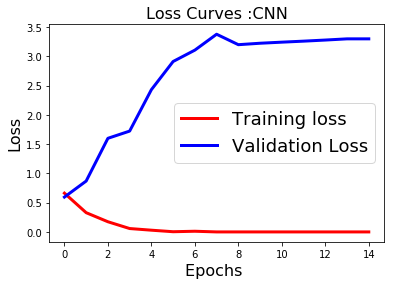

In [19]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

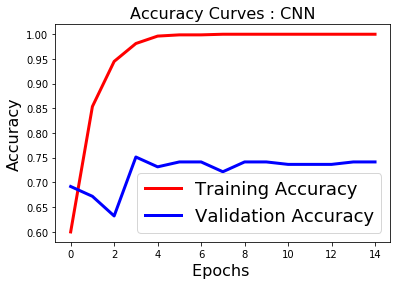

In [20]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()  